# Импорт библиотек и загрузка данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import country_converter as coco

# Импорт для машинного обучения
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix, 
                           precision_score, recall_score, precision_recall_curve, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight

# Импорт моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.svm import SVC            -- Слишком долго считается на таком объёме данных
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# Для интерпретации
import shap

# Импорт для гиперпараметрической оптимизации
import optuna
from optuna.samplers import TPESampler
import time

from scipy.optimize import minimize
from scipy.stats import rankdata

# Для обработки текста
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Word2Vec
from gensim.models import Word2Vec

# SBERT
from sentence_transformers import SentenceTransformer

# PyTorch для MLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.init import kaiming_normal_, constant_  # Импортируем нужные функции

# Для табличных трансофрмеров
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

# Настройки для красивых графиков и чисел
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")
pd.set_option("display.float_format", "{:.3f}".format)
warnings.filterwarnings('ignore')


In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Данные я беру [отсюда](https://www.kaggle.com/datasets/codename007/funding-successful-projects?select=train.csv). Выбрал именно этот датасет, так как в нём было текстовое описание проекта и в данном проекте я хочу попробовать использовать это описание для предсказания.

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_train.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.000,drawing-for-dollars,False,US,USD,1241333999,1241334017,1240600507,1240602723,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.000,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,1242429000,1242432018,1240960224,1240975592,2,0
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.000,mr-squiggles,False,US,USD,1243027560,1243027818,1242163613,1242164398,0,0
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.000,help-me-write-my-second-novel,False,US,USD,1243555740,1243556121,1240963795,1240966730,18,1
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.000,support-casting-my-sculpture-in-bronze,False,US,USD,1243769880,1243770317,1241177914,1241180541,1,0


In [3]:
dict(data_train.iloc[0])

{'project_id': 'kkst1451568084',
 'name': 'drawing for dollars',
 'desc': 'I like drawing pictures. and then i color them too. so i thought i would suggest something for me to draw and then if someone wants...',
 'goal': 20.0,
 'keywords': 'drawing-for-dollars',
 'disable_communication': False,
 'country': 'US',
 'currency': 'USD',
 'deadline': 1241333999,
 'state_changed_at': 1241334017,
 'created_at': 1240600507,
 'launched_at': 1240602723,
 'backers_count': 3,
 'final_status': 1}

In [99]:
data_test.columns

Index(['project_id', 'name', 'desc', 'goal', 'keywords',
       'disable_communication', 'country', 'currency', 'deadline',
       'state_changed_at', 'created_at', 'launched_at'],
      dtype='object')

In [100]:
data_train.drop(['project_id'], axis= 1, inplace = True)

# EDA

Посмотрим на общее описание

In [101]:
print("Количество семплов (строк) тренировочного датасета: ", data_train.shape[0])
print("Количество признаков: ", data_train.shape[1])

Количество семплов (строк) тренировочного датасета:  108129
Количество признаков:  13


In [102]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108129 entries, 0 to 108128
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   name                   108126 non-null  object 
 1   desc                   108119 non-null  object 
 2   goal                   108129 non-null  float64
 3   keywords               108129 non-null  object 
 4   disable_communication  108129 non-null  bool   
 5   country                108129 non-null  object 
 6   currency               108129 non-null  object 
 7   deadline               108129 non-null  int64  
 8   state_changed_at       108129 non-null  int64  
 9   created_at             108129 non-null  int64  
 10  launched_at            108129 non-null  int64  
 11  backers_count          108129 non-null  int64  
 12  final_status           108129 non-null  int64  
dtypes: bool(1), float64(1), int64(6), object(5)
memory usage: 10.0+ MB


In [103]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63465 entries, 0 to 63464
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   project_id             63465 non-null  object 
 1   name                   63465 non-null  object 
 2   desc                   63461 non-null  object 
 3   goal                   63465 non-null  float64
 4   keywords               63465 non-null  object 
 5   disable_communication  63465 non-null  bool   
 6   country                63465 non-null  object 
 7   currency               63465 non-null  object 
 8   deadline               63465 non-null  int64  
 9   state_changed_at       63465 non-null  int64  
 10  created_at             63465 non-null  int64  
 11  launched_at            63465 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 5.4+ MB


Пропусков почти нет. Данные очень хорошего качества.

Однако в тестовом датасете есть данные без описания (4 проекта) - их нужно будет обработать отдельно на тестировании.

## Работа с пропусками

In [104]:
data_train.isna().sum()

name                      3
desc                     10
goal                      0
keywords                  0
disable_communication     0
country                   0
currency                  0
deadline                  0
state_changed_at          0
created_at                0
launched_at               0
backers_count             0
final_status              0
dtype: int64

Записей с пропусками мало так что посмотрим, что это за проекты

In [105]:
data_train[data_train.isna().any(axis=1)]

,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
13244,NaN,NaN,35000.000,you-have-the-power-to-put-our-film-in-theaters,False,US,USD,1323061140,1323061142,1320612894,1320620155,5,0
16386,NaN,NaN,200000.000,bullied-to-triumph,False,US,USD,1330524240,1330524241,1325021401,1325417731,1,0
19276,N/A (Canceled),NaN,50000.000,the-lineup-0,False,US,USD,1335042707,1331581327,1331063276,1331158307,0,0
32837,NaN,...,2000.000,unlamentia-straima-maybe-more,False,GB,GBP,1357509600,1357509632,1355858653,1355957868,12,0
67393,OF Press - A WordPress Theme and Site Builder ...,NaN,5000.000,of-press,False,US,USD,1407707123,1406761089,1405032789,1405115123,4,0
67632,Blue Heart - Natural Remedies (Canceled),NaN,1500.000,blue-heart-natural-remedies,False,US,USD,1407811896,1407024116,1404522581,1405219896,3,0
68852,Vending Machine (Canceled),NaN,100.000,online-sticker-book-vending-machine,False,US,USD,1408334400,1408333920,1406991938,1407441222,2,0
73740,None (Canceled),NaN,2500.000,electroboard-the-new-electronic-skateboard,False,CA,CAD,1410878293,1408449352,1408279774,1408286293,4,0
75158,TEST (Canceled),NaN,1000001.000,caiman-connected-the-ultimate-mobile-device-ac...,False,US,USD,1411793329,1411694770,1410013102,1410583729,2,0
98721,N/A (Canceled),NaN,100000.000,international-festival-of-language-and-culture,False,US,USD,1427901540,1424449267,1424103554,1424210815,0,0


Видно, что все эти проекты провалились или даже скорее были отменены. Отменяя авторы видимо убрали описание.

Так как нас инересует описание проекта для предсказания, а пропусков крайне мало, то я просто выкину их.

В целом если посмотреть по датасету, то можно увидеть, что столбец name не всегда отражает действительность. Видимо сайт либо создатели проекта изменяют его постфактум (например, добавляя приписку Canceled или вовсе заменяя название на рандомные значения). Таким образом, столбцом name достоверно пользоваться нельзя - поэтому мы заменим его на информацию из keywords - там данные остаётся без изменений, хотя часть контекста и экспрессии, вроде регистра, специальных знаков и эмодзи вылетит.

In [106]:
data_train['name'] = data_train['keywords'].str.split('-').str.join(' ')
data_train.drop(['keywords'], axis=1, inplace=True)

data_test['name'] = data_test['keywords'].str.split('-').str.join(' ')
data_test.drop(['keywords'], axis=1, inplace=True)

In [107]:
data_train.isna().sum()

name                      0
desc                     10
goal                      0
disable_communication     0
country                   0
currency                  0
deadline                  0
state_changed_at          0
created_at                0
launched_at               0
backers_count             0
final_status              0
dtype: int64

In [108]:
data_train.dropna(inplace=True)

## Даты

Нас интересуют столбцы создания проекта, запуска проекта, дедлайна и завершения (последнего изменения состояния) проекта. Сначала переведём их в формат даты.

In [109]:
data_train["launched_at"] = pd.to_datetime(data_train["launched_at"], unit="s")
data_train["created_at"] = pd.to_datetime(data_train["created_at"], unit="s")
data_train["deadline"] = pd.to_datetime(data_train["deadline"], unit="s")
data_train["state_changed_at"] = pd.to_datetime(data_train["state_changed_at"], unit="s")

data_test["launched_at"] = pd.to_datetime(data_test["launched_at"], unit="s")
data_test["created_at"] = pd.to_datetime(data_test["created_at"], unit="s")
data_test["deadline"] = pd.to_datetime(data_test["deadline"], unit="s")
data_test["state_changed_at"] = pd.to_datetime(data_test["state_changed_at"], unit="s")

data_train["launched_at"].describe()

count                           108119
mean     2013-08-23 22:48:44.862734592
min                2009-04-24 19:52:03
25%                2012-08-02 14:24:28
50%                2014-01-28 00:11:06
75%         2014-10-08 22:34:35.500000
max                2015-05-26 16:41:13
Name: launched_at, dtype: object

Дата запуска проекта играет большую роль, поэтому её имеет смысл разобрать на месяц, день и год запуска:
- год оставляем в виде тренда (вычитаем минимум)
- месяц преобразуем через OHE
- день преобразуем через синус и косинус, чтобы закрепить цикличность
- отдельно выделим был ли запуск на выходных

In [110]:
# Год
data_train["year_trend"] = data_train["launched_at"].dt.year - data_train["launched_at"].dt.year.min()
data_test["year_trend"] = data_test["launched_at"].dt.year - data_test["launched_at"].dt.year.min()

# Месяц
data_train['month_launched'] = data_train["launched_at"].dt.month.astype("category")
data_test['month_launched'] = data_test["launched_at"].dt.month.astype("category")

# Делаем OHE месяца
data_train = pd.get_dummies(
    data_train,
    columns=["month_launched"],
    prefix="month_launched",        
    prefix_sep="_",        
    drop_first=True        
)
data_test = pd.get_dummies(
    data_test,
    columns=["month_launched"],
    prefix="month_launched",        
    prefix_sep="_",        
    drop_first=True        
)

# Преобразование дня
data_train["day_sin"] = np.sin(2 * np.pi * data_train["launched_at"].dt.day / 31)
data_train["day_cos"] = np.cos(2 * np.pi * data_train["launched_at"].dt.day / 31)

data_test["day_sin"] = np.sin(2 * np.pi * data_test["launched_at"].dt.day / 31)
data_test["day_cos"] = np.cos(2 * np.pi * data_test["launched_at"].dt.day / 31)

# Флаг на выходные
data_train["is_weekend"] = data_train["launched_at"].dt.dayofweek.isin([5, 6]).astype(int)
data_test["is_weekend"] = data_test["launched_at"].dt.dayofweek.isin([5, 6]).astype(int)

In [111]:
data_train.columns

Index(['name', 'desc', 'goal', 'disable_communication', 'country', 'currency',
       'deadline', 'state_changed_at', 'created_at', 'launched_at',
       'backers_count', 'final_status', 'year_trend', 'month_launched_2',
       'month_launched_3', 'month_launched_4', 'month_launched_5',
       'month_launched_6', 'month_launched_7', 'month_launched_8',
       'month_launched_9', 'month_launched_10', 'month_launched_11',
       'month_launched_12', 'day_sin', 'day_cos', 'is_weekend'],
      dtype='object')

Остальные даты нас интересуют только с точки зрения количества времени между ними - будем мерить в днях, поэтому нормализуем.

Дату смены статуса придётся убрать, так как по ней можно косвенно понять успех проекта - если статус сменился до дедлайна, значит проект скорее всего отменили или что-то подобное (при успехе реже закрывают, так это возможность набрать финансирование больше суммы). Кроме того, на момент запуска эта информация нам не должна быть известна, так как это подглядываие в будущее.

In [ ]:
data_train['created_dif'] = (data_train['launched_at'] - data_train['created_at']).dt.days
data_train['campaign_duration'] = (data_train['deadline'] - data_train['launched_at']).dt.days
data_train.drop(['state_changed_at', 'launched_at', 'created_at', 'deadline'], axis = 1, inplace=True)

data_test['created_dif'] = (data_test['launched_at'] - data_test['created_at']).dt.days
data_test['campaign_duration'] = (data_test['deadline'] - data_test['launched_at']).dt.days
data_test.drop(['state_changed_at', 'launched_at', 'created_at', 'deadline'], axis = 1, inplace=True)

In [113]:
data_train.columns

Index(['name', 'desc', 'goal', 'disable_communication', 'country', 'currency',
       'backers_count', 'final_status', 'year_trend', 'month_launched_2',
       'month_launched_3', 'month_launched_4', 'month_launched_5',
       'month_launched_6', 'month_launched_7', 'month_launched_8',
       'month_launched_9', 'month_launched_10', 'month_launched_11',
       'month_launched_12', 'day_sin', 'day_cos', 'is_weekend', 'created_dif',
       'campaign_duration'],
      dtype='object')

Нормализация будет проведена после преобразований остальных переменных.

## Категориальные переменные

In [114]:
data_train[['disable_communication', 'country', 'currency']]

,disable_communication,country,currency
0,False,US,USD
1,False,US,USD
2,False,US,USD
3,False,US,USD
4,False,US,USD
...,...,...,...
108124,False,US,USD
108125,False,US,USD
108126,False,US,USD
108127,False,US,USD


### **disable_communication**

Отключение комментариев важный, хотя и крайне редкий признак. Бинаризируем.

In [115]:
data_train['disable_communication'] = data_train['disable_communication'].astype(int)
data_test['disable_communication'] = data_test['disable_communication'].astype(int)

### **country**

In [116]:
data_train['country'].unique()

array(['US', 'GB', 'CA', 'AU', 'NZ', 'NL', 'SE', 'IE', 'NO', 'DK', 'DE'],
      dtype=object)

In [117]:
data_test['country'].unique()

array(['US', 'IT', 'GB', 'AU', 'NO', 'NL', 'SE', 'ES', 'DK', 'CA', 'DE',
       'IE', 'FR', 'NZ', 'CH', 'BE', 'AT', 'LU', 'HK', 'SG', 'MX'],
      dtype=object)

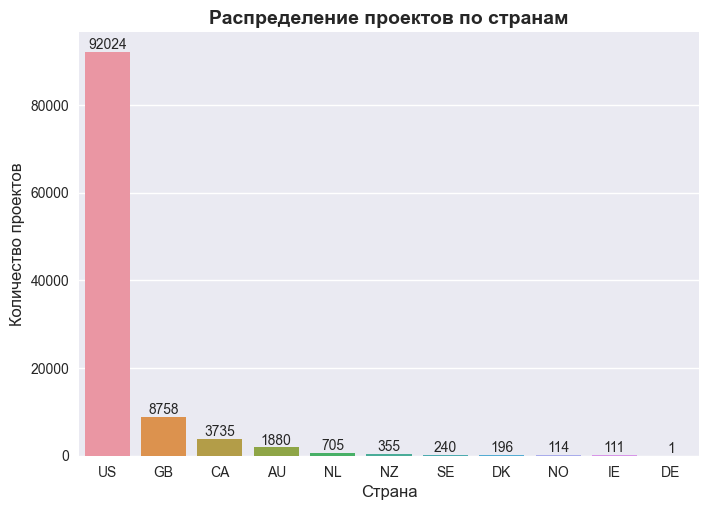

In [118]:
train_counts_info = data_train["country"].value_counts()
sns.countplot(data_train, x = 'country', order = train_counts_info.index)
plt.title('Распределение проектов по странам', fontsize=14, fontweight='bold')
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Количество проектов', fontsize=12)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', fontsize=10)
plt.show()

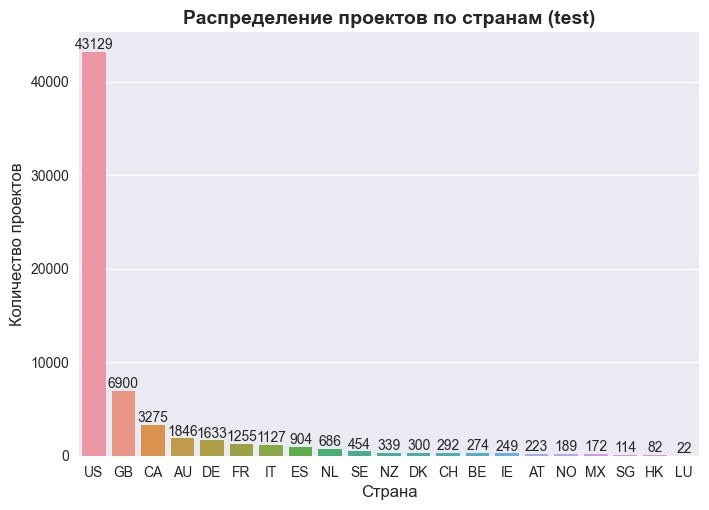

In [119]:
test_counts_info = data_test["country"].value_counts()
sns.countplot(data_test, x = 'country', order=test_counts_info.index)
plt.title('Распределение проектов по странам (test)', fontsize=14, fontweight='bold')
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Количество проектов', fontsize=12)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', fontsize=10)
plt.show()

Видно, что подавляющая часть проектов из США. Кроме того, в тестовом датасете много стран, которых не было в train. Стран очень много, так что сузим их до континентов (Северная Америка, Европа, Океания, Азия и тд)

In [ ]:
# Конвертируем коды стран в регионы
cc = coco.CountryConverter()
data_train["region"] = data_train["country"].apply(
    lambda x: cc.convert(names=x, to="continent", not_found="Other")
)

data_test["region"] = data_test["country"].apply(
    lambda x: cc.convert(names=x, to="continent", not_found="Other")
)

In [121]:
data_train["region"].value_counts()

region
America    95759
Europe     10125
Oceania     2235
Name: count, dtype: int64

In [122]:
data_test["region"].value_counts()

region
America    46576
Europe     14508
Oceania     2185
Asia         196
Name: count, dtype: int64

Азии очень мало и она только в тесте, так что объеденяем с океанией.

In [123]:
data_test["region"] = data_test["region"].apply(lambda x: x if x != 'Asia' else 'Oceania')

Теперь делаем One Hot Encoding

In [ ]:
data_train = pd.get_dummies(
    data_train,
    columns=["region"],
    prefix="region",        
    prefix_sep="_",        
    drop_first=True        
)
data_test = pd.get_dummies(
    data_test,
    columns=["region"],
    prefix="region",        
    prefix_sep="_",        
    drop_first=True        
)

data_train.drop(['country'], axis=1, inplace=True)
data_test.drop(['country'], axis=1, inplace=True)

### **currency**

In [125]:
data_train['currency'].unique()

array(['USD', 'GBP', 'CAD', 'AUD', 'NZD', 'EUR', 'SEK', 'NOK', 'DKK'],
      dtype=object)

In [126]:
data_test['currency'].unique()

array(['USD', 'EUR', 'GBP', 'AUD', 'NOK', 'SEK', 'DKK', 'CAD', 'NZD',
       'CHF', 'HKD', 'SGD', 'MXN'], dtype=object)

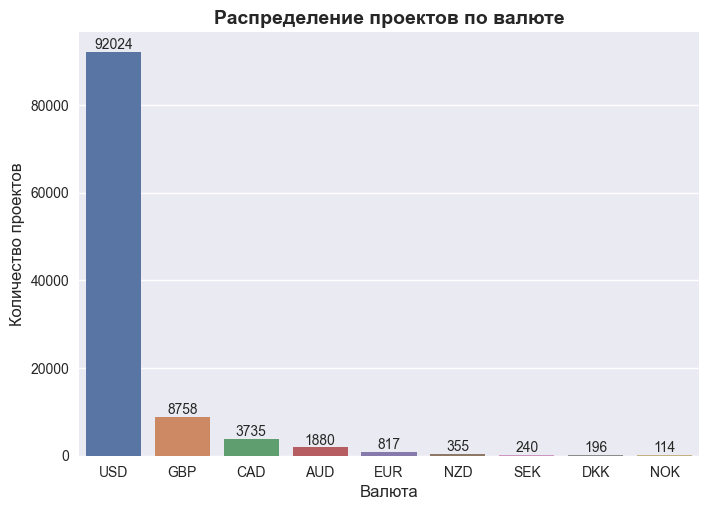

In [127]:
train_counts_info = data_train["currency"].value_counts()
sns.countplot(data_train, x = 'currency', order = train_counts_info.index)
plt.title('Распределение проектов по валюте', fontsize=14, fontweight='bold')
plt.xlabel('Валюта', fontsize=12)
plt.ylabel('Количество проектов', fontsize=12)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', fontsize=10)
plt.show()

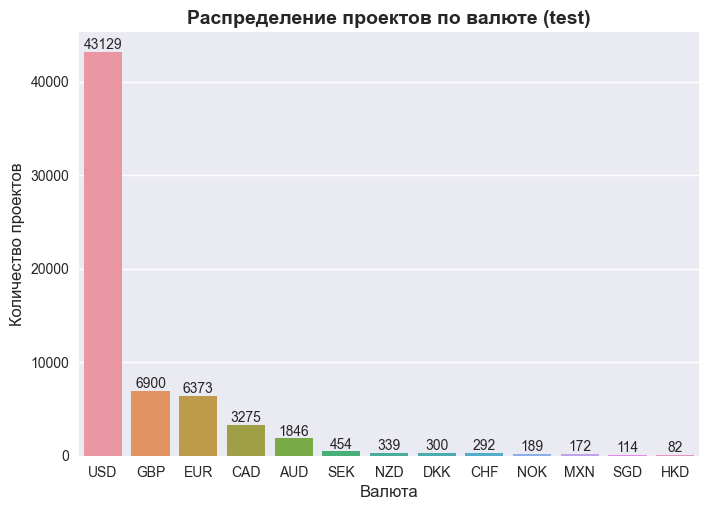

In [128]:
test_counts_info = data_test["currency"].value_counts()
sns.countplot(data_test, x = 'currency', order=test_counts_info.index)
plt.title('Распределение проектов по валюте (test)', fontsize=14, fontweight='bold')
plt.xlabel('Валюта', fontsize=12)
plt.ylabel('Количество проектов', fontsize=12)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', fontsize=10)
plt.show()

Ожидаемо самая распространённая валюта - доллары. Оставим только самые популярные валюты (USD, GBP, EUR и CAD). Остальное положим в отдельную категорию.

In [129]:
main_currencies = set(['USD', 'GBP', 'EUR', 'CAD'])
data_train['currency'] = data_train['currency'].apply(lambda x: x if x in main_currencies else 'Other')
data_test['currency'] = data_test['currency'].apply(lambda x: x if x in main_currencies else 'Other')

Теперь делаем OHE.

In [130]:
data_train = pd.get_dummies(
    data_train,
    columns=["currency"],
    prefix="currency",        
    prefix_sep="_",        
    drop_first=True        
)
data_test = pd.get_dummies(
    data_test,
    columns=["currency"],
    prefix="currency",        
    prefix_sep="_",        
    drop_first=True        
)

In [131]:
data_train.columns

Index(['name', 'desc', 'goal', 'disable_communication', 'backers_count',
       'final_status', 'year_trend', 'month_launched_2', 'month_launched_3',
       'month_launched_4', 'month_launched_5', 'month_launched_6',
       'month_launched_7', 'month_launched_8', 'month_launched_9',
       'month_launched_10', 'month_launched_11', 'month_launched_12',
       'day_sin', 'day_cos', 'is_weekend', 'created_dif', 'campaign_duration',
       'region_Europe', 'region_Oceania', 'currency_EUR', 'currency_GBP',
       'currency_Other', 'currency_USD'],
      dtype='object')

In [132]:
data_test.columns

Index(['project_id', 'name', 'desc', 'goal', 'disable_communication',
       'year_trend', 'month_launched_2', 'month_launched_3',
       'month_launched_4', 'month_launched_5', 'month_launched_6',
       'month_launched_7', 'month_launched_8', 'month_launched_9',
       'month_launched_10', 'month_launched_11', 'month_launched_12',
       'day_sin', 'day_cos', 'is_weekend', 'created_dif', 'campaign_duration',
       'region_Europe', 'region_Oceania', 'currency_EUR', 'currency_GBP',
       'currency_Other', 'currency_USD'],
      dtype='object')

## Таргет

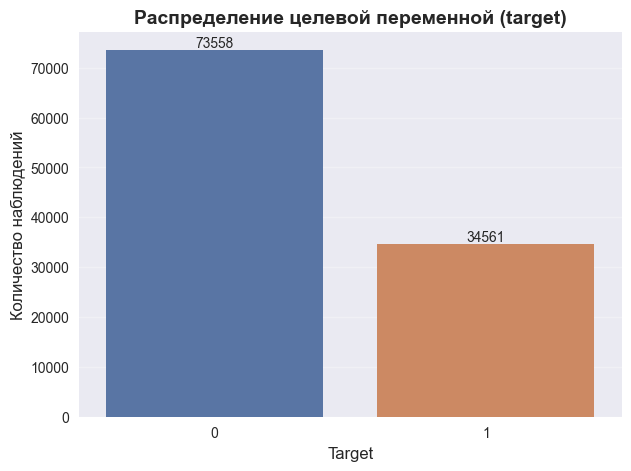

In [133]:
plt.figure(figsize=(7, 5))

sns.countplot(data=data_train, x='final_status')

plt.title('Распределение целевой переменной (target)', fontsize=14, fontweight='bold')
plt.xlabel('Target', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', fontsize=10)
    
plt.grid(axis='y', alpha=0.3)
plt.show()

Виден явный дисбаланс классов - провалившихся проктов в два раза больше. Это довольно ожидаемо для краудфаундинговой платформы. В дальнейшем будем учитывать этот дисбаланс.

## Разбиение на train/test

In [134]:
y = data_train['final_status'].copy()
X = data_train.drop(['final_status'], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Числовые признаки

### Goal

In [135]:
data_train['goal'].describe()

count      108119.000
mean        36716.727
std        971943.060
min             0.010
25%          2000.000
50%          5000.000
75%         13000.000
max     100000000.000
Name: goal, dtype: float64

По статистикам видно, что у показателя сильный правосторонний перекос (очень много проектов с маленькой целью + выбросы с большими целями). Из-за этого обычная нормализация не подойдёт - сначала сделаем логарифмическое преобразование, а потом применим RobustScaler (чтобы точно минимизировать влияние выбросов)

In [136]:
# Логарифимруем
X_train["goal"] = np.log10(X_train["goal"] + 1)
X_test["goal"] = np.log10(X_test["goal"] + 1)
data_test["goal"] = np.log10(data_test["goal"] + 1)

# Нормализуем
scaler = RobustScaler()
X_train["goal"] = scaler.fit_transform(X_train[["goal"]])
X_test["goal"] = scaler.transform(X_test[["goal"]])
data_test["goal"] = scaler.transform(data_test[["goal"]])

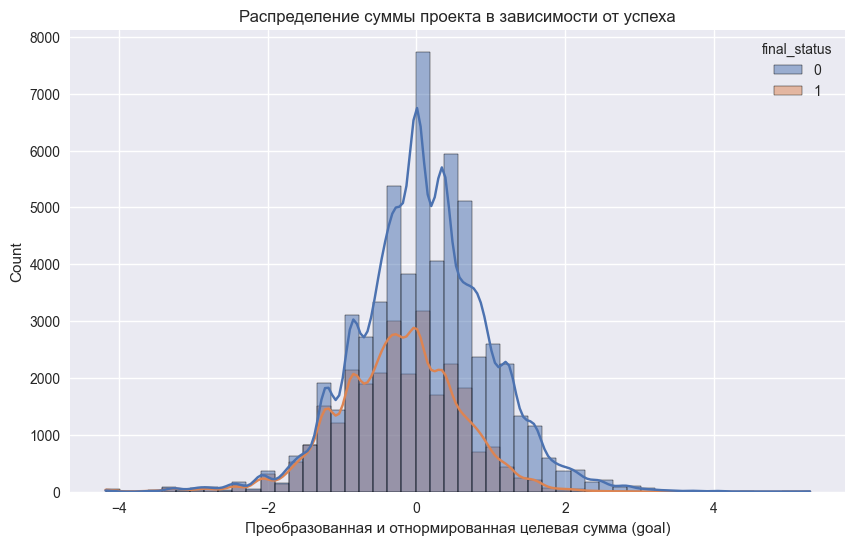

In [137]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["goal"],
    hue=y_train,
    bins=50,
    kde=True,     
    common_norm=False   
)
plt.xlabel("Преобразованная и отнормированная целевая сумма (goal)")
plt.title("Распределение суммы проекта в зависимости от успеха")
plt.show()

Видно что проекты с большей суммой имеют немного меньший успех.

### Количество бекеров

Как выяснилось в тестовом датасете почему-то нет этой колонки, однако мы всё равно её обработаем (по крайней мере она будет на нашем тесте).

In [138]:
data_train['backers_count'].describe()

count   108119.000
mean       123.528
std       1176.799
min          0.000
25%          2.000
50%         17.000
75%         65.000
max     219382.000
Name: backers_count, dtype: float64

In [139]:
(data_train['backers_count'] == 0).value_counts(normalize=True)

backers_count
False   0.881
True    0.119
Name: proportion, dtype: float64

Ситуация здесь почти такая же как и у Goal. Однако важно отметить, что есть достаточно много (12%) проектов без бекеров. Для нормализации применим аналогичную схему логарифмирования + RobustScaler.

In [140]:
# Логарифимруем
X_train["backers_count"] = np.log10(X_train["backers_count"] + 1)
X_test["backers_count"] = np.log10(X_test["backers_count"] + 1)

# Нормализуем
scaler = RobustScaler()
X_train["backers_count"] = scaler.fit_transform(X_train[["backers_count"]])
X_test["backers_count"] = scaler.transform(X_test[["backers_count"]])

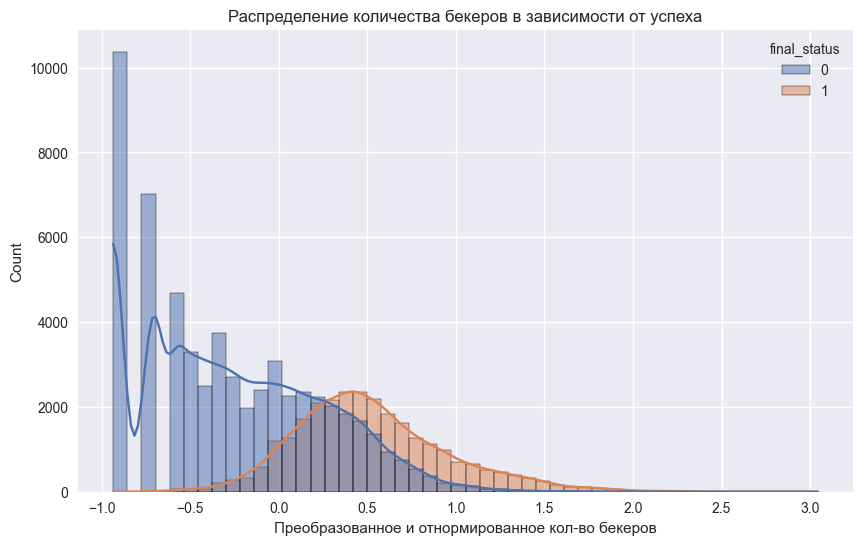

In [141]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["backers_count"],
    hue=y_train,
    bins=50,
    kde=True,     
    common_norm=False   
)
plt.xlabel("Преобразованное и отнормированное кол-во бекеров")
plt.title("Распределение количества бекеров в зависимости от успеха")
plt.show()

Ожидаемо у успешных проектов обычно больше бекеров.

### Колчество дней между созданием и запуском программы (created_dif)

In [142]:
data_train['created_dif'].describe()

count   108119.000
mean        37.277
std         87.152
min          0.000
25%          3.000
50%         10.000
75%         32.000
max       1903.000
Name: created_dif, dtype: float64

Аналогично

In [143]:
# Логарифимруем
X_train["created_dif"] = np.log10(X_train["created_dif"] + 1)
X_test["created_dif"] = np.log10(X_test["created_dif"] + 1)

# Нормализуем
scaler = RobustScaler()
X_train["created_dif"] = scaler.fit_transform(X_train[["created_dif"]])
X_test["created_dif"] = scaler.transform(X_test[["created_dif"]])

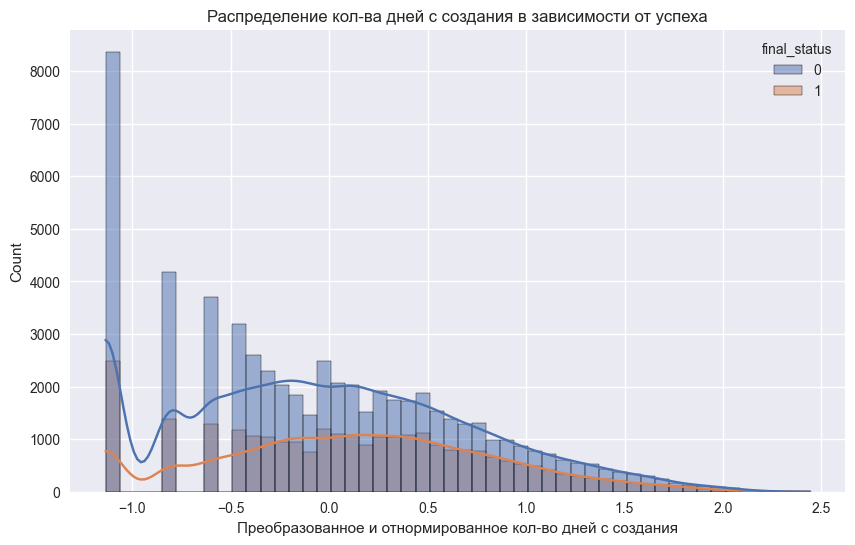

In [144]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["created_dif"],
    hue=y_train,
    bins=50,
    kde=True,     
    common_norm=False   
)
plt.xlabel("Преобразованное и отнормированное кол-во дней с создания")
plt.title("Распределение кол-ва дней с создания в зависимости от успеха")
plt.show()

Видимой разницы не наблюдается

### Длительность проекта (campaign_duration)

In [145]:
data_train['campaign_duration'].describe()

count   108119.000
mean        33.917
std         12.936
min          1.000
25%         30.000
50%         30.000
75%         36.000
max         91.000
Name: campaign_duration, dtype: float64

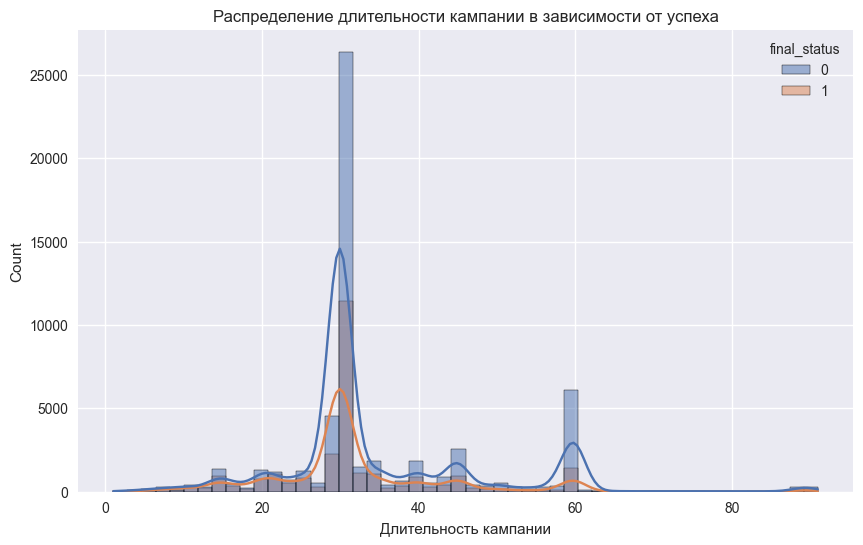

In [146]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["campaign_duration"],
    hue=y_train,
    bins=50,
    kde=True,     
    common_norm=False   
)
plt.xlabel("Длительность кампании")
plt.title("Распределение длительности кампании в зависимости от успеха")
plt.show()

Выводы:
- Самый популярный дедлайн - около месяца
- Второй по популярности - два месяца.
- Ярких различий по успеху не наблюдается

Зависимость здесь нелинейная, поэтому имеет смысл разделить на категории:
- сверх-короткие (1-14 дней)
- короткие (15-24 дней)
- нормальные ( 25- 35 дней)
- длинные (36 - 54 дней)
- двух-месячные (55 - 65 дней)
- сверхдлинные ( больше 65 дней)

In [147]:
def categorize_duration(days):
    if days <= 14:
        return "Very_Short"
    elif 15 <= days <= 24:
        return "Short"
    elif 25 <= days <= 35:
        return "Normal"
    elif 36 <= days <= 54:
        return "Long"
    elif 55 <= days <= 65:
        return "Two_month"
    else:
        return "Very_long"

X_train["duration_category"] = X_train["campaign_duration"].apply(categorize_duration)
X_test["duration_category"] = X_test["campaign_duration"].apply(categorize_duration)

In [148]:
X_train['duration_category'].unique()

array(['Very_Short', 'Normal', 'Long', 'Two_month', 'Short', 'Very_long'],
      dtype=object)

In [149]:
X_test['duration_category'].unique()

array(['Normal', 'Two_month', 'Long', 'Very_Short', 'Short', 'Very_long'],
      dtype=object)

In [150]:
X_train = pd.get_dummies(
    X_train,
    columns=["duration_category"],
    prefix="campaign_duration",        
    prefix_sep="_"       
)
X_train.drop(['campaign_duration_Normal', 'campaign_duration'], axis=1, inplace=True)

X_test = pd.get_dummies(
    X_test,
    columns=["duration_category"],
    prefix="campaign_duration",        
    prefix_sep="_"     
)
X_test.drop(['campaign_duration_Normal', 'campaign_duration'], axis=1, inplace=True)

In [151]:
X_test.columns

Index(['name', 'desc', 'goal', 'disable_communication', 'backers_count',
       'year_trend', 'month_launched_2', 'month_launched_3',
       'month_launched_4', 'month_launched_5', 'month_launched_6',
       'month_launched_7', 'month_launched_8', 'month_launched_9',
       'month_launched_10', 'month_launched_11', 'month_launched_12',
       'day_sin', 'day_cos', 'is_weekend', 'created_dif', 'region_Europe',
       'region_Oceania', 'currency_EUR', 'currency_GBP', 'currency_Other',
       'currency_USD', 'campaign_duration_Long', 'campaign_duration_Short',
       'campaign_duration_Two_month', 'campaign_duration_Very_Short',
       'campaign_duration_Very_long'],
      dtype='object')

## Описание и название (простые признаки)

Прежде чем предсказывать с помощью сложных моделей построим простые модели без полного анализа и использования текста описания и названия. Но всё же оставим самые поверхностные признаки:
- длину описания (в словах)
- длину названия (в словах)
- доля заглавных букв в описании
- количество восклицательных и вопросительных знаков

In [152]:
X_train['words_name'] = X_train['name'].apply(lambda x: len(x.split()))
X_train['words_desc'] = X_train['desc'].apply(lambda x: len(x.split()))
X_train['uppercase_ratio'] = X_train['desc'].apply(lambda text: sum(1 for char in text if char.isupper()) / max(len(text), 1))
X_train['exlam_and_quest'] = X_train['desc'].apply(lambda text: sum(1 for char in text if char == '!' or char == '?'))

X_test['words_name'] = X_test['name'].apply(lambda x: len(x.split()))
X_test['words_desc'] = X_test['desc'].apply(lambda x: len(x.split()))
X_test['uppercase_ratio'] = X_test['desc'].apply(lambda text: sum(1 for char in text if char.isupper()) / max(len(text), 1))
X_test['exlam_and_quest'] = X_test['desc'].apply(lambda text: sum(1 for char in text if char == '!' or char == '?'))

Посмотрим на распределения

### Кол-во слов в названии

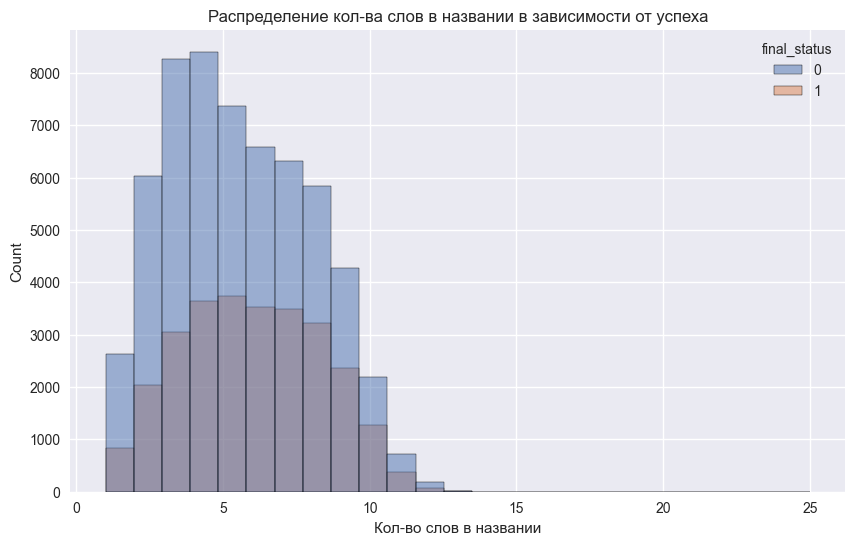

In [153]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["words_name"],
    hue=y_train,
    bins=25,     
    common_norm=False   
)
plt.xlabel("Кол-во слов в названии")
plt.title("Распределение кол-ва слов в названии в зависимости от успеха")
plt.show()

В целом более короткие названии как будто чаще проваливаются. Сделаем стандартную нормировку.

In [154]:
scaler = StandardScaler()
X_train['words_name'] = scaler.fit_transform(X_train[['words_name']])
X_test['words_name'] = scaler.transform(X_test[['words_name']])

### Кол-во слов в описании

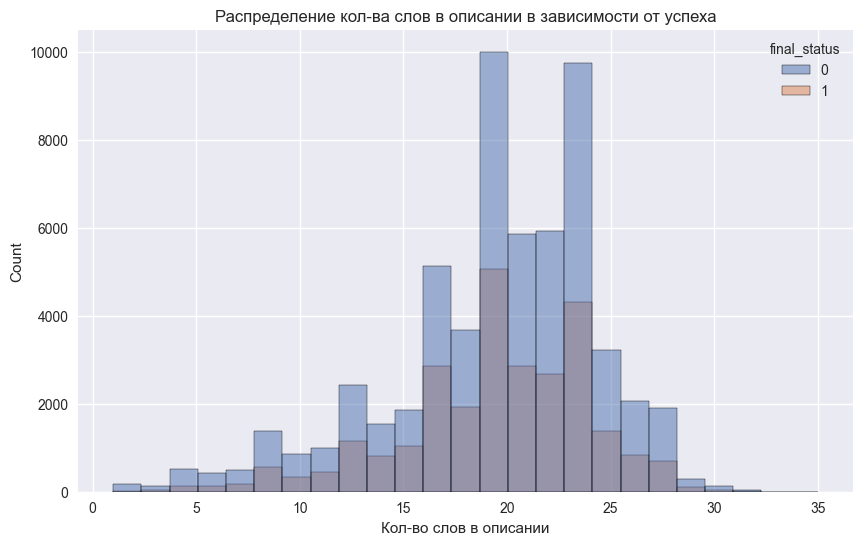

In [155]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["words_desc"],
    hue=y_train,
    bins=25,     
    common_norm=False   
)
plt.xlabel("Кол-во слов в описании")
plt.title("Распределение кол-ва слов в описании в зависимости от успеха")
plt.show()

Явных различий не видно. Опять же делаем нормировку для единообразия.

In [156]:
scaler = StandardScaler()
X_train['words_desc'] = scaler.fit_transform(X_train[['words_desc']])
X_test['words_desc'] = scaler.transform(X_test[['words_desc']])

### Доля заглавных букв в описании

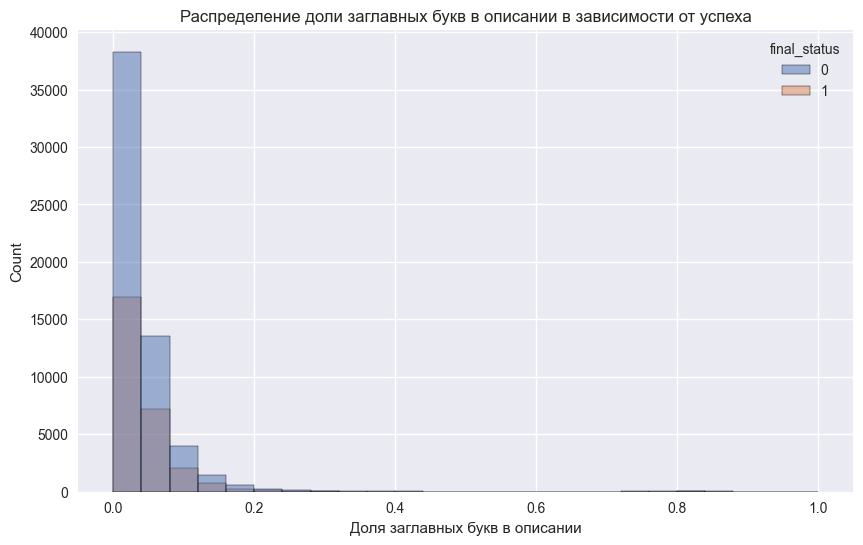

In [157]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["uppercase_ratio"],
    hue=y_train,
    bins=25,     
    common_norm=False   
)
plt.xlabel("Доля заглавных букв в описании")
plt.title("Распределение доли заглавных букв в описании в зависимости от успеха")
plt.show()

Здесь видна логарифимическая зависимость, так что логарифмируем и нормализуем.

In [158]:
X_train['uppercase_ratio'] = np.log(X_train[['uppercase_ratio']] + 0.01)
X_test['uppercase_ratio'] = np.log(X_test[['uppercase_ratio']] + 0.01)

scaler = StandardScaler()
X_train['uppercase_ratio'] = scaler.fit_transform(X_train[['uppercase_ratio']])
X_test['uppercase_ratio'] = scaler.transform(X_test[['uppercase_ratio']])

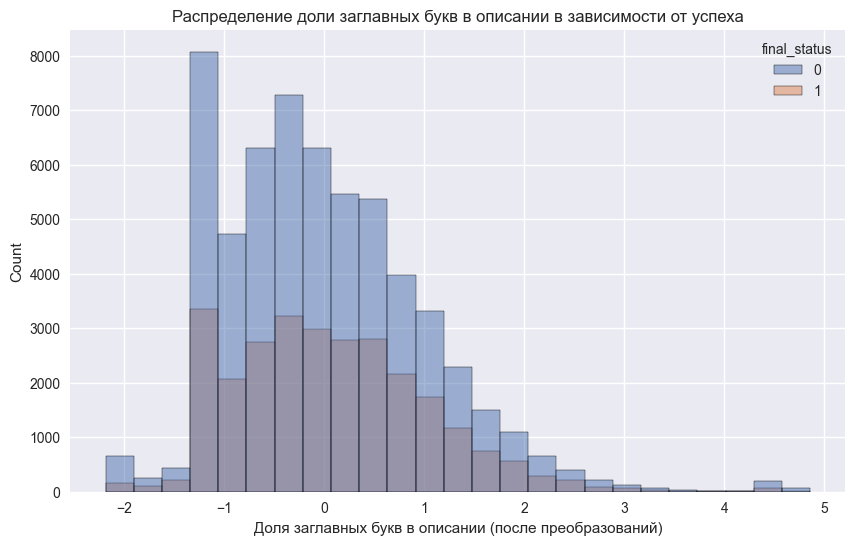

In [159]:
plt.figure(figsize=(10, 6))
sns.histplot(
    x=X_train["uppercase_ratio"],
    hue=y_train,
    bins=25,     
    common_norm=False   
)
plt.xlabel("Доля заглавных букв в описании (после преобразований)")
plt.title("Распределение доли заглавных букв в описании в зависимости от успеха")
plt.show()

### Кол-во восклицательных и вопросительных знаков

In [160]:
X_train["exlam_and_quest"].describe()

count   86495.000
mean        0.369
std         0.747
min         0.000
25%         0.000
50%         0.000
75%         1.000
max        17.000
Name: exlam_and_quest, dtype: float64

Посмотрев на статистику можно сказать, что так признак использовать не получится - в большинстве описаний ! и ? нет вовсе или он всего 1. Тогда переделаем признак:
- 0 если нет знаков
- 1 - если 1-3 знака
- 2 - если 4-9 знака
- 3 - если больше 9

In [161]:
def exlam_and_quest_classifier(counter):
    if counter == 0:
        return 0
    elif counter < 4:
        return 1
    elif counter < 9:
        return 2
    else:
        return 3

X_train["exlam_and_quest"] = X_train["exlam_and_quest"].apply(exlam_and_quest_classifier)

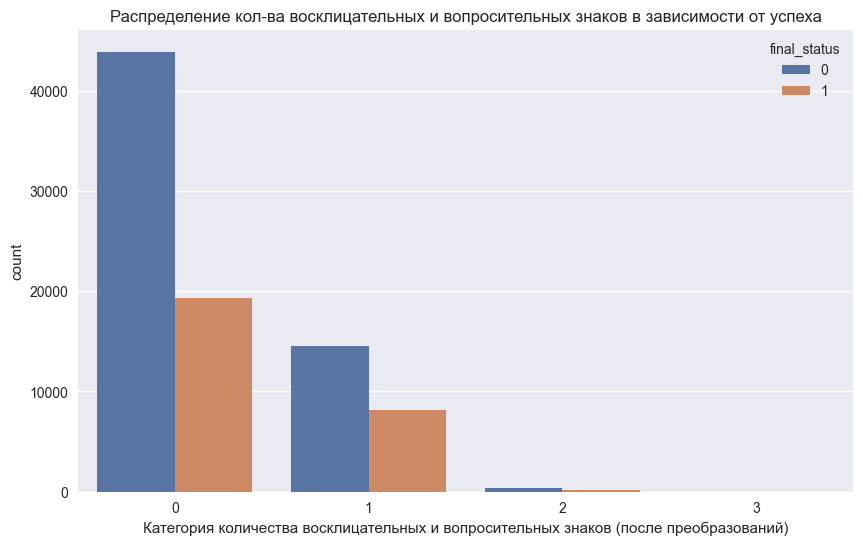

In [162]:
plt.figure(figsize=(10, 6))
sns.countplot(
    x=X_train["exlam_and_quest"],
    hue=y_train  
)
plt.xlabel("Категория количества восклицательных и вопросительных знаков (после преобразований)")
plt.title("Распределение кол-ва восклицательных и вопросительных знаков в зависимости от успеха")
plt.show()

# Выбор метрик

Учитывая, что у нас дибаланс классов (провалившихся где-то в два больше) в качестве основной метрики возьмём f1-score - она неплохо подходит для умеренного дисбаланса в классах.

Система Kaggle тестирует по ROC-AUC, но учитывая дисбаланс в качестве дополнительной возьмём лучше PR AUC - будем смотреть на эффективность поиска успехов.

## Код для отрисовки одиночной PR AUC

In [23]:
def plot_precision_recall_curve(y_true, y_proba, title="Precision-Recall Curve"):
    """
    Строит график Precision-Recall с дополнительной аналитикой
    :param y_true: Истинные метки (0/1)
    :param y_proba: Вероятности класса 1
    :param title: Заголовок графика
    """
    # 1. Вычисляем precision, recall и пороги
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    
    # 2. Считаем PR AUC
    pr_auc = average_precision_score(y_true, y_proba)
    
    # 3. Считаем baseline (доля успехов в данных)
    baseline = y_true.mean()
    
    # 4. Находим оптимальный порог (максимальный F1)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # +1e-10 избегает деления на 0
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx] if max_f1_idx < len(thresholds) else 1.0
    
    # 5. Строим график
    plt.figure(figsize=(10, 7))
    
    # Основная кривая
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Модель (PR AUC = {pr_auc:.3f})')
    
    # Baseline (уровень случайного угадывания)
    plt.axhline(y=baseline, color='red', linestyle='--', 
                label=f'Baseline (доля успехов = {baseline:.3f})')
    
    # Оптимальный порог
    plt.scatter(recall[max_f1_idx], precision[max_f1_idx], 
                marker='o', color='green', s=150, 
                label=f'Оптимальный порог = {optimal_threshold:.3f}\n(F1 = {f1_scores[max_f1_idx]:.3f})')
    
    # Декорации
    plt.xlabel('Recall (доля найденных успехов)', fontsize=12)
    plt.ylabel('Precision (точность предсказаний)', fontsize=12)
    plt.title(f'{title} (дисбаланс: {baseline:.0%} успехов)', fontsize=14)
    plt.legend(loc="upper right", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    
    plt.show()
    
    return optimal_threshold, pr_auc

## Код для вывода нескольких PR AUC

In [24]:
def plot_precision_recall_curve_multiple(results, y_true, title="Precision-Recall Curve"):
    
    plt.figure(figsize=(10, 7))

    # Считаем baseline (доля успехов в данных)
    baseline = y_true.mean()
    plt.axhline(y=baseline, color='red', linestyle='--', 
                    label=f'Baseline (доля успехов = {baseline:.3f})')

    for name, result in results.items():
        precision, recall, thresholds = precision_recall_curve(y_true, result['probabilities'])
        pr_auc = average_precision_score(y_true, result['probabilities'])

        # Основная кривая
        plt.plot(recall, precision, lw=2, 
                label=f"{name} (PR AUC = {pr_auc:.3f})")
    
    
    # Декорации
    plt.xlabel('Recall (доля найденных успехов)', fontsize=12)
    plt.ylabel('Precision (точность предсказаний)', fontsize=12)
    plt.title(f'{title} (дисбаланс: {baseline:.0%} успехов)', fontsize=14)
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    
    plt.show()

## Код для подсчёта и вывода результатов

In [25]:
def process_result(model, X_train, X_test, y_train = y_train, y_test = y_test, do_cross_val= True):
    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    result =  {
            'model': model,
            'f1_test': f1_score(y_test, y_pred),
            'PR_AUC_test': average_precision_score(y_test, y_pred_proba),
            'accuracy': accuracy_score(y_test, y_pred),
            'predictions': y_pred,
            'probabilities': y_pred_proba
            }

    # Кросс-валидация на обучающей выборке
    if do_cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

        result['f1_cv_mean'] = cv_scores.mean()
        result['f1_cv_std'] = cv_scores.std()
        result['cv_scores'] = cv_scores

    return result


def print_results(results):
    print(f"Тестовый f1-score: {results['f1_test']:.3f}")
    print()
    print(f"Тестовый PR AUC: {results['PR_AUC_test']:.3f}")
    print()
    print(f"Тестовый accuracy: {results['accuracy']:.3f}")
    print()
    print(f"Средний f1-score на кросс-валидации: {results['f1_cv_mean']:.3f}")
    print()
    print(f"Дисперсия f1-score на кросс-валидации: {results['f1_cv_std']:.3f}")
    print()

# Модели без прямого использования текста

Выделим все столбцы, кроме текстовых

In [279]:
X_train_no_text = X_train.drop(['name', 'desc'], axis=1)
X_test_no_text = X_test.drop(['name', 'desc'], axis=1)

Далее обучим разные модели для предсказания - будем переходить от простых к сложным:
- логистическая регрессия
- случайный лес

## Простые baseline модели

### Выбор модели

В этом разделе прогоним все простые baseline модели и по результатам выберем лучшую и пооптимизируем параметры. Не стал считать SVM, так как она очень долго считается.

In [95]:
models = {
    'Логистическая регрессия': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'description': 'Линейная модель с сигмоидной функцией'
    },
    'Деревья решений': {
        'model': DecisionTreeClassifier(random_state=42, max_depth=10),
        'description': 'Построение дерева решений с правилами'
    },
    'Случайный лес': {
        'model': RandomForestClassifier(n_estimators=100, random_state=42),
        'description': 'Ансамбль деревьев решений'
    },
    'Наивный Байес': {
        'model': GaussianNB(),
        'description': 'Вероятностная модель с предположением о независимости'
    },
    'k-NN': {
        'model': KNeighborsClassifier(n_neighbors=5),
        'description': 'Классификация по ближайшим соседям'
    }
}

In [96]:
results = {}
trained_models = {}

for name, info in models.items():
    print('***************************************')
    print(f"Обучение: {name}")
    print('---------------------------------------')

    start = time.time()
    
    model = info['model']
    model.fit(X_train_no_text, y_train)
    
    # Сохраняем предсказания и метрики
    results[name] = process_result(model, X_train_no_text, X_test_no_text)
    
    # Сохраняем обученную модель
    trained_models[name] = model

    print(f'Время на обучение: {(time.time() - start):.1f} сек')
    print()
    
    print_results(results[name])

***************************************
Обучение: Логистическая регрессия
---------------------------------------
Время на обучение: 2.3 сек

Тестовый f1-score: 0.811

Тестовый PR AUC: 0.884

Тестовый accuracy: 0.876

Средний f1-score на кросс-валидации: 0.810

Дисперсия f1-score на кросс-валидации: 0.002

***************************************
Обучение: Деревья решений
---------------------------------------
Время на обучение: 1.9 сек

Тестовый f1-score: 0.801

Тестовый PR AUC: 0.840

Тестовый accuracy: 0.867

Средний f1-score на кросс-валидации: 0.795

Дисперсия f1-score на кросс-валидации: 0.003

***************************************
Обучение: Случайный лес
---------------------------------------
Время на обучение: 45.9 сек

Тестовый f1-score: 0.803

Тестовый PR AUC: 0.863

Тестовый accuracy: 0.870

Средний f1-score на кросс-валидации: 0.803

Дисперсия f1-score на кросс-валидации: 0.001

***************************************
Обучение: Наивный Байес
-----------------------------

In [98]:
# Создаем сравнительную таблицу результатов
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'f1-score test': [results[name]['f1_test'] for name in results.keys()],
    'PR AUC test': [results[name]['PR_AUC_test'] for name in results.keys()],
    'CV f1-score': [results[name]['f1_cv_mean'] for name in results.keys()],
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Описание': [models[name]['description'] for name in results.keys()]
})

# Сортируем по f1-score на тесте
results_df = results_df.sort_values('f1-score test', ascending=False).reset_index(drop=True)

print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("=" * 128)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\nЛучшая модель по f1-score test: {results_df.iloc[0]['Модель']} ({results_df.iloc[0]['f1-score test']:.3f})")

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
                 Модель  f1-score test  PR AUC test  CV f1-score  Accuracy                                              Описание
Логистическая регрессия          0.811        0.884        0.810     0.876                 Линейная модель с сигмоидной функцией
          Случайный лес          0.803        0.863        0.803     0.870                             Ансамбль деревьев решений
        Деревья решений          0.801        0.840        0.795     0.867                 Построение дерева решений с правилами
                   k-NN          0.617        0.630        0.621     0.769                    Классификация по ближайшим соседям
          Наивный Байес          0.502        0.655        0.502     0.379 Вероятностная модель с предположением о независимости

Лучшая модель по f1-score test: Логистическая регрессия (0.811)


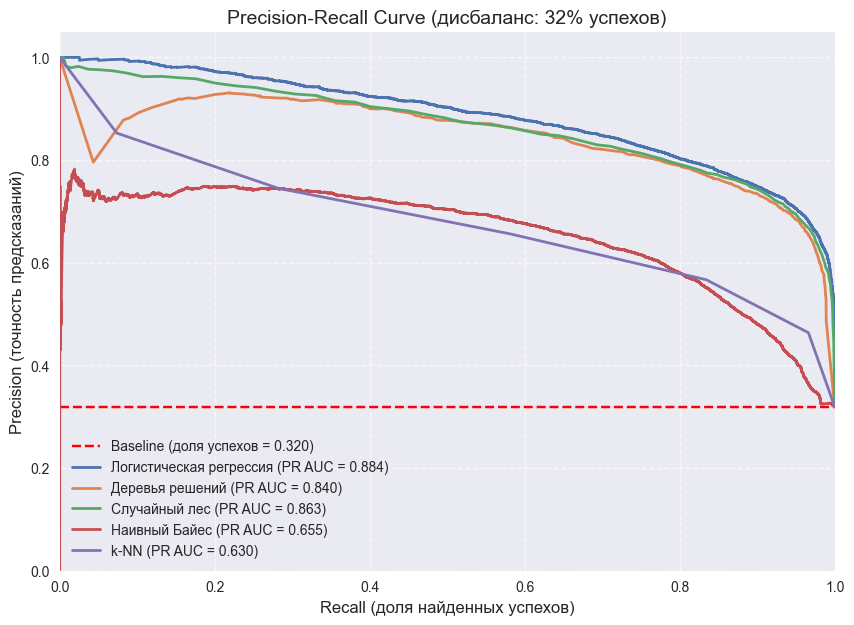

In [ ]:
plot_precision_recall_curve_multiple(results, y_test)

Для лучшей модели (логистическая регрессия)

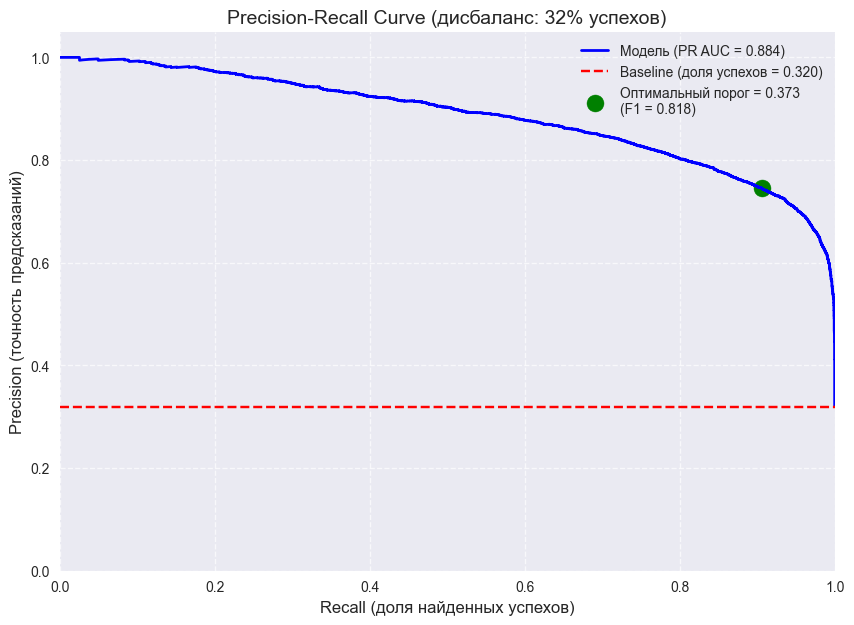

(0.3728501170724735, 0.8840396019134587)

In [ ]:
plot_precision_recall_curve(y_test, results['Логистическая регрессия']['probabilities'])

### Подбор гиперпараметров широкой сеткой (GridSearch) для лучшей модели (логрегрессия)

Создаём сетку для исследования

In [ ]:
# 1. Определяем сетку параметров
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Сила регуляризации
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "class_weight": [
        None,
        "balanced",
        {0: 0.67, 1: 0.33},  # Точный дисбаланс
        {0: 0.5, 1: 0.5},    # Выравнивание
        {0: 0.4, 1: 0.6}     # Усиление успехов
    ],
    "solver": ["liblinear", "saga"]
}

# 2. Фильтруем несовместимые комбинации
filtered_params = []
for C in param_grid["C"]:
    for penalty in param_grid["penalty"]:
        for class_weight in param_grid["class_weight"]:
            for solver in param_grid["solver"]:
                # Проверка совместимости
                if solver == "liblinear" and penalty not in ["l1", "l2"]:
                    continue
                if solver == "lbfgs" and penalty not in ["l2", "none"]:
                    continue
                if penalty == "elasticnet" and solver != "saga":
                    continue
                
                filtered_params.append({
                    "C": [C],
                    "penalty": [penalty],
                    "class_weight": [class_weight],
                    "solver": [solver],
                    "max_iter": [1000]
                })

# 3. GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=filtered_params,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # Поставил немного другую кросс-валидацию, чтобы сохранялся дисбаланс классов
    n_jobs=-1,
    verbose=2,
    refit=True
)

Запускаем подбор

In [ ]:
grid_search.fit(X_train_no_text, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


KeyboardInterrupt: 

Перебор делался отдельно в kaggle - лучшая модель ниже.

In [99]:
best_estimator = LogisticRegression(C=1, class_weight={0: 0.4, 1: 0.6}, max_iter=1000,
                   penalty='l1', random_state=42, solver='saga')
best_estimator.fit(X_train_no_text, y_train)
best_estimator

LogisticRegression(C=1, class_weight={0: 0.4, 1: 0.6}, max_iter=1000,
                   penalty='l1', random_state=42, solver='saga')

In [100]:
results = process_result(best_estimator, X_train_no_text, X_test_no_text)
print_results(results)

Тестовый f1-score: 0.818

Тестовый PR AUC: 0.884

Тестовый accuracy: 0.873

Средний f1-score на кросс-валидации: 0.818

Дисперсия f1-score на кросс-валидации: 0.003



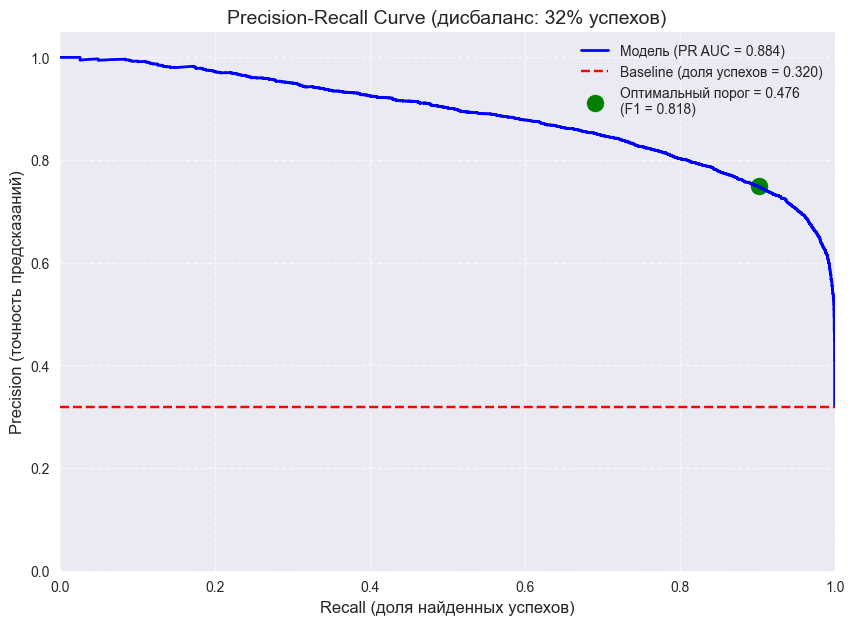

(0.47637097823853847, 0.8840180337364503)

In [101]:
plot_precision_recall_curve(y_test, results['probabilities'])

Как видно сильного улучшения модели нет - мы просто добились такого же f1-score как и при оптимальном пороге в прошлый раз. В связи с этим дополнительно не будет оптимизировать с помощью Optuna.

### Матрица ошибок

In [108]:
y_test.sum()

6912

Text(0.5, 31.222222222222214, 'Предсказанные значения')

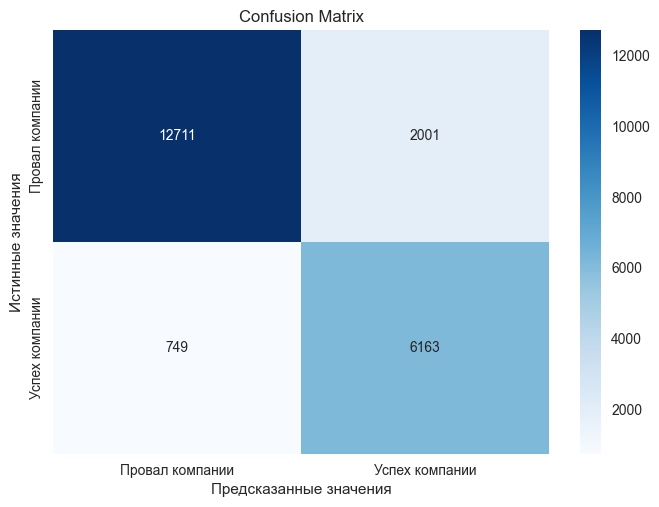

In [106]:
cm = confusion_matrix(y_test, results['predictions'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Провал компании', 'Успех компании'],
            yticklabels=['Провал компании', 'Успех компании'])
plt.title(f'Confusion Matrix')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')

In [113]:
print(f"Тестовый Precision: {precision_score(y_test, results['predictions']):.3f}")
print(f"Тестовый Recall: {recall_score(y_test, results['predictions']):.3f}")

Тестовый Precision: 0.755
Тестовый Recall: 0.892


Таким образом мы находим почти 90% успехо и где 75% наших предсказаний об успехе правдивы.

### Анализ важности признаков в полученной модели

In [86]:
coefficients = best_estimator.coef_[0]
intercept = best_estimator.intercept_[0]
feature_names = X_train_no_text.columns.tolist()

Таблица важности признаков

In [94]:
# Создаем DataFrame с коэффициентами
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients,
    "abs_coefficient": np.abs(coefficients)
})

# Сортируем по абсолютному значению (главный показатель важности)
feature_importance = feature_importance.sort_values("abs_coefficient", ascending=False)

# Добавляем интерпретацию направления
feature_importance["effect"] = np.where(
    feature_importance["coefficient"] > 0, 
    "Увеличивает шансы на успех", 
    "Уменьшает шансы на успех"
)

# Показываем топ-20
print(feature_importance[["feature", "coefficient", "effect"]].head(15))

                         feature  coefficient                      effect
2                  backers_count         7.58  Увеличивает шансы на успех
1          disable_communication        -7.34    Уменьшает шансы на успех
0                           goal        -3.14    Уменьшает шансы на успех
20                region_Oceania        -2.85    Уменьшает шансы на успех
23                currency_Other         2.78  Увеличивает шансы на успех
22                  currency_GBP        -0.91    Уменьшает шансы на успех
9               month_launched_7        -0.28    Уменьшает шансы на успех
26       campaign_duration_Short         0.28  Увеличивает шансы на успех
21                  currency_EUR        -0.25    Уменьшает шансы на успех
28  campaign_duration_Very_Short         0.22  Увеличивает шансы на успех
13             month_launched_11        -0.18    Уменьшает шансы на успех
24                  currency_USD        -0.13    Уменьшает шансы на успех
12             month_launched_10      

Визуализация

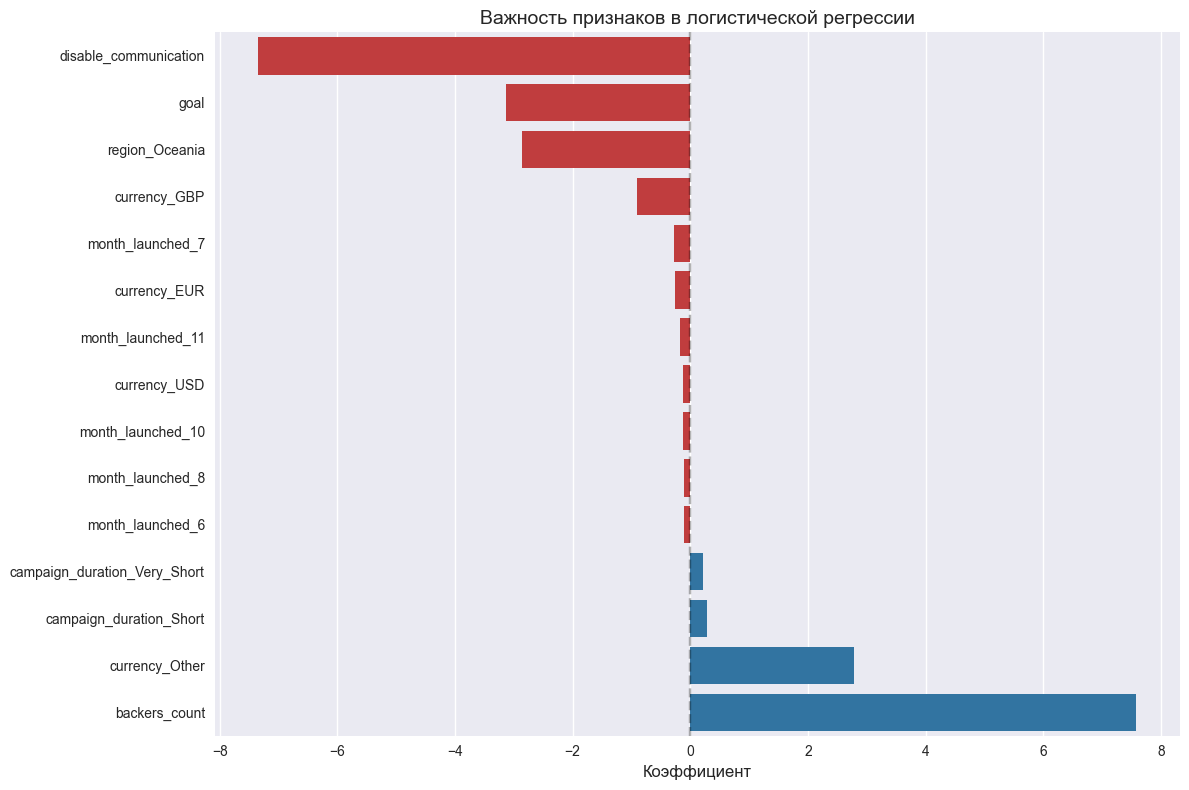

In [ ]:
top_features = feature_importance.head(15)

# Сортируем для наглядности
top_features = top_features.sort_values("coefficient")

plt.figure(figsize=(12, 8))
colors = ["#d62728" if coef < 0 else "#1f77b4" for coef in top_features["coefficient"]]
sns.barplot(
    x="coefficient", 
    y="feature", 
    data=top_features,
    palette=colors
)

plt.title("Важность признаков в логистической регрессии", fontsize=14)
plt.xlabel("Коэффициент", fontsize=12)
plt.ylabel("")
plt.axvline(x=0, color="k", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

**Выводы:**
- ожидаемо, количество бекеров сильный предсказатель успешности проекта, так как это добавляет ему веса и легитимности в глазах других людей

- отключение комментариев - сильный негативный сигнал. Возможно это как флаг, что тема проекта сомнительная или негативная и авторы зная это отключают комментарии. 

- чем выше целевая сумма сборов, тем сложнее её достигнуть, так что ожидаемо сильный отрицательный эффект

- любопытно, что проекты не из Европы и США чаще проваливаются, возможно потому что там платформа не так известна и нет такого покрытия.
- специфичным именно в Англии проектам видимо сложнее запуститься (отрицательный эффект у фунтов в качестве валюты)
- также видно, что специальная (не евро, доллар, канадский долар или фунты) валюта дают плюс к успеху компании. Возможно, выбирая специфичную валюту авторы сужают целевую аудиторию и тем самым увеличивают шансы на успех (так как проект показывается большему проценту заинтересованных людей)
- небольшой эффект, но короткие и сверхкороткие компании более часто приуспевают - это логично, так как суммы у них вероятно тоже очень небольшие.

**По дате запуска:**

Судя по всему конкретный день запуска не имеет решающей роли, однако если всё же отталкиваться от весов, то лучше НЕ запускать кампанию летом и осенью.

## Бустинги

### Baseline

Теперь попробуем применить бустинги

In [118]:
# Создаем модели с параметрами по умолчанию
models = {
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        force_col_wise=True
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        verbose=False
    )
}

In [119]:
results = {}
trained_models = {}

for name, model in models.items():
    print('***************************************')
    print(f"Обучение: {name}")
    print('---------------------------------------')

    start = time.time()
    
    model.fit(X_train_no_text, y_train)
    
    # Сохраняем предсказания и метрики
    results[name] = process_result(model, X_train_no_text, X_test_no_text)
    
    # Сохраняем обученную модель
    trained_models[name] = model

    print(f'Время на обучение: {(time.time() - start):.1f} сек')
    print()
    
    print_results(results[name])

***************************************
Обучение: XGBoost
---------------------------------------
Время на обучение: 1.5 сек

Тестовый f1-score: 0.807

Тестовый PR AUC: 0.882

Тестовый accuracy: 0.872

Средний f1-score на кросс-валидации: 0.807

Дисперсия f1-score на кросс-валидации: 0.002

***************************************
Обучение: LightGBM
---------------------------------------
Время на обучение: 1.6 сек

Тестовый f1-score: 0.815

Тестовый PR AUC: 0.891

Тестовый accuracy: 0.877

Средний f1-score на кросс-валидации: 0.814

Дисперсия f1-score на кросс-валидации: 0.003

***************************************
Обучение: CatBoost
---------------------------------------
Время на обучение: 62.9 сек

Тестовый f1-score: 0.815

Тестовый PR AUC: 0.887

Тестовый accuracy: 0.877

Средний f1-score на кросс-валидации: 0.812

Дисперсия f1-score на кросс-валидации: 0.002



In [99]:
# Создаем сравнительную таблицу результатов
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'f1-score test': [results[name]['f1_test'] for name in results.keys()],
    'PR AUC test': [results[name]['PR_AUC_test'] for name in results.keys()],
    'CV f1-score': [results[name]['f1_cv_mean'] for name in results.keys()],
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
})

# Сортируем по f1-score на тесте
results_df = results_df.sort_values('f1-score test', ascending=False).reset_index(drop=True)

print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("=" * 128)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\nЛучшая модель по f1-score test: {results_df.iloc[0]['Модель']} ({results_df.iloc[0]['f1-score test']:.3f})")

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
  Модель  f1-score test  PR AUC test  CV f1-score  Accuracy
LightGBM          0.815        0.891        0.814     0.877
CatBoost          0.815        0.887        0.812     0.877
 XGBoost          0.807        0.882        0.807     0.872

Лучшая модель по f1-score test: LightGBM (0.815)


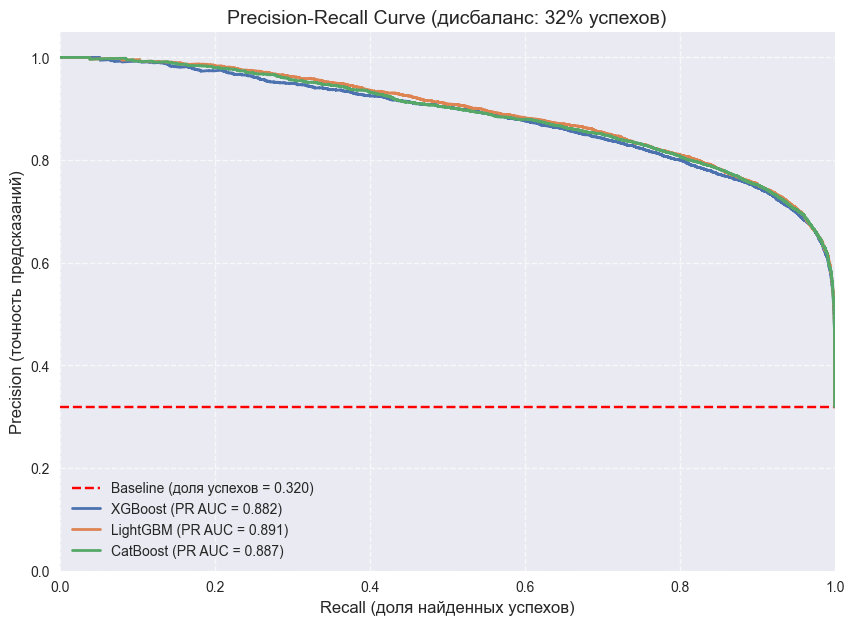

In [100]:
plot_precision_recall_curve_multiple(results, y_test)

Для лучшей модели (LightGBM)

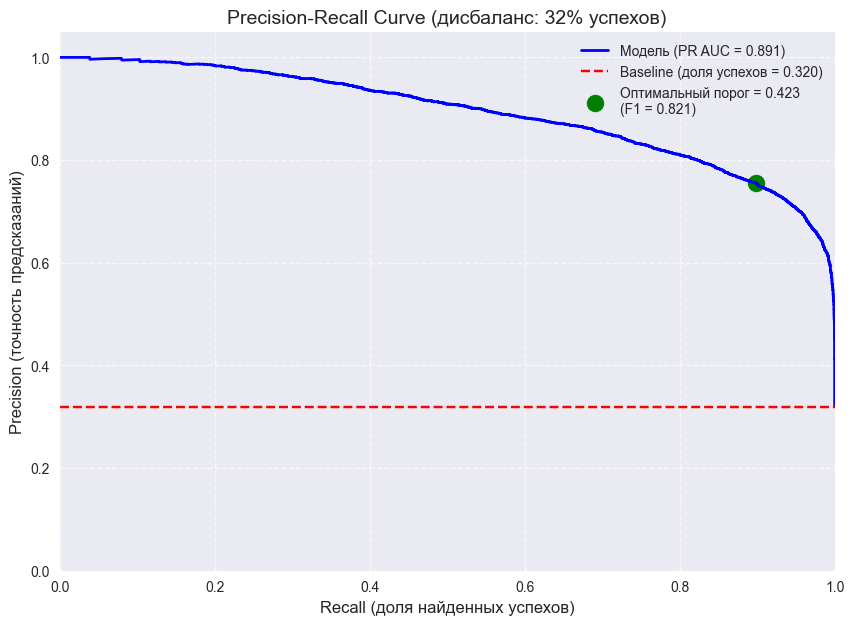

(0.42278736336267086, 0.890757698954909)

In [102]:
plot_precision_recall_curve(y_test, results['LightGBM']['probabilities'])

Таким образом небольшого улучшения мы достигли (при выборе оптимального порога). Попробуем пооптимизировать LightGBM (как самый быстрый и показывающий лучший результат).

### Оптимизация (с помощью Optuna для ускорения времени)

Оптимизировать будем в Kaggle

In [ ]:
def optimize_lightgbm(trial, X_train, y_train):
    """Оптимизация гиперпараметров LightGBM"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        "is_unbalance": True, # Для дисбаланса классов
        'random_state': 42,
        'verbosity': -1,
        'force_col_wise': True
    }
    
    model = lgb.LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
    return scores.mean()

In [ ]:
N_TRIALS = 5000
TIMEOUT = 7500

start_time = time.time()
    
# Создаем study
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

# Запускаем оптимизацию
study.optimize(
    lambda trial: optimize_lightgbm(trial, X_train_no_text, y_train),
    n_trials=N_TRIALS,
    timeout=TIMEOUT,
    show_progress_bar=True
)

optimization_time = time.time() - start_time

# Лучшие параметры
best_params = study.best_params
best_cv_score = study.best_value
print('-' * 100)

print(f"Завершено за {optimization_time:.1f} секунд")
print(f"Лучший CV f1-score: {best_cv_score:.4f}")
print(f"Проведено {len(study.trials)} попыток")
print(f"Топ-3 параметра по важности:")

# Показываем несколько ключевых параметров
key_params = ['learning_rate', 'max_depth', 'n_estimators', 'iterations', 'max_iter']
shown_params = 0
for param in key_params:
    if param in best_params and shown_params < 3:
        value = best_params[param]
        if isinstance(value, float):
            print(f"      • {param}: {value:.4f}")
        else:
            print(f"      • {param}: {value}")
        shown_params += 1

print('-' * 100)

optimized_model = lgb.LGBMClassifier(**best_params)

optimized_model.fit(X_train_no_text, y_train)

result = process_result(optimized_model, X_train_no_text, X_test_no_text)

print_results(result)

[I 2025-08-14 13:26:09,985] A new study created in memory with name: no-name-7c2150e7-2d72-4ff2-aaa1-3f798bfd09f4


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2025-08-14 13:26:11,748] Trial 0 finished with value: 0.8089957484759062 and parameters: {'n_estimators': 406, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'min_child_samples': 19, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.8089957484759062.
[I 2025-08-14 13:26:14,827] Trial 1 finished with value: 0.8157032110368582 and parameters: {'n_estimators': 621, 'max_depth': 8, 'learning_rate': 0.010725209743171996, 'feature_fraction': 0.9879639408647978, 'bagging_fraction': 0.9329770563201687, 'min_child_samples': 25, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 1 with value: 0.8157032110368582.
[I 2025-08-14 13:26:16,505] Trial 2 finished with value: 0.8137399251081435 and parameters: {'n_estimators': 339, 'max_depth': 7, 'learning_rate': 0.04345454109729477, 'feature_fraction': 0.7164916560792167, 'bagging_fract

KeyboardInterrupt: 

### Анализ лучшей модели

Параметры получены из оптимизации на Kaggle

In [72]:
best_params = {
    'n_estimators': 493, 
    'max_depth': 3, 
    'learning_rate': 0.10426716049785455, 
    'feature_fraction': 0.9947089259050176, 
    'bagging_fraction': 0.8148654260211938, 
    'min_child_samples': 9, 
    'reg_alpha': 5.5112247353974215, 
    'reg_lambda': 9.561295790261457,
    "is_unbalance": True, # Для дисбаланса классов
    'random_state': 42,
    'verbosity': -1,
    'force_col_wise': True}
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train_no_text, y_train)

results = process_result(best_model, X_train_no_text, X_test_no_text)

print_results(results)

Тестовый f1-score: 0.817

Тестовый PR AUC: 0.890

Тестовый accuracy: 0.867

Средний f1-score на кросс-валидации: 0.818

Дисперсия f1-score на кросс-валидации: 0.003



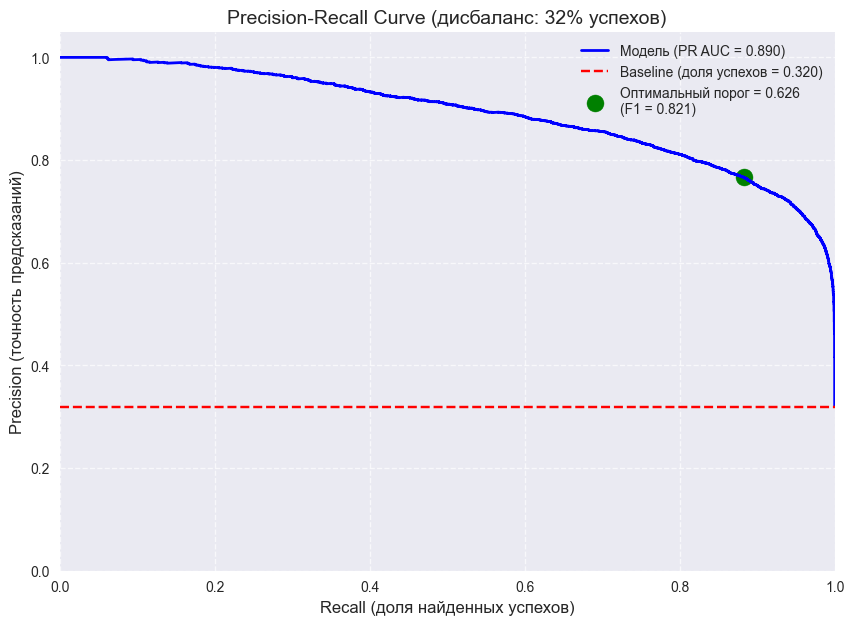

(0.6263076171205622, 0.8900504557001147)

In [73]:
plot_precision_recall_curve(y_test, results['probabilities'])

Видимого улучшения, к сожалению нет.

#### Матрица ошибок

Text(0.5, 31.222222222222214, 'Предсказанные значения')

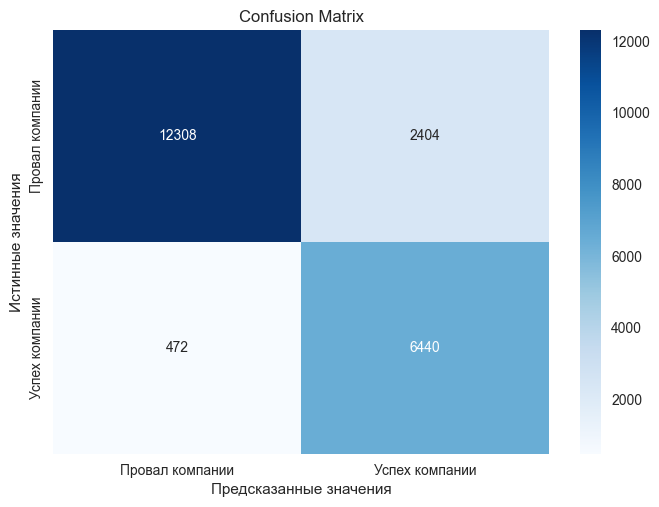

In [74]:
cm = confusion_matrix(y_test, results['predictions'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Провал компании', 'Успех компании'],
            yticklabels=['Провал компании', 'Успех компании'])
plt.title(f'Confusion Matrix')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')

In [75]:
print(f"Тестовый Precision: {precision_score(y_test, results['predictions']):.3f}")
print(f"Тестовый Recall: {recall_score(y_test, results['predictions']):.3f}")

Тестовый Precision: 0.728
Тестовый Recall: 0.932


Очень сильно повысили полноту по сравнению с логистической регрессией, но за счёт проседания точности.

#### Анализ важности признаков в полученной модели (SHAP)

Графиков много - для корректировки и косметических исправлений использовал Qwen.

**Создание Explainer и получение SHAP значений**

In [76]:
# 1. Создаем Explainer
# Для деревьев (LightGBM/XGBoost) используем TreeExplainer
explainer = shap.TreeExplainer(
    model=best_model,
    feature_names=X_test_no_text.columns.tolist()
)

# 2. Вычисляем SHAP значения
sample_size = len(X_test_no_text)
X_sample = X_test_no_text.iloc[:sample_size]

print(f"\nВычисляем SHAP значения для {sample_size} примеров...")
shap_values = explainer(X_sample)

# 3. Проверяем структуру SHAP значений
print("\nСтруктура SHAP значений:")
print(f"- Форма: {shap_values.shape}")
print(f"- Тип: {type(shap_values)}")

# Для бинарной классификации проверяем, нужно ли выбрать класс
if len(shap_values.shape) == 3:
    print("- Это бинарная классификация (2 класса)")
    print("- Берем значения для позитивного класса (успех = 1)")
    shap_values = shap_values[:, :, 1]
    print(f"  Новая форма: {shap_values.shape}")
else:
    print("- Это бинарная классификация с одним набором значений")

# 4. Проверяем базовое значение (expected_value)
expected_value =  1 / (1 + np.exp(-explainer.expected_value))
if isinstance(expected_value, np.ndarray) and len(expected_value) > 1:
    expected_value = 1 / (1 + np.exp(expected_value[1]))  # Берем для позитивного класса
print(f"\nБазовое значение (средняя вероятность успеха): {expected_value:.4f}")

# 5. Создаем объект Explanation для удобства
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value,
    data=X_sample.values,
    feature_names=X_sample.columns.tolist()
)


Вычисляем SHAP значения для 21624 примеров...

Структура SHAP значений:
- Форма: (21624, 34)
- Тип: <class 'shap._explanation.Explanation'>
- Это бинарная классификация с одним набором значений

Базовое значение (средняя вероятность успеха): 0.0822


**Глобальная важность признаков**

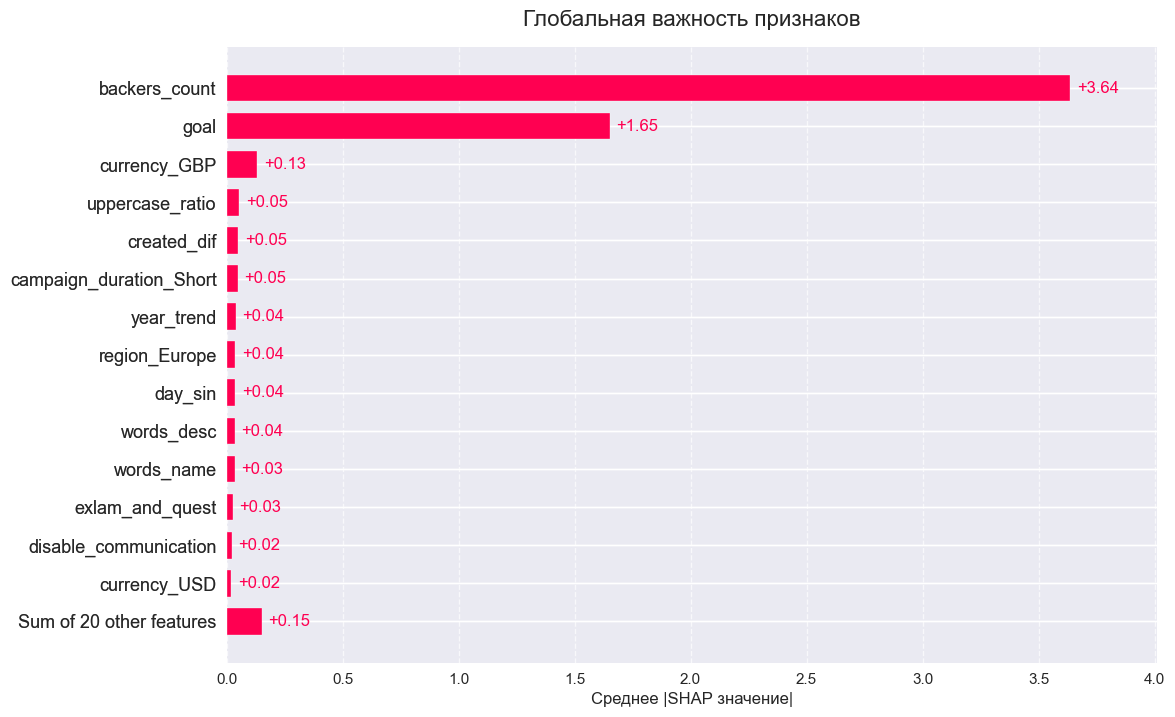


ТОП-5 ПРИЗНАКОВ ПО ГЛОБАЛЬНОЙ ВАЖНОСТИ
1. backers_count: 3.6363
2. goal: 1.6506
3. currency_GBP: 0.1313
4. uppercase_ratio: 0.0546
5. created_dif: 0.0508


In [77]:
plt.clf() 
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))

# Строим БАР-ПЛОТ с SHAP значениями (только один график!)
shap.plots.bar(shap_explanation, max_display=15, show=False, ax=ax)

# Настройка заголовка и осей
ax.set_title('Глобальная важность признаков', fontsize=16, pad=15)
ax.set_xlabel('Среднее |SHAP значение|', fontsize=12)
ax.set_ylabel('')

# Улучшаем читаемость
ax.grid(axis='x', linestyle='--', alpha=0.7)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.show()

# Текстовый вывод топ-5 признаков (отдельно от графика)
print("\n" + "="*50)
print("ТОП-5 ПРИЗНАКОВ ПО ГЛОБАЛЬНОЙ ВАЖНОСТИ")
print("="*50)

# Считаем среднее |SHAP значение| для каждого признака
feature_importance = np.abs(shap_explanation.values).mean(axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

for i, idx in enumerate(sorted_idx[:5]):
    feature = shap_explanation.feature_names[idx]
    impact = feature_importance[idx]
    print(f"{i+1}. {feature}: {impact:.4f}")

Как видно, ключевыми остаются количество бекеров и сумма сборов. Любопытно ещё сильное влияние фунтов в качестве валюты. Будем смотреть как именно они влияют.

В целом сильно структура важности по сравнению с логистической регрессией не изменилась.

**Waterfall Plot — объяснение конкретного предсказания**

Анализируем успешный проект (индекс 4354)
Предсказанная вероятность успеха: 99.99%


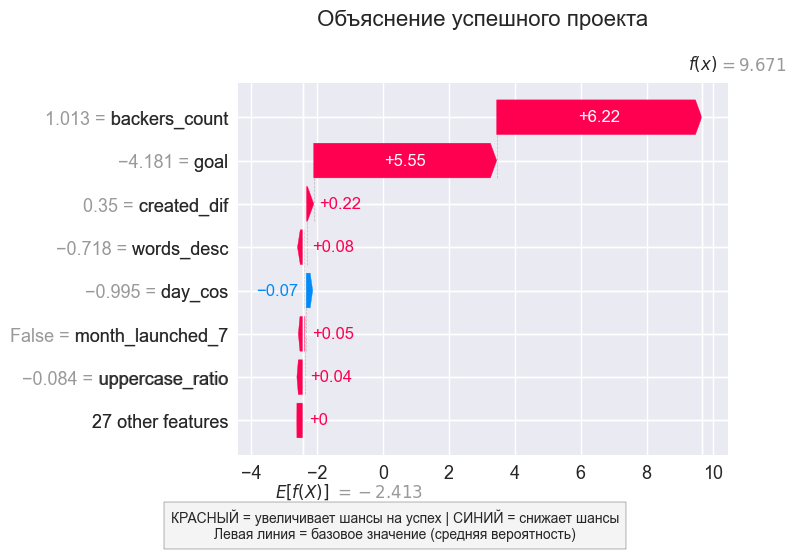


ИНТЕРПРЕТАЦИЯ УСПЕШНОГО ПРОЕКТА
Топ-3 фактора, увеличивающих шансы:
  1. backers_count = 1.01: +6.217 к лог-шансам
  2. goal = -4.18: +5.546 к лог-шансам
  3. created_dif = 0.35: +0.217 к лог-шансам

Топ-3 фактора, снижающих шансы:
  1. day_cos = -0.99: -0.075 к лог-шансам
  2. year_trend = 6.00: -0.013 к лог-шансам
  3. campaign_duration_Short = 0.00: -0.013 к лог-шансам

💡 Итог: базовое значение = -2.413
   Суммарное влияние признаков = 12.084
   Финальное значение = 9.671
   Вероятность успеха = 99.99%


In [79]:
# Находим ТИПИЧНЫЙ УСПЕШНЫЙ проект
success_idx = np.argmax(shap_explanation.base_values + shap_explanation.values.sum(axis=1))
success_prob = 1 / (1 + np.exp(-(shap_explanation.base_values[success_idx] + shap_explanation.values[success_idx].sum())))
print(f"Анализируем успешный проект (индекс {success_idx})")
print(f"Предсказанная вероятность успеха: {success_prob:.2%}")

# СОЗДАЕМ ГРАФИК
shap.plots.waterfall(shap_explanation[success_idx], max_display=8, show=False)
ax = plt.gca()  # Получаем текущую ось

# Добавляем заголовок
ax.set_title('Объяснение успешного проекта', fontsize=16, pad=20)

# Добавляем пояснение под графиком
plt.figtext(0.5, 0.01, 
            "КРАСНЫЙ = увеличивает шансы на успех | СИНИЙ = снижает шансы\n"
            "Левая линия = базовое значение (средняя вероятность)",
            ha="center", 
            fontsize=10, 
            bbox={"facecolor":"#f0f0f0", "alpha":0.7, "pad":5})

# 4. НАСТРАИВАЕМ ВНЕШНИЙ ВИД
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Оставляем место для пояснения внизу
plt.show()

# 5. Текстовая интерпретация
print("\n" + "="*50)
print("ИНТЕРПРЕТАЦИЯ УСПЕШНОГО ПРОЕКТА")
print("="*50)

# Получаем значения
base_value = shap_explanation.base_values[success_idx]
shap_values = shap_explanation.values[success_idx]
data = shap_explanation.data[success_idx]
feature_names = shap_explanation.feature_names

# Топ-3 позитивных и негативных признаков
sorted_indices = np.argsort(np.abs(shap_values))[::-1]
top_positive = [i for i in sorted_indices if shap_values[i] > 0][:3]
top_negative = [i for i in sorted_indices if shap_values[i] < 0][:3]

print("Топ-3 фактора, увеличивающих шансы:")
for i, idx in enumerate(top_positive):
    print(f"  {i+1}. {feature_names[idx]} = {data[idx]:.2f}: +{shap_values[idx]:.3f} к лог-шансам")

print("\nТоп-3 фактора, снижающих шансы:")
for i, idx in enumerate(top_negative):
    print(f"  {i+1}. {feature_names[idx]} = {data[idx]:.2f}: {shap_values[idx]:.3f} к лог-шансам")

print(f"\n💡 Итог: базовое значение = {base_value:.3f}")
print(f"   Суммарное влияние признаков = {shap_values.sum():.3f}")
print(f"   Финальное значение = {base_value + shap_values.sum():.3f}")
print(f"   Вероятность успеха = {success_prob:.2%}")

Как видно большая часть успеха определяется количеством бекеров - это очень сильный предсказатель.

Анализируем провальный проект (индекс 19830)
Предсказанная вероятность успеха: 0.00%


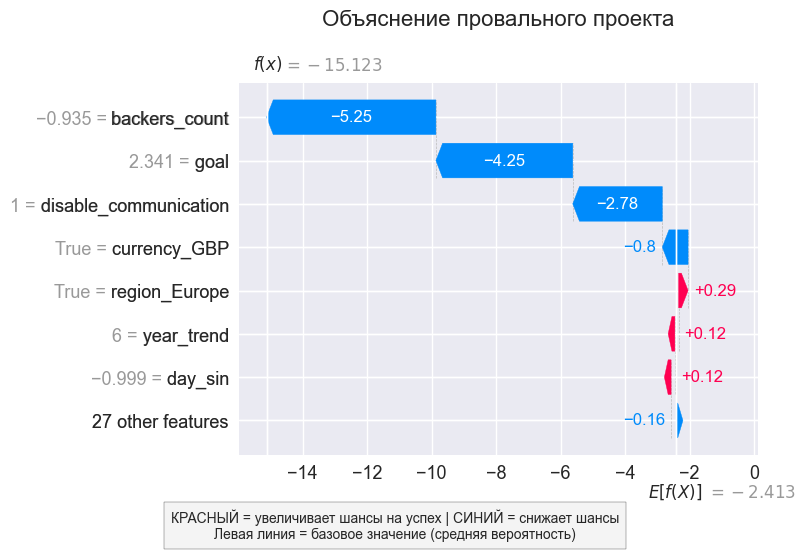


ИНТЕРПРЕТАЦИЯ ПРОВАЛЬНОГО ПРОЕКТА
Топ-3 фактора, увеличивающих шансы:
  1. region_Europe = 1.00: +0.293 к лог-шансам
  2. year_trend = 6.00: +0.118 к лог-шансам
  3. day_sin = -1.00: +0.117 к лог-шансам

Топ-3 фактора, снижающих шансы:
  1. backers_count = -0.94: -5.254 к лог-шансам
  2. goal = 2.34: -4.245 к лог-шансам
  3. disable_communication = 1.00: -2.778 к лог-шансам

💡 Итог: базовое значение = -2.413
   Суммарное влияние признаков = -12.710
   Финальное значение = -15.123
   Вероятность успеха = 0.00%


In [80]:
# Находим ТИПИЧНЫЙ ПРОВАЛЬНЫЙ проект
success_idx = np.argmin(shap_explanation.base_values + shap_explanation.values.sum(axis=1))
success_prob = 1 / (1 + np.exp(-(shap_explanation.base_values[success_idx] + shap_explanation.values[success_idx].sum())))
print(f"Анализируем провальный проект (индекс {success_idx})")
print(f"Предсказанная вероятность успеха: {success_prob:.2%}")

# СОЗДАЕМ ГРАФИК
shap.plots.waterfall(shap_explanation[success_idx], max_display=8, show=False)
ax = plt.gca()  # Получаем текущую ось

# Добавляем заголовок
ax.set_title('Объяснение провального проекта', fontsize=16, pad=20)

# Добавляем пояснение под графиком
plt.figtext(0.5, 0.01, 
            "КРАСНЫЙ = увеличивает шансы на успех | СИНИЙ = снижает шансы\n"
            "Левая линия = базовое значение (средняя вероятность)",
            ha="center", 
            fontsize=10, 
            bbox={"facecolor":"#f0f0f0", "alpha":0.7, "pad":5})

# 4. НАСТРАИВАЕМ ВНЕШНИЙ ВИД
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Оставляем место для пояснения внизу
plt.show()

# 5. Текстовая интерпретация
print("\n" + "="*50)
print("ИНТЕРПРЕТАЦИЯ ПРОВАЛЬНОГО ПРОЕКТА")
print("="*50)

# Получаем значения
base_value = shap_explanation.base_values[success_idx]
shap_values = shap_explanation.values[success_idx]
data = shap_explanation.data[success_idx]
feature_names = shap_explanation.feature_names

# Топ-3 позитивных и негативных признаков
sorted_indices = np.argsort(np.abs(shap_values))[::-1]
top_positive = [i for i in sorted_indices if shap_values[i] > 0][:3]
top_negative = [i for i in sorted_indices if shap_values[i] < 0][:3]

print("Топ-3 фактора, увеличивающих шансы:")
for i, idx in enumerate(top_positive):
    print(f"  {i+1}. {feature_names[idx]} = {data[idx]:.2f}: +{shap_values[idx]:.3f} к лог-шансам")

print("\nТоп-3 фактора, снижающих шансы:")
for i, idx in enumerate(top_negative):
    print(f"  {i+1}. {feature_names[idx]} = {data[idx]:.2f}: {shap_values[idx]:.3f} к лог-шансам")

print(f"\n💡 Итог: базовое значение = {base_value:.3f}")
print(f"   Суммарное влияние признаков = {shap_values.sum():.3f}")
print(f"   Финальное значение = {base_value + shap_values.sum():.3f}")
print(f"   Вероятность успеха = {success_prob:.2%}")

Здесь наоборот видно, что отсутствие бекеров, слишком высокая цель и отключённые комментарии считай поставили сразу крест на проекте. Любопытно, что как и в логистической регрессии фунты в качестве валюты относительно сильно понижают шансы.

**Зависимость SHAP от конкретного признака**

Для простоты возьмём самый важный признак

Анализируем зависимость для: 'backers_count' (самый важный признак)


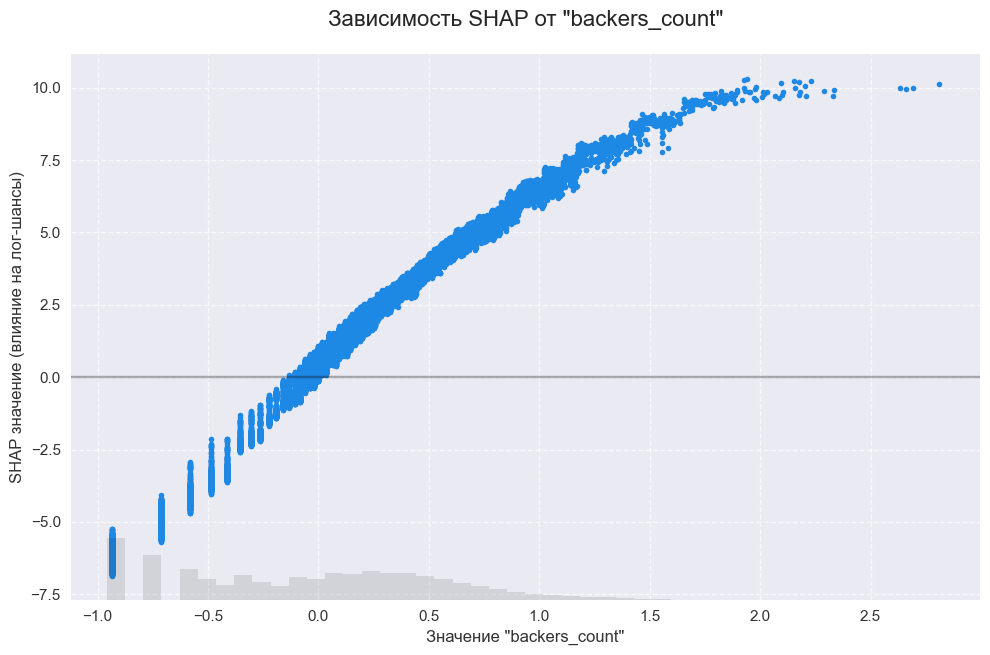


ИНТЕРПРЕТАЦИЯ ЗАВИСИМОСТИ ДЛЯ 'BACKERS_COUNT'
→ Анализируем 21624 примеров
→ Признак числовой
→ Линейная положительная зависимость: чем выше значение, тем выше шансы на успех

💡 Для максимальных шансов на успех: backers_count должен быть в диапазоне 2.43-2.81


In [81]:
# 1. Определяем САМЫЙ ВАЖНЫЙ признак (по среднему |SHAP|)
feature_importance = np.abs(shap_explanation.values).mean(axis=0)
most_important_idx = np.argmax(feature_importance)
most_important_feature = shap_explanation.feature_names[most_important_idx]
print(f"Анализируем зависимость для: '{most_important_feature}' (самый важный признак)")

# 2. Создаем ЧИСТЫЙ график с явным указанием оси
plt.clf()
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 7))

# 3. Строим график зависимости
shap.plots.scatter(
    shap_explanation[:, most_important_feature],
    ax=ax,
    show=False
)

# 4. Улучшаем оформление
ax.set_title(f'Зависимость SHAP от "{most_important_feature}"', fontsize=16, pad=20)
ax.set_xlabel(f'Значение "{most_important_feature}"', fontsize=12)
ax.set_ylabel('SHAP значение (влияние на лог-шансы)', fontsize=12)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.grid(linestyle='--', alpha=0.7)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# 5. Настраиваем расположение
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# 6. Текстовая интерпретация
print("\n" + "="*50)
print(f"ИНТЕРПРЕТАЦИЯ ЗАВИСИМОСТИ ДЛЯ '{most_important_feature.upper()}'")
print("="*50)

# ПРАВИЛЬНОЕ ПОЛУЧЕНИЕ ДАННЫХ (как же долго я с этим ебался)
feature_idx = shap_explanation.feature_names.index(most_important_feature)
shap_values = np.array(shap_explanation.values[:, feature_idx]).flatten()
feature_values = np.array(shap_explanation.data[:, feature_idx]).flatten()

print(f"→ Анализируем {len(shap_values)} примеров")

# Проверяем, являются ли данные числовыми
def is_numeric_array(arr):
    """Проверяет, содержит ли массив числовые значения"""
    try:
        # Пытаемся преобразовать в float
        np.array(arr, dtype=float)
        return True
    except:
        return False

is_numeric = is_numeric_array(feature_values)

if is_numeric:
    print("→ Признак числовой")
    
    # Преобразуем в числовой массив для анализа
    numeric_values = np.array(feature_values, dtype=float)
    
    # Удаляем NaN значения ТОЛЬКО для числовых данных
    mask = ~np.isnan(shap_values) & ~np.isnan(numeric_values)
    valid_shap = shap_values[mask]
    valid_features = numeric_values[mask]
    
    # Вычисляем корреляцию
    if len(valid_shap) > 1:
        correlation = np.corrcoef(valid_features, valid_shap)[0, 1]
        
        # Определяем тип зависимости
        if correlation > 0.7:
            print("→ Линейная положительная зависимость: чем выше значение, тем выше шансы на успех")
        elif correlation < -0.7:
            print("→ Линейная отрицательная зависимость: чем выше значение, тем ниже шансы на успех")
        else:
            print("→ Нелинейная зависимость: оптимальное значение где-то в середине диапазона")
        
        # Пытаемся найти оптимальную точку
        try:
            import pandas as pd
            df = pd.DataFrame({
                'feature': valid_features,
                'shap': valid_shap
            })
            
            # Бинируем данные
            df['bin'] = pd.cut(df['feature'], bins=min(10, len(df)//10))
            bin_means = df.groupby('bin')['shap'].mean()
            
            # Находим бин с максимальным SHAP
            best_bin = bin_means.idxmax()
            best_value = f"{best_bin.left:.2f}-{best_bin.right:.2f}"
            
            print(f"\n💡 Для максимальных шансов на успех: {most_important_feature} должен быть в диапазоне {best_value}")
        except Exception as e:
            print(f"\n⚠️ Ошибка при поиске оптимального диапазона: {str(e)}")
    else:
        print("⚠️ Недостаточно данных для анализа корреляции")
else:
    print("→ Признак категориальный")
    
    # Анализируем категориальный признак
    unique_values = np.unique(feature_values)
    print(f"→ Признак имеет {len(unique_values)} уникальных значений")
    
    # Считаем среднее SHAP для каждого значения
    shap_by_value = {}
    for val in unique_values:
        mask = (feature_values == val)
        shap_by_value[val] = np.mean(shap_values[mask])
    
    # Сортируем по SHAP значению
    sorted_values = sorted(shap_by_value.items(), key=lambda x: x[1], reverse=True)
    
    print("\nСреднее SHAP значение по категориям:")
    for val, shap_val in sorted_values:
        print(f"  {val}: {shap_val:.3f}")


Проанализируем для goal

Анализируем зависимость для: 'goal'


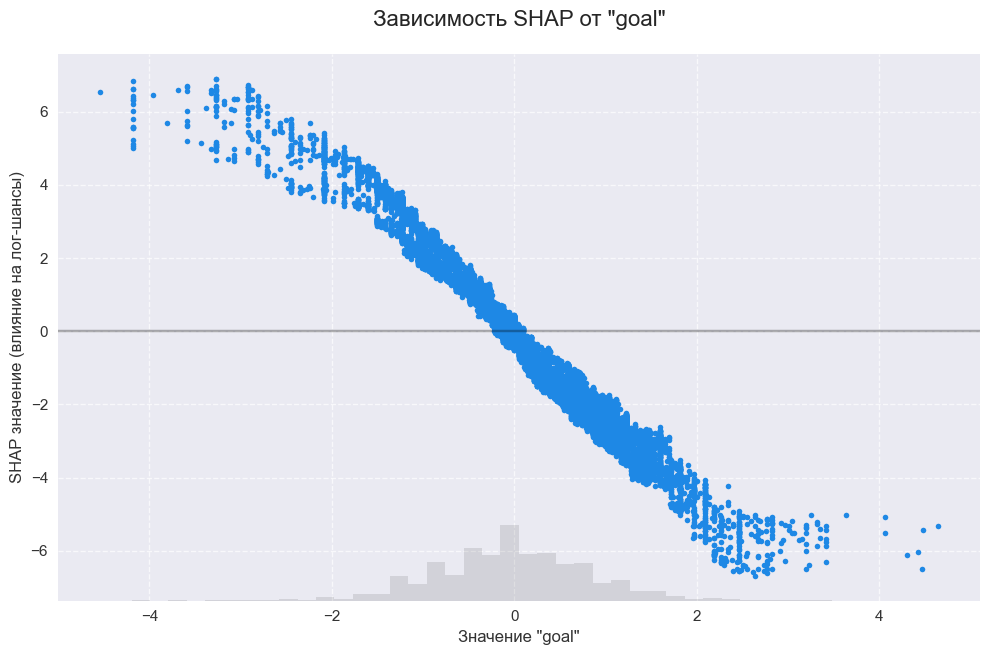


ИНТЕРПРЕТАЦИЯ ЗАВИСИМОСТИ ДЛЯ 'GOAL'
→ Анализируем 21624 примеров
→ Признак числовой
→ Линейная отрицательная зависимость: чем выше значение, тем ниже шансы на успех

💡 Для максимальных шансов на успех: goal должен быть в диапазоне -4.55--3.63


In [82]:
# 1. Определяем goal
most_important_idx = feature_names.index('goal')
most_important_feature = shap_explanation.feature_names[most_important_idx]
print(f"Анализируем зависимость для: '{most_important_feature}'")

# 2. Создаем ЧИСТЫЙ график с явным указанием оси
plt.clf()
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 7))

# 3. Строим график зависимости
shap.plots.scatter(
    shap_explanation[:, most_important_feature],
    ax=ax,
    show=False
)

# 4. Улучшаем оформление
ax.set_title(f'Зависимость SHAP от "{most_important_feature}"', fontsize=16, pad=20)
ax.set_xlabel(f'Значение "{most_important_feature}"', fontsize=12)
ax.set_ylabel('SHAP значение (влияние на лог-шансы)', fontsize=12)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.grid(linestyle='--', alpha=0.7)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# 5. Настраиваем расположение
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# 6. Текстовая интерпретация
print("\n" + "="*50)
print(f"ИНТЕРПРЕТАЦИЯ ЗАВИСИМОСТИ ДЛЯ '{most_important_feature.upper()}'")
print("="*50)

# ПРАВИЛЬНОЕ ПОЛУЧЕНИЕ ДАННЫХ (как же долго я с этим ебался)
feature_idx = shap_explanation.feature_names.index(most_important_feature)
shap_values = np.array(shap_explanation.values[:, feature_idx]).flatten()
feature_values = np.array(shap_explanation.data[:, feature_idx]).flatten()

print(f"→ Анализируем {len(shap_values)} примеров")

# Проверяем, являются ли данные числовыми
def is_numeric_array(arr):
    """Проверяет, содержит ли массив числовые значения"""
    try:
        # Пытаемся преобразовать в float
        np.array(arr, dtype=float)
        return True
    except:
        return False

is_numeric = is_numeric_array(feature_values)

if is_numeric:
    print("→ Признак числовой")
    
    # Преобразуем в числовой массив для анализа
    numeric_values = np.array(feature_values, dtype=float)
    
    # Удаляем NaN значения ТОЛЬКО для числовых данных
    mask = ~np.isnan(shap_values) & ~np.isnan(numeric_values)
    valid_shap = shap_values[mask]
    valid_features = numeric_values[mask]
    
    # Вычисляем корреляцию
    if len(valid_shap) > 1:
        correlation = np.corrcoef(valid_features, valid_shap)[0, 1]
        
        # Определяем тип зависимости
        if correlation > 0.7:
            print("→ Линейная положительная зависимость: чем выше значение, тем выше шансы на успех")
        elif correlation < -0.7:
            print("→ Линейная отрицательная зависимость: чем выше значение, тем ниже шансы на успех")
        else:
            print("→ Нелинейная зависимость: оптимальное значение где-то в середине диапазона")
        
        # Пытаемся найти оптимальную точку
        try:
            import pandas as pd
            df = pd.DataFrame({
                'feature': valid_features,
                'shap': valid_shap
            })
            
            # Бинируем данные
            df['bin'] = pd.cut(df['feature'], bins=min(10, len(df)//10))
            bin_means = df.groupby('bin')['shap'].mean()
            
            # Находим бин с максимальным SHAP
            best_bin = bin_means.idxmax()
            best_value = f"{best_bin.left:.2f}-{best_bin.right:.2f}"
            
            print(f"\n💡 Для максимальных шансов на успех: {most_important_feature} должен быть в диапазоне {best_value}")
        except Exception as e:
            print(f"\n⚠️ Ошибка при поиске оптимального диапазона: {str(e)}")
    else:
        print("⚠️ Недостаточно данных для анализа корреляции")
else:
    print("→ Признак категориальный")
    
    # Анализируем категориальный признак
    unique_values = np.unique(feature_values)
    print(f"→ Признак имеет {len(unique_values)} уникальных значений")
    
    # Считаем среднее SHAP для каждого значения
    shap_by_value = {}
    for val in unique_values:
        mask = (feature_values == val)
        shap_by_value[val] = np.mean(shap_values[mask])
    
    # Сортируем по SHAP значению
    sorted_values = sorted(shap_by_value.items(), key=lambda x: x[1], reverse=True)
    
    print("\nСреднее SHAP значение по категориям:")
    for val, shap_val in sorted_values:
        print(f"  {val}: {shap_val:.3f}")


Наконец посмотрим на какой-то менее важный признак - например длину описания.

Анализируем зависимость для: 'words_desc'


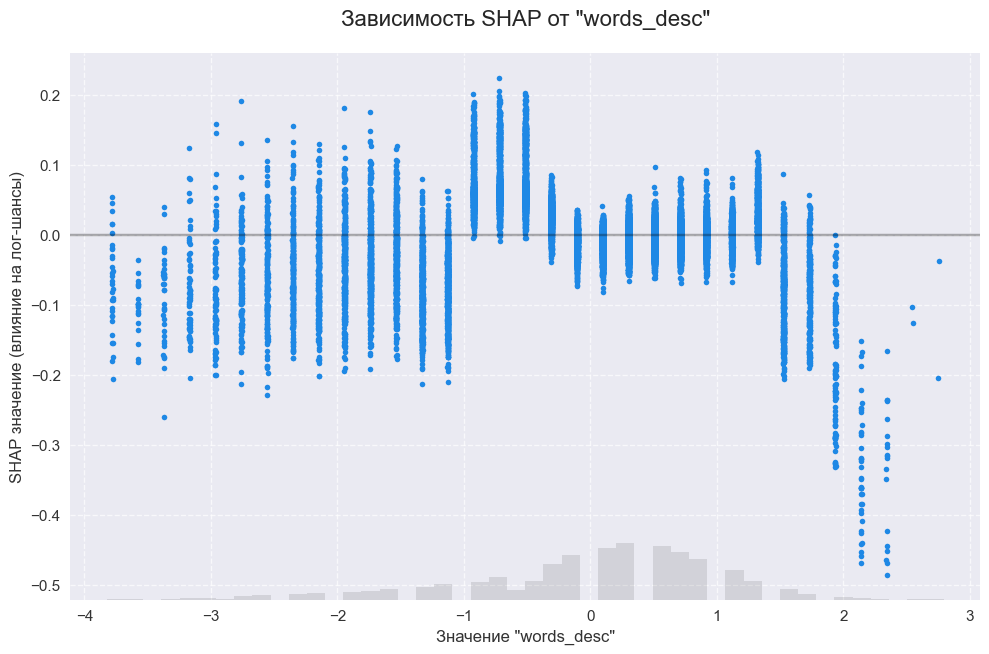


ИНТЕРПРЕТАЦИЯ ЗАВИСИМОСТИ ДЛЯ 'WORDS_DESC'
→ Анализируем 21624 примеров
→ Признак числовой
→ Нелинейная зависимость: оптимальное значение где-то в середине диапазона

💡 Для максимальных шансов на успех: words_desc должен быть в диапазоне -1.17--0.51


In [83]:
# 1. Определяем currency_GBP
most_important_idx = feature_names.index('words_desc')
most_important_feature = shap_explanation.feature_names[most_important_idx]
print(f"Анализируем зависимость для: '{most_important_feature}'")

# 2. Создаем ЧИСТЫЙ график с явным указанием оси
plt.clf()
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 7))

# 3. Строим график зависимости
shap.plots.scatter(
    shap_explanation[:, most_important_feature],
    ax=ax,
    show=False
)

# 4. Улучшаем оформление
ax.set_title(f'Зависимость SHAP от "{most_important_feature}"', fontsize=16, pad=20)
ax.set_xlabel(f'Значение "{most_important_feature}"', fontsize=12)
ax.set_ylabel('SHAP значение (влияние на лог-шансы)', fontsize=12)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.grid(linestyle='--', alpha=0.7)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# 5. Настраиваем расположение
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# 6. Текстовая интерпретация
print("\n" + "="*50)
print(f"ИНТЕРПРЕТАЦИЯ ЗАВИСИМОСТИ ДЛЯ '{most_important_feature.upper()}'")
print("="*50)

# ПРАВИЛЬНОЕ ПОЛУЧЕНИЕ ДАННЫХ (как же долго я с этим ебался)
feature_idx = shap_explanation.feature_names.index(most_important_feature)
shap_values = np.array(shap_explanation.values[:, feature_idx]).flatten()
feature_values = np.array(shap_explanation.data[:, feature_idx]).flatten()

print(f"→ Анализируем {len(shap_values)} примеров")

# Проверяем, являются ли данные числовыми
def is_numeric_array(arr):
    """Проверяет, содержит ли массив числовые значения"""
    try:
        # Пытаемся преобразовать в float
        np.array(arr, dtype=float)
        return True
    except:
        return False

is_numeric = is_numeric_array(feature_values)

if is_numeric:
    print("→ Признак числовой")
    
    # Преобразуем в числовой массив для анализа
    numeric_values = np.array(feature_values, dtype=float)
    
    # Удаляем NaN значения ТОЛЬКО для числовых данных
    mask = ~np.isnan(shap_values) & ~np.isnan(numeric_values)
    valid_shap = shap_values[mask]
    valid_features = numeric_values[mask]
    
    # Вычисляем корреляцию
    if len(valid_shap) > 1:
        correlation = np.corrcoef(valid_features, valid_shap)[0, 1]
        
        # Определяем тип зависимости
        if correlation > 0.7:
            print("→ Линейная положительная зависимость: чем выше значение, тем выше шансы на успех")
        elif correlation < -0.7:
            print("→ Линейная отрицательная зависимость: чем выше значение, тем ниже шансы на успех")
        else:
            print("→ Нелинейная зависимость: оптимальное значение где-то в середине диапазона")
        
        # Пытаемся найти оптимальную точку
        try:
            import pandas as pd
            df = pd.DataFrame({
                'feature': valid_features,
                'shap': valid_shap
            })
            
            # Бинируем данные
            df['bin'] = pd.cut(df['feature'], bins=min(10, len(df)//10))
            bin_means = df.groupby('bin')['shap'].mean()
            
            # Находим бин с максимальным SHAP
            best_bin = bin_means.idxmax()
            best_value = f"{best_bin.left:.2f}-{best_bin.right:.2f}"
            
            print(f"\n💡 Для максимальных шансов на успех: {most_important_feature} должен быть в диапазоне {best_value}")
        except Exception as e:
            print(f"\n⚠️ Ошибка при поиске оптимального диапазона: {str(e)}")
    else:
        print("⚠️ Недостаточно данных для анализа корреляции")
else:
    print("→ Признак категориальный")
    
    # Анализируем категориальный признак
    unique_values = np.unique(feature_values)
    print(f"→ Признак имеет {len(unique_values)} уникальных значений")
    
    # Считаем среднее SHAP для каждого значения
    shap_by_value = {}
    for val in unique_values:
        mask = (feature_values == val)
        shap_by_value[val] = np.mean(shap_values[mask])
    
    # Сортируем по SHAP значению
    sorted_values = sorted(shap_by_value.items(), key=lambda x: x[1], reverse=True)
    
    print("\nСреднее SHAP значение по категориям:")
    for val, shap_val in sorted_values:
        print(f"  {val}: {shap_val:.3f}")


Видно, что супер короткое или длинное описание - это плохо (ожидаемо). Оптимально где-то посередине.

## Stacking и blending (неоптимизированных моделей)

### Stacking

Будем собирать из простых неоптимизированных моделей (так как оптимизировать каждую очень долго) и тех, что мы уже оптимизировали. Может быть исправлено в будущем.

In [78]:
best_params = {
    'n_estimators': 493, 
    'max_depth': 3, 
    'learning_rate': 0.10426716049785455, 
    'feature_fraction': 0.9947089259050176, 
    'bagging_fraction': 0.8148654260211938, 
    'min_child_samples': 9, 
    'reg_alpha': 5.5112247353974215, 
    'reg_lambda': 9.561295790261457,
    "is_unbalance": True, # Для дисбаланса классов
    'random_state': 42,
    'verbosity': -1,
    'force_col_wise': True}

selected_models = {
    # Tree-based модели
    'RandomForest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42
    ),
    'DecisionTree': DecisionTreeClassifier(
        max_depth=8, random_state=42
    ),
    
    # Gradient Boosting модели
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1, 
        random_state=42, eval_metric='logloss', verbosity=0
    ),
    'LightGBM': lgb.LGBMClassifier(**best_params),
    'CatBoost': CatBoostClassifier(
        iterations=100, depth=6, learning_rate=0.1,
        random_state=42, verbose=False
    ),
    
    # Linear модели
    'LogisticRegression': LogisticRegression(C=1, class_weight={0: 0.4, 1: 0.6}, max_iter=1000,
                   penalty='l1', random_state=42, solver='saga')
}

Все модели из списка уже тестировались на адекватность, так что отдельно не будем прогонять их.

#### Функция для создания cross-validation stacking

In [79]:
def create_cv_stacking_features(models, X_train, y_train, cv_folds=5):
    
    n_samples = X_train.shape[0]
    n_models = len(models)
    
    # Инициализируем матрицу meta-features
    meta_features = np.zeros((n_samples, n_models))
    
    # Создаем cross-validation объект
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for i, (model_name, model) in enumerate(models.items()):
        print(f"   Обработка модели {i+1}/{n_models}: {model_name}")
        
        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
            # Разделяем данные для текущего фолда
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            
            # Клонируем модель для избежания изменения оригинала
            model_clone = type(model)(**model.get_params())
            model_clone.fit(X_fold_train, y_fold_train)
            pred_proba = model_clone.predict_proba(X_fold_val)[:, 1]
            
            # Сохраняем предсказания для validation индексов
            meta_features[val_idx, i] = pred_proba
    
    return meta_features

#### Создаём мета фичи

In [80]:
start_time = time.time()
meta_features_train = create_cv_stacking_features(selected_models, X_train_no_text, y_train, cv_folds=5)
stacking_time = time.time() - start_time

print(f"\n Время создания meta-features: {stacking_time:.1f} секунд")
print(f" Форма meta-features: {meta_features_train.shape}")

meta_df = pd.DataFrame(meta_features_train, columns=list(selected_models.keys()))
# Корреляция meta-features
meta_corr = meta_df.corr()
print(f"\n Корреляция между meta-features:")
print(f"• Средняя корреляция: {meta_corr.values[np.triu_indices_from(meta_corr.values, 1)].mean():.4f}")
print(f"• Минимальная корреляция: {meta_corr.values[np.triu_indices_from(meta_corr.values, 1)].min():.4f}")
print(f"• Максимальная корреляция: {meta_corr.values[np.triu_indices_from(meta_corr.values, 1)].max():.4f}")

   Обработка модели 1/6: RandomForest
   Обработка модели 2/6: DecisionTree
   Обработка модели 3/6: XGBoost
   Обработка модели 4/6: LightGBM
   Обработка модели 5/6: CatBoost
   Обработка модели 6/6: LogisticRegression

 Время создания meta-features: 91.9 секунд
 Форма meta-features: (86495, 6)

 Корреляция между meta-features:
• Средняя корреляция: 0.9706
• Минимальная корреляция: 0.9286
• Максимальная корреляция: 0.9960


#### Обучаем мета-модели

In [86]:
meta_models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    'XGBoost_Meta': xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, 
                                     random_state=42, eval_metric='logloss', verbosity=0),
    'LightGBM_Meta': lgb.LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                                       random_state=42, verbosity=-1, force_col_wise=True)
}

In [87]:
# Обучаем и тестируем каждую мета-модель
stacking_results = {}

for meta_name, meta_model in meta_models.items():
    print(f"\n Мета-модель: {meta_name}")
    
    start_time = time.time()
    
    try:
        # Обучаем мета-модель на meta-features
        meta_model.fit(meta_features_train, y_train)
        
        # Создаем test meta-features (обучаем базовые модели на полных данных)
        test_meta_features = np.zeros((X_test_no_text.shape[0], len(selected_models)))
        
        for i, (model_name, model) in enumerate(selected_models.items()):
            model_full = type(model)(**model.get_params())
            model_full.fit(X_train_no_text, y_train)
            test_meta_features[:, i] = model_full.predict_proba(X_test_no_text)[:, 1]
        
        training_time = time.time() - start_time
        
        # Сохраняем результаты
        results = process_result(meta_model, meta_features_train, test_meta_features)
        results['training_time'] = training_time
        results['test_meta_features'] = test_meta_features

        stacking_results[f'Stacking_{meta_name}'] = results.copy()

        print_results(results)
        
        print(f"\n Время: {training_time:.2f} сек")
        
    except Exception as e:
        print(f" Ошибка: {str(e)}")


 Мета-модель: LogisticRegression
Тестовый f1-score: 0.818

Тестовый PR AUC: 0.890

Тестовый accuracy: 0.878

Средний f1-score на кросс-валидации: 0.815

Дисперсия f1-score на кросс-валидации: 0.002


 Время: 25.65 сек

 Мета-модель: RandomForest
Тестовый f1-score: 0.816

Тестовый PR AUC: 0.890

Тестовый accuracy: 0.878

Средний f1-score на кросс-валидации: 0.816

Дисперсия f1-score на кросс-валидации: 0.001


 Время: 28.48 сек

 Мета-модель: XGBoost_Meta
Тестовый f1-score: 0.817

Тестовый PR AUC: 0.890

Тестовый accuracy: 0.878

Средний f1-score на кросс-валидации: 0.815

Дисперсия f1-score на кросс-валидации: 0.001


 Время: 24.49 сек

 Мета-модель: LightGBM_Meta
Тестовый f1-score: 0.817

Тестовый PR AUC: 0.890

Тестовый accuracy: 0.878

Средний f1-score на кросс-валидации: 0.815

Дисперсия f1-score на кросс-валидации: 0.002


 Время: 24.60 сек


#### Сравниваем результаты

In [100]:
stacking_df = pd.DataFrame({
    'Модель': list(stacking_results.keys()),
    'f1_test': [stacking_results[name]['f1_test'] for name in stacking_results.keys()],
    'PR_AUC_test': [stacking_results[name]['PR_AUC_test'] for name in stacking_results.keys()],
    'accuracy': [stacking_results[name]['accuracy'] for name in stacking_results.keys()],
    'f1_cv_mean': [stacking_results[name]['f1_cv_mean'] for name in stacking_results.keys()],
    'f1_cv_std': [stacking_results[name]['f1_cv_std'] for name in stacking_results.keys()],
    'Время (сек)': [stacking_results[name]['training_time'] for name in stacking_results.keys()]
})

# Сортируем по ROC-AUC
stacking_df = stacking_df.sort_values('f1_test', ascending=False).reset_index(drop=True)

print(f"\n РЕЗУЛЬТАТЫ STACKING МОДЕЛЕЙ:")
print(f"{'='*100}")
print(stacking_df.round(4).to_string(index=False))


 РЕЗУЛЬТАТЫ STACKING МОДЕЛЕЙ:
                     Модель  f1_test  PR_AUC_test  accuracy  f1_cv_mean  f1_cv_std  Время (сек)
Stacking_LogisticRegression    0.818        0.890     0.878       0.815      0.002       25.654
     Stacking_LightGBM_Meta    0.817        0.890     0.878       0.815      0.002       24.596
      Stacking_XGBoost_Meta    0.817        0.890     0.878       0.815      0.001       24.486
      Stacking_RandomForest    0.816        0.890     0.878       0.816      0.001       28.480


Чтож даже тут не улучшили результат.

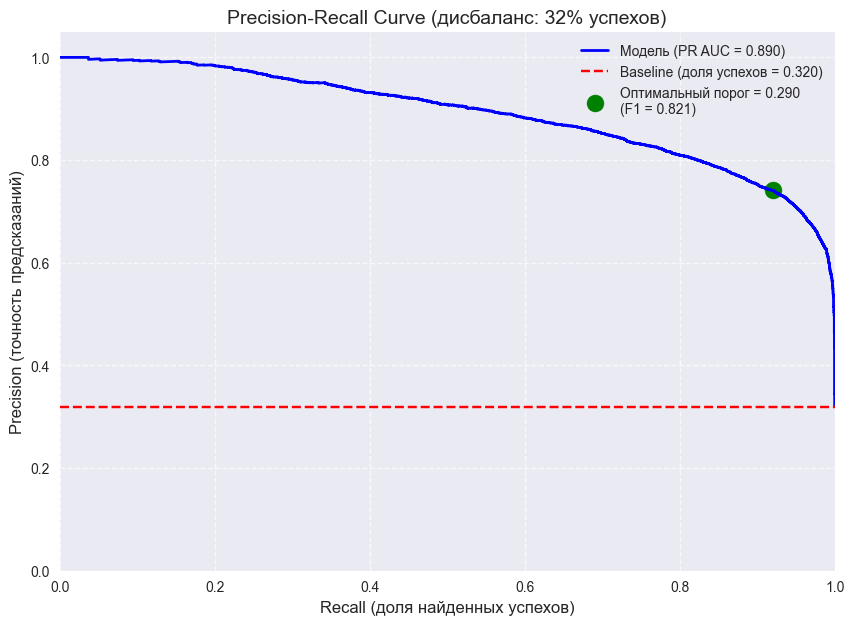

(0.2898858242927743, 0.8896492704736896)

In [101]:
plot_precision_recall_curve(y_test, stacking_results['Stacking_LogisticRegression']['probabilities'])

### Блендинг

#### Создаём validation предсказания

In [102]:
# Дополнительное разделение для hold-out validation
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_no_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [106]:
val_predictions = {}
test_predictions_for_blending = {}

# Обучаем модели на тренировочной части и предсказываем на validation
for name, model in selected_models.items():
    print(f"   Обработка модели: {name}")

    model_clone = type(model)(**model.get_params())
    model_clone.fit(X_train_main, y_train_main)
    val_predictions[name] = model_clone.predict_proba(X_val)[:, 1]
    
    # Для тестовых предсказаний обучаем на всех тренировочных данных
    model_full = type(model)(**model.get_params())
    model_full.fit(X_train_no_text, y_train)
    test_predictions_for_blending[name] = model_full.predict_proba(X_test_no_text)[:, 1]

   Обработка модели: RandomForest
   Обработка модели: DecisionTree
   Обработка модели: XGBoost
   Обработка модели: LightGBM
   Обработка модели: CatBoost
   Обработка модели: LogisticRegression


#### Функции для блендинга

In [128]:
# 1. Simple Averaging Blending
def simple_averaging_blend(predictions_dict):
    pred_matrix = np.column_stack(list(predictions_dict.values()))
    return np.mean(pred_matrix, axis=1)

# 2. Weighted Blending с оптимизацией
def optimize_weights_blend(val_predictions_dict, y_val, method='minimize'):
    model_names = list(val_predictions_dict.keys())
    val_pred_matrix = np.column_stack(list(val_predictions_dict.values()))
    
    def objective_function(weights):
        # Нормализуем веса
        weights = weights / weights.sum()
        blended_pred = np.dot(val_pred_matrix, weights)
        return -f1_score(y_val, (blended_pred > 0.5) * 1)  # Минимизируем отрицательный f1-score
    
    if method == 'minimize':
        # Scipy optimize
        from scipy.optimize import minimize
        
        n_models = len(model_names)
        initial_weights = np.ones(n_models) / n_models
        bounds = [(0, 1) for _ in range(n_models)]
        
        # Ограничение: сумма весов = 1
        constraints = ({'type': 'eq', 'fun': lambda w: w.sum() - 1})
        
        result = minimize(objective_function, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        return result.x, model_names
    
    elif method == 'differential_evolution':
        # Differential Evolution
        from scipy.optimize import differential_evolution
        
        n_models = len(model_names)
        bounds = [(0, 1) for _ in range(n_models)]
        
        def objective_with_normalization(weights):
            weights = weights / weights.sum()  # Нормализация внутри функции
            blended_pred = np.dot(val_pred_matrix, weights)
            return -f1_score(y_val, (blended_pred > 0.5) * 1)
        
        result = differential_evolution(objective_with_normalization, bounds, seed=42)
        optimal_weights = result.x / result.x.sum()  # Финальная нормализация
        
        return optimal_weights, model_names

# 3. Rank Blending
def rank_averaging_blend(predictions_dict, weights=None):
    model_names = list(predictions_dict.keys())
    n_samples = len(list(predictions_dict.values())[0])
    
    # Преобразуем предсказания в ранги
    rank_matrix = np.zeros((n_samples, len(model_names)))
    
    for i, (name, pred) in enumerate(predictions_dict.items()):
        rank_matrix[:, i] = rankdata(pred) / len(pred)  # Нормализованные ранги
    
    # Взвешенное усреднение рангов
    if weights is None:
        weights = np.ones(len(model_names)) / len(model_names)
    
    blended_ranks = np.dot(rank_matrix, weights)
    return blended_ranks

# 4. Power Averaging
def power_averaging_blend(predictions_dict, power=1.0, weights=None):
    pred_matrix = np.column_stack(list(predictions_dict.values()))
    
    if weights is None:
        weights = np.ones(pred_matrix.shape[1]) / pred_matrix.shape[1]
    
    # Применяем степень
    powered_preds = np.power(pred_matrix, power)
    
    # Взвешенное усреднение
    blended = np.dot(powered_preds, weights)
    
    # Обратная степень
    if power != 0:
        blended = np.power(blended, 1.0/power)
    
    return blended

#### Simple Averaging

In [ ]:
blending_results = {}

simple_blend_test = simple_averaging_blend(test_predictions_for_blending)

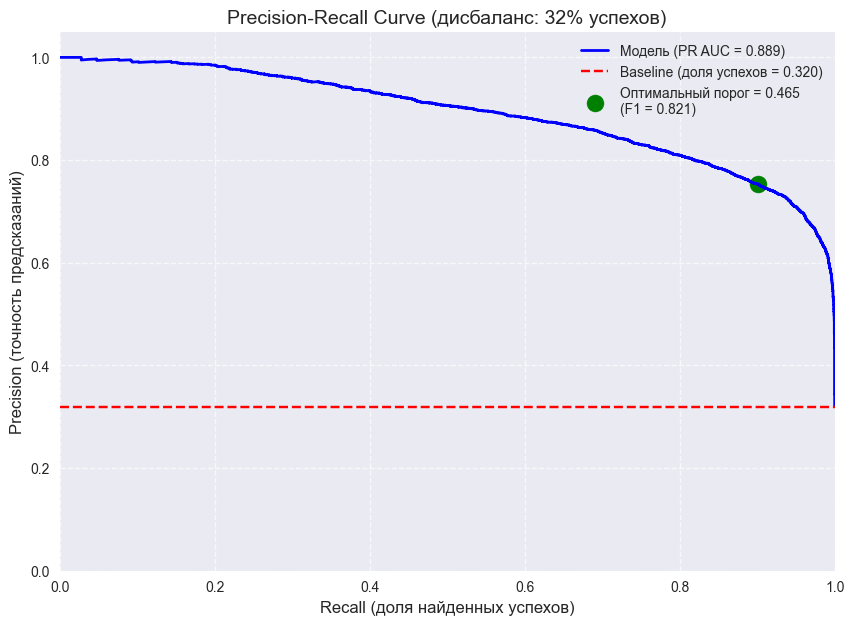

(0.4653731655916959, 0.8893693205746778)

In [130]:
plot_precision_recall_curve(y_test, simple_blend_test)

In [ ]:
simple_blend_test_pred = (simple_blend_test > 0.465) * 1
blending_results['Simple_Averaging'] = {
    'f1_score_test': f1_score(y_test, simple_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, simple_blend_test),
    'predictions': simple_blend_test,
    'method': 'Simple averaging of all models'
}

#### Optimized Weighted Blending (Scipy minimize)

In [142]:
optimal_weights_scipy, model_names = optimize_weights_blend(val_predictions, y_val, method='minimize')

# Применяем оптимальные веса к тестовым данным
test_pred_matrix = np.column_stack([test_predictions_for_blending[name] for name in model_names])
weighted_blend_test = np.dot(test_pred_matrix, optimal_weights_scipy)

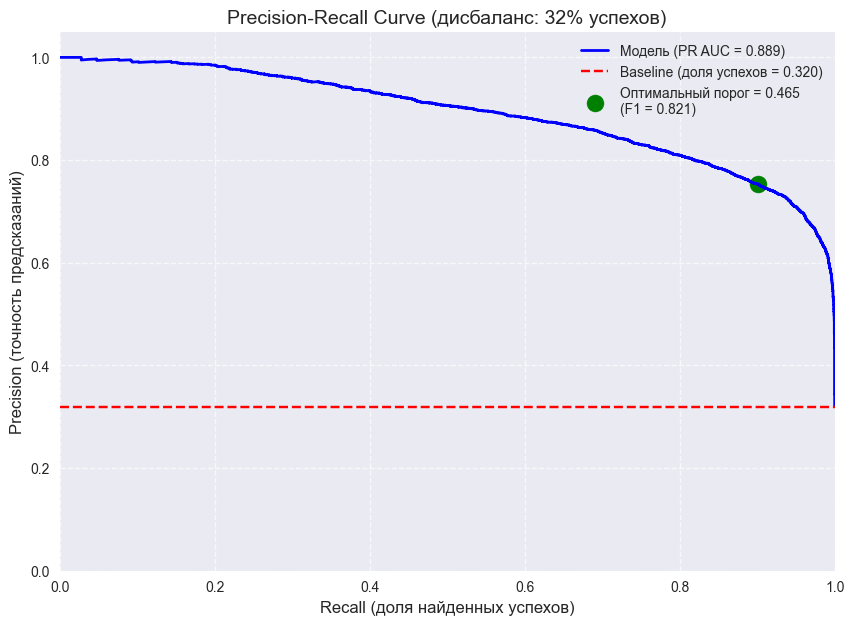

(0.4653731655916959, 0.8893693205746778)

In [143]:
plot_precision_recall_curve(y_test, weighted_blend_test)

In [154]:
weighted_blend_test_pred = (weighted_blend_test > 0.465) * 1
blending_results['Optimized_Weighted'] = {
    'f1_score_test': f1_score(y_test, weighted_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, weighted_blend_test),
    'predictions': weighted_blend_test_pred,
    'method': 'Scipy minimize optimization'
}

#### Differential Evolution Blending

In [137]:
optimal_weights_de, model_names_de = optimize_weights_blend(val_predictions, y_val, method='differential_evolution')

# Применяем оптимальные веса к тестовым данным
test_pred_matrix_de = np.column_stack([test_predictions_for_blending[name] for name in model_names_de])
de_blend_test = np.dot(test_pred_matrix_de, optimal_weights_de)

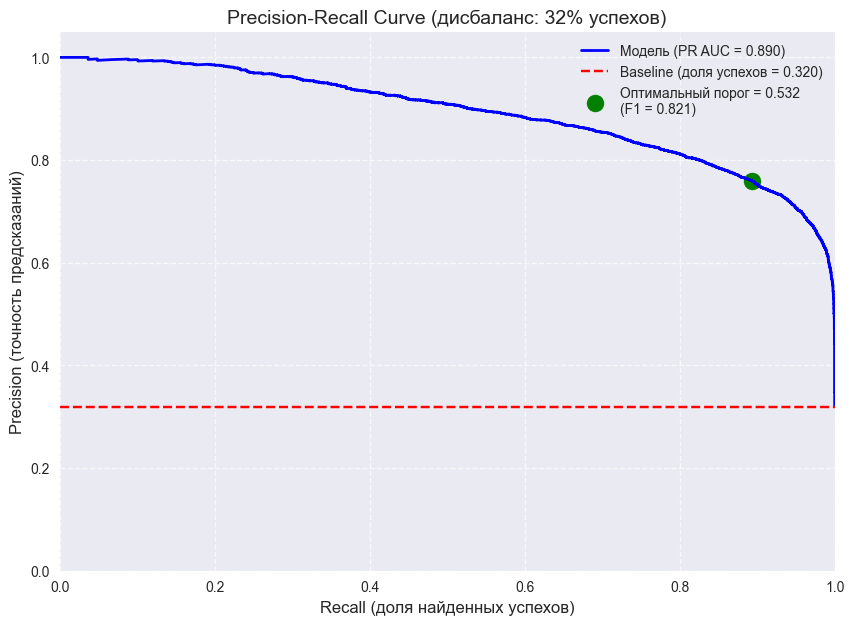

(0.5317275171672846, 0.8902768455581023)

In [138]:
plot_precision_recall_curve(y_test, de_blend_test)

In [155]:
de_blend_test_pred = (de_blend_test > 0.532) * 1
blending_results['Weighted_DE'] = {
    'f1_score_test': f1_score(y_test, de_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, de_blend_test),
    'predictions': de_blend_test_pred,
    'method': 'Differential Evolution optimization'
}

#### Rank Averaging

In [140]:
rank_blend_test = rank_averaging_blend(test_predictions_for_blending)

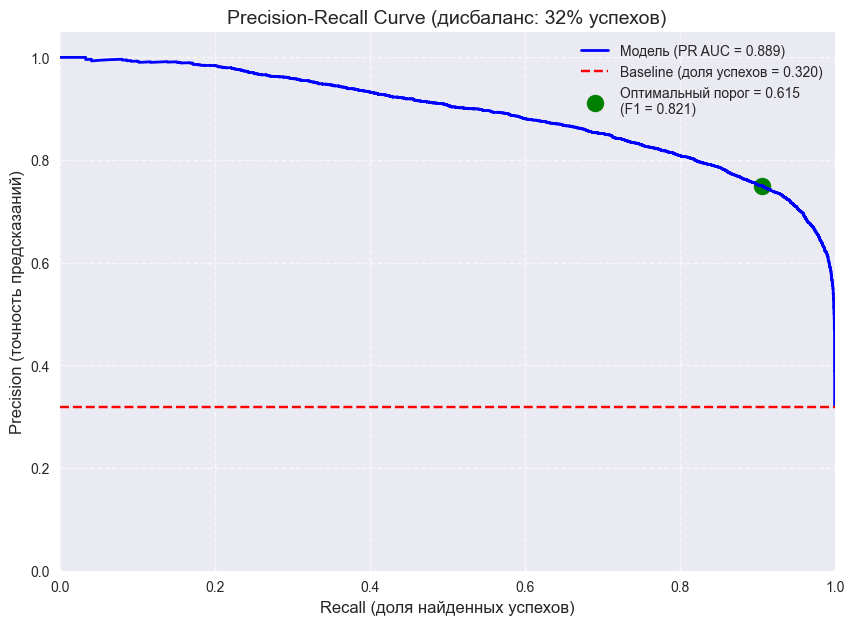

(0.6154157417684054, 0.8889957022339529)

In [141]:
plot_precision_recall_curve(y_test, rank_blend_test)

In [156]:
rank_blend_test_pred = (rank_blend_test > 0.615) * 1
blending_results['Rank_Averaging'] = {
    'f1_score_test': f1_score(y_test, rank_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, rank_blend_test),
    'predictions': rank_blend_test_pred,
    'method': 'Rank-based averaging'
}

#### Power Averaging (степень 2)

In [148]:
power_blend_test = power_averaging_blend(test_predictions_for_blending, power=2)

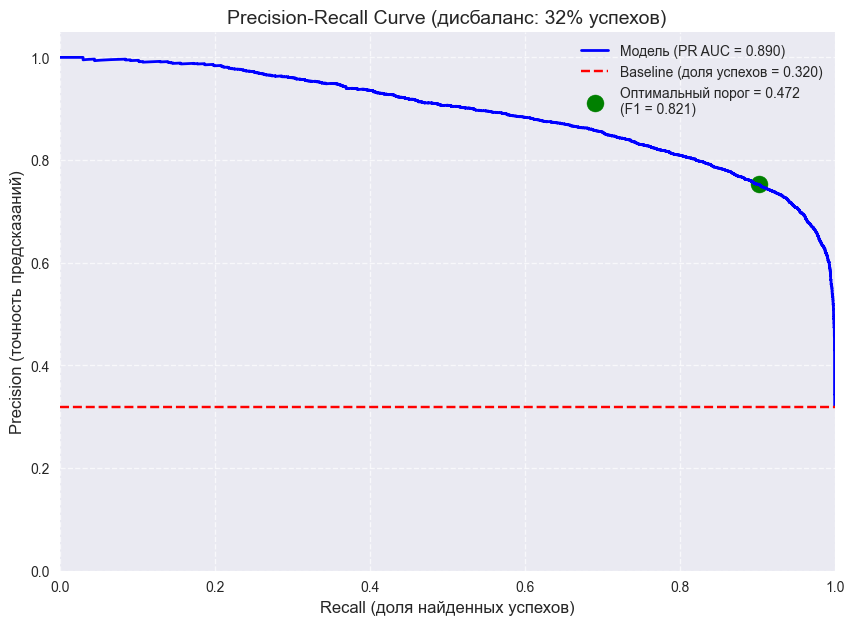

(0.47167163607437274, 0.8895480843468494)

In [149]:
plot_precision_recall_curve(y_test, power_blend_test)

In [157]:
power_blend_test_pred = (power_blend_test > 0.472) * 1
blending_results['Rank_Averaging'] = {
    'f1_score_test': f1_score(y_test, power_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, power_blend_test),
    'predictions': power_blend_test_pred,
    'method': 'Power averaging with p=2'
}

#### Сравниваем

In [158]:
# Создаем сравнительный DataFrame
comparison_df = pd.DataFrame({
    'Модель': list(blending_results.keys()),
    'f1_score_test': [blending_results[name]['f1_score_test'] for name in blending_results.keys()],
    'PR_AUC_test': [blending_results[name]['PR_AUC_test'] for name in blending_results.keys()],
    'Описание': [blending_results[name]['method'] for name in blending_results.keys()],
})

# Сортируем по f1-score
comparison_df = comparison_df.sort_values('f1_score_test', ascending=False).reset_index(drop=True)
comparison_df['Ранг'] = range(1, len(comparison_df) + 1)

print("ТОП-15 МОДЕЛЕЙ:")
print("=" * 100)
top_15 = comparison_df.head(15)[['Ранг', 'Модель', 'f1_score_test', 'PR_AUC_test', 'Описание']].round(4)
print(top_15.to_string(index=False))

ТОП-15 МОДЕЛЕЙ:
 Ранг             Модель  f1_score_test  PR_AUC_test                            Описание
    1        Weighted_DE          0.821        0.890 Differential Evolution optimization
    2   Simple_Averaging          0.821        0.889      Simple averaging of all models
    3 Optimized_Weighted          0.821        0.889         Scipy minimize optimization
    4     Rank_Averaging          0.821        0.889            Power averaging with p=2


**Выводы:**
- к сожалению, ни stacking, ни blending не дал значимых улучшений. Скорее всего зависимости в тех признаках, что есть, не то чтобы супер глубокие и мы их уже выжали в логистической регрессии
- остаётся только смотреть на результаты после добавления глубокой информации по тексту (TF-IDF, ембеддинги)

# Предсказание успеха только по тексту описания и названия

Попробуем теперь наоборот предсказать успешность проекта только по текстовым признакам, чтобы проверить насколько сильный это фактор.

In [228]:
X_train_text = X_train[['name', 'desc']]
X_test_text = X_test[['name', 'desc']]

## Через TF-IDF

В данном разделе объединяем название и тест в один признак.

In [301]:
X_train_text = X_train['name'] + " " + X_train['desc']
X_test_text = X_test['name'] + " " + X_test['desc']

### Предобработка текста

Будем использовать лемматизацию, так как тексты преимущественно короткие.

Я пробовал специально преобразовывать деньги, но качество получалось хуже.

In [347]:
def preprocess_kickstarter_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Сохраняем информацию о восклицательных знаках, когда их много (ну или по крайненй мере пытаемся)
    text = re.sub(r'!{3,}', ' MULTIPLEEXCLAMATION ', text)
    text = re.sub(r'!{2}', ' DOUBLEEXCLAMATION ', text)

    # Удаляем пунктуацию
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Удаляем URL и HTML
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)

    # Кастомные стоп-слова
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Стемминг
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if len(word) > 1]
    
    return " ".join(tokens)

In [348]:
examples = [
        "This is an AMAZING project!!! Only $5,00 needed. Don't miss out!",
        "Our innovative product will change the world. Be the first backer!",
        "Limited edition available. Early bird special for the first 100 pledgers.",
        "We're not going to accept low quality. Support our vision today!!!"
    ]
preprocess_kickstarter_text(examples[0])

'amaz project multipleexclam 500 need dont miss'

In [349]:
X_train_clean = X_train_text.apply(preprocess_kickstarter_text)
X_test_clean = X_test_text.apply(preprocess_kickstarter_text)

In [350]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)

### Модели

In [ ]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
models = {
    'Логистическая регрессия': LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        class_weight='balanced'
    ),

    'Деревья решений': DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        class_weight='balanced'
    ),

    'Случайный лес': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ),

    'Наивный Байес': MultinomialNB(
        class_prior=None,  
        fit_prior=True,
        alpha=0.5
    ),

    'k-NN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    ),

    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        verbosity=0,
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        force_col_wise=True,
        is_unbalance=True,
        learning_rate=0.05,
        feature_fraction=0.8
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        verbose=False,
        class_weights=class_weights,  
        learning_rate=0.05,
        subsample=0.8,
        max_depth=6
    )
}

In [362]:
results = {}
trained_models = {}

for name, model in models.items():
    print('***************************************')
    print(f"Обучение: {name}")
    print('---------------------------------------')

    start = time.time()
    
    model.fit(X_train_tfidf, y_train)
    
    # Сохраняем предсказания и метрики
    results[name] = process_result(model, X_train_tfidf, X_test_tfidf)
    
    # Сохраняем обученную модель
    trained_models[name] = model

    print(f'Время на обучение: {(time.time() - start):.1f} сек')
    print()
    
    print_results(results[name])

***************************************
Обучение: Логистическая регрессия
---------------------------------------
Время на обучение: 0.9 сек

Тестовый f1-score: 0.530

Тестовый PR AUC: 0.524

Тестовый accuracy: 0.646

Средний f1-score на кросс-валидации: 0.528

Дисперсия f1-score на кросс-валидации: 0.004

***************************************
Обучение: Деревья решений
---------------------------------------
Время на обучение: 7.6 сек

Тестовый f1-score: 0.337

Тестовый PR AUC: 0.395

Тестовый accuracy: 0.674

Средний f1-score на кросс-валидации: 0.340

Дисперсия f1-score на кросс-валидации: 0.004

***************************************
Обучение: Случайный лес
---------------------------------------
Время на обучение: 837.2 сек

Тестовый f1-score: 0.398

Тестовый PR AUC: 0.516

Тестовый accuracy: 0.703

Средний f1-score на кросс-валидации: 0.393

Дисперсия f1-score на кросс-валидации: 0.006

***************************************
Обучение: Наивный Байес
----------------------------

In [363]:
# Создаем сравнительную таблицу результатов
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'f1-score test': [results[name]['f1_test'] for name in results.keys()],
    'PR AUC test': [results[name]['PR_AUC_test'] for name in results.keys()],
    'CV f1-score': [results[name]['f1_cv_mean'] for name in results.keys()],
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
})

# Сортируем по f1-score на тесте
results_df = results_df.sort_values('f1-score test', ascending=False).reset_index(drop=True)

print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("=" * 128)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\nЛучшая модель по f1-score test: {results_df.iloc[0]['Модель']} ({results_df.iloc[0]['f1-score test']:.3f})")

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
                 Модель  f1-score test  PR AUC test  CV f1-score  Accuracy
Логистическая регрессия          0.530        0.524        0.528     0.646
               CatBoost          0.522        0.519        0.518     0.651
               LightGBM          0.508        0.512        0.503     0.655
                XGBoost          0.454        0.476        0.456     0.662
          Случайный лес          0.398        0.516        0.393     0.703
        Деревья решений          0.337        0.395        0.340     0.674
          Наивный Байес          0.298        0.519        0.292     0.704
                   k-NN          0.103        0.363        0.094     0.680

Лучшая модель по f1-score test: Логистическая регрессия (0.530)


In [369]:
y_test.describe()

count   21624.000
mean        0.320
std         0.466
min         0.000
25%         0.000
50%         0.000
75%         1.000
max         1.000
Name: final_status, dtype: float64

Удивительно, но логистическая регрессия снова оказалась лучшей.

Что ж результаты не сильно впечатляют, но мы предсказываем немного лучше, чем случайное угадывание с равной вероятностью (где-то на 6%). Кроме того Accuracy у нас хуже, чем если бы мы просто угадывали провал (учитывая дисбаланс классов), но лучше случайного угадывания.

Хотя конечно если сравнивать с несбалансированным случайным угадыванием (по весу классов), то мы предсказываем гораздо лучше.

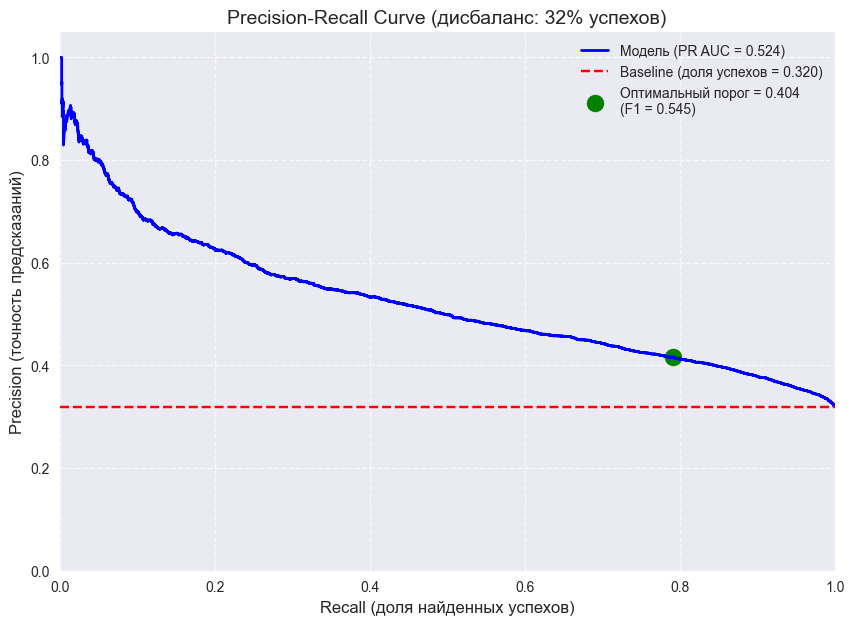

(0.4041108033125507, 0.5241833785143031)

In [371]:
plot_precision_recall_curve(y_test, results['Логистическая регрессия']['probabilities'])

### Блендинг

In [372]:
# Дополнительное разделение для hold-out validation
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [374]:
val_predictions = {}
test_predictions_for_blending = {}

# Обучаем модели на тренировочной части и предсказываем на validation
for name, info in results.items():
    if name in ['Случайный лес', 'Деревья решений', 'Наивный Байес', 'k-NN']:
        continue
    print(f"   Обработка модели: {name}")

    model = info['model']

    model_clone = type(model)(**model.get_params())
    model_clone.fit(X_train_main, y_train_main)
    val_predictions[name] = model_clone.predict_proba(X_val)[:, 1]
    
    # Для тестовых предсказаний берём уже обученные, чтобы не учить дважды
    test_predictions_for_blending[name] = model.predict_proba(X_test_tfidf)[:, 1]

   Обработка модели: Логистическая регрессия
   Обработка модели: XGBoost
   Обработка модели: LightGBM
   Обработка модели: CatBoost


#### Функции для блендинга

In [379]:
# 1. Simple Averaging Blending
def simple_averaging_blend(predictions_dict):
    pred_matrix = np.column_stack(list(predictions_dict.values()))
    return np.mean(pred_matrix, axis=1)

# 2. Weighted Blending с оптимизацией
def optimize_weights_blend(val_predictions_dict, y_val, method='minimize'):
    model_names = list(val_predictions_dict.keys())
    val_pred_matrix = np.column_stack(list(val_predictions_dict.values()))
    
    def objective_function(weights):
        # Нормализуем веса
        weights = weights / weights.sum()
        blended_pred = np.dot(val_pred_matrix, weights)
        return -average_precision_score(y_val, blended_pred)  # Минимизируем отрицательный PR AUC
    
    if method == 'minimize':
        # Scipy optimize
        from scipy.optimize import minimize
        
        n_models = len(model_names)
        initial_weights = np.ones(n_models) / n_models
        bounds = [(0, 1) for _ in range(n_models)]
        
        # Ограничение: сумма весов = 1
        constraints = ({'type': 'eq', 'fun': lambda w: w.sum() - 1})
        
        result = minimize(objective_function, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        return result.x, model_names
    
    elif method == 'differential_evolution':
        # Differential Evolution
        from scipy.optimize import differential_evolution
        
        n_models = len(model_names)
        bounds = [(0, 1) for _ in range(n_models)]
        
        def objective_with_normalization(weights):
            weights = weights / weights.sum()  # Нормализация внутри функции
            blended_pred = np.dot(val_pred_matrix, weights)
            return -average_precision_score(y_val, blended_pred)
        
        result = differential_evolution(objective_with_normalization, bounds, seed=42)
        optimal_weights = result.x / result.x.sum()  # Финальная нормализация
        
        return optimal_weights, model_names

# 3. Rank Blending
def rank_averaging_blend(predictions_dict, weights=None):
    model_names = list(predictions_dict.keys())
    n_samples = len(list(predictions_dict.values())[0])
    
    # Преобразуем предсказания в ранги
    rank_matrix = np.zeros((n_samples, len(model_names)))
    
    for i, (name, pred) in enumerate(predictions_dict.items()):
        rank_matrix[:, i] = rankdata(pred) / len(pred)  # Нормализованные ранги
    
    # Взвешенное усреднение рангов
    if weights is None:
        weights = np.ones(len(model_names)) / len(model_names)
    
    blended_ranks = np.dot(rank_matrix, weights)
    return blended_ranks

# 4. Power Averaging
def power_averaging_blend(predictions_dict, power=1.0, weights=None):
    pred_matrix = np.column_stack(list(predictions_dict.values()))
    
    if weights is None:
        weights = np.ones(pred_matrix.shape[1]) / pred_matrix.shape[1]
    
    # Применяем степень
    powered_preds = np.power(pred_matrix, power)
    
    # Взвешенное усреднение
    blended = np.dot(powered_preds, weights)
    
    # Обратная степень
    if power != 0:
        blended = np.power(blended, 1.0/power)
    
    return blended

In [376]:
def compute_optimal_threshhold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # +1e-10 избегает деления на 0
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx] if max_f1_idx < len(thresholds) else 1.0
    return optimal_threshold

In [377]:
blending_results = {}

#### Simple Averaging

In [ ]:
simple_blend_test = simple_averaging_blend(test_predictions_for_blending)
opt_thr = compute_optimal_threshhold(y_test, simple_blend_test)
simple_blend_test_pred = (simple_blend_test > opt_thr) * 1
blending_results['Simple_Averaging'] = {
    'f1_score_test': f1_score(y_test, simple_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, simple_blend_test),
    'predictions': simple_blend_test,
    'method': 'Simple averaging of all models'
}

#### Optimized Weighted Blending (Scipy minimize)

In [380]:
optimal_weights_scipy, model_names = optimize_weights_blend(val_predictions, y_val, method='minimize')

# Применяем оптимальные веса к тестовым данным
test_pred_matrix = np.column_stack([test_predictions_for_blending[name] for name in model_names])
weighted_blend_test = np.dot(test_pred_matrix, optimal_weights_scipy)

opt_thr = compute_optimal_threshhold(y_test, weighted_blend_test)

weighted_blend_test_pred = (weighted_blend_test > opt_thr) * 1
blending_results['Optimized_Weighted'] = {
    'f1_score_test': f1_score(y_test, weighted_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, weighted_blend_test),
    'predictions': weighted_blend_test_pred,
    'method': 'Scipy minimize optimization'
}

#### Differential Evolution Blending

In [381]:
optimal_weights_de, model_names_de = optimize_weights_blend(val_predictions, y_val, method='differential_evolution')

# Применяем оптимальные веса к тестовым данным
test_pred_matrix_de = np.column_stack([test_predictions_for_blending[name] for name in model_names_de])
de_blend_test = np.dot(test_pred_matrix_de, optimal_weights_de)

opt_thr = compute_optimal_threshhold(y_test, de_blend_test)

de_blend_test_pred = (de_blend_test > opt_thr) * 1
blending_results['Weighted_DE'] = {
    'f1_score_test': f1_score(y_test, de_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, de_blend_test),
    'predictions': de_blend_test_pred,
    'method': 'Differential Evolution optimization'
}

#### Rank Averaging

In [382]:
rank_blend_test = rank_averaging_blend(test_predictions_for_blending)

opt_thr = compute_optimal_threshhold(y_test, rank_blend_test)

rank_blend_test_pred = (rank_blend_test > opt_thr) * 1
blending_results['Rank_Averaging'] = {
    'f1_score_test': f1_score(y_test, rank_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, rank_blend_test),
    'predictions': rank_blend_test_pred,
    'method': 'Rank-based averaging'
}

#### Power Averaging (степень 2)

In [383]:
power_blend_test = power_averaging_blend(test_predictions_for_blending, power=2)

opt_thr = compute_optimal_threshhold(y_test, power_blend_test)

power_blend_test_pred = (power_blend_test > opt_thr) * 1
blending_results['Rank_Averaging'] = {
    'f1_score_test': f1_score(y_test, power_blend_test_pred),
    'PR_AUC_test': average_precision_score(y_test, power_blend_test),
    'predictions': power_blend_test_pred,
    'method': 'Power averaging with p=2'
}

#### Сравниваем

In [384]:
# Создаем сравнительный DataFrame
comparison_df = pd.DataFrame({
    'Модель': list(blending_results.keys()),
    'f1_score_test': [blending_results[name]['f1_score_test'] for name in blending_results.keys()],
    'PR_AUC_test': [blending_results[name]['PR_AUC_test'] for name in blending_results.keys()],
    'Описание': [blending_results[name]['method'] for name in blending_results.keys()],
})

# Сортируем по f1-score
comparison_df = comparison_df.sort_values('f1_score_test', ascending=False).reset_index(drop=True)
comparison_df['Ранг'] = range(1, len(comparison_df) + 1)

print("ТОП-15 МОДЕЛЕЙ:")
print("=" * 100)
top_15 = comparison_df.head(15)[['Ранг', 'Модель', 'f1_score_test', 'PR_AUC_test', 'Описание']].round(4)
print(top_15.to_string(index=False))

ТОП-15 МОДЕЛЕЙ:
 Ранг             Модель  f1_score_test  PR_AUC_test                            Описание
    1        Weighted_DE          0.549        0.531 Differential Evolution optimization
    2     Rank_Averaging          0.548        0.528            Power averaging with p=2
    3   Simple_Averaging          0.548        0.527      Simple averaging of all models
    4 Optimized_Weighted          0.548        0.527         Scipy minimize optimization


Получилось немного улучшить. Теперь мы лучше случайного предсказания (с вероятностью 0.5) по f1-score где-то на 10%.

## Embedding модели

### Предобработка

Для Embedding моделей постараемся не убирать доп сигналы из текста, то есть минимум предобработки

In [385]:
def preprocess_text_for_embeddings(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Удаляем URL и HTML
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)

    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [386]:
X_train_clean = X_train_text.apply(preprocess_text_for_embeddings)
X_test_clean = X_test_text.apply(preprocess_text_for_embeddings)

### Word2Vec

#### Обучаем

In [389]:
# Токенизация
tokenized_texts = [nltk.word_tokenize(text.lower()) for text in X_train_clean]

# Параметры
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,     
    window=5,            
    min_count=5,         
    workers=4,
)

print(f"Количество уникальных слов: {len(w2v_model.wv.index_to_key)}")

Количество уникальных слов: 20047


#### Кодируем

In [ ]:
def get_average_embedding(text, model, vector_size=100):
    words = nltk.word_tokenize(text.lower())
    word_embeddings = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_embeddings) == 0:
        return np.zeros(vector_size)
    
    return np.mean(word_embeddings, axis=0)

In [ ]:
X_train_w2v = np.array([get_average_embedding(text, w2v_model) for text in X_train_clean])
X_test_w2v = np.array([get_average_embedding(text, w2v_model) for text in X_test_clean])

In [392]:
print(f"Форма эмбеддингов: {X_train_w2v.shape}")

Форма эмбеддингов: (86495, 100)


#### Обучаем модели

In [395]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
models = {
    'Логистическая регрессия': LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        class_weight='balanced'
    ),

    'Деревья решений': DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        class_weight='balanced'
    ),

    'Случайный лес': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ),

    'k-NN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    ),

    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        verbosity=0,
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        force_col_wise=True,
        is_unbalance=True,
        learning_rate=0.05,
        feature_fraction=0.8
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        verbose=False,
        class_weights=class_weights,  
        learning_rate=0.05,
        subsample=0.8,
        max_depth=6
    )
}

In [396]:
results = {}
trained_models = {}

for name, model in models.items():
    print('***************************************')
    print(f"Обучение: {name}")
    print('---------------------------------------')

    start = time.time()
    
    model.fit(X_train_w2v, y_train)
    
    # Сохраняем предсказания и метрики
    results[name] = process_result(model, X_train_w2v, X_test_w2v)
    
    # Сохраняем обученную модель
    trained_models[name] = model

    print(f'Время на обучение: {(time.time() - start):.1f} сек')
    print()
    
    print_results(results[name])

***************************************
Обучение: Логистическая регрессия
---------------------------------------
Время на обучение: 15.9 сек

Тестовый f1-score: 0.505

Тестовый PR AUC: 0.437

Тестовый accuracy: 0.588

Средний f1-score на кросс-валидации: 0.500

Дисперсия f1-score на кросс-валидации: 0.004

***************************************
Обучение: Деревья решений
---------------------------------------
Время на обучение: 50.1 сек

Тестовый f1-score: 0.471

Тестовый PR AUC: 0.389

Тестовый accuracy: 0.548

Средний f1-score на кросс-валидации: 0.461

Дисперсия f1-score на кросс-валидации: 0.001

***************************************
Обучение: Случайный лес
---------------------------------------
Время на обучение: 516.9 сек

Тестовый f1-score: 0.154

Тестовый PR AUC: 0.460

Тестовый accuracy: 0.689

Средний f1-score на кросс-валидации: 0.147

Дисперсия f1-score на кросс-валидации: 0.006

***************************************
Обучение: k-NN
-----------------------------------

In [397]:
# Создаем сравнительную таблицу результатов
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'f1-score test': [results[name]['f1_test'] for name in results.keys()],
    'PR AUC test': [results[name]['PR_AUC_test'] for name in results.keys()],
    'CV f1-score': [results[name]['f1_cv_mean'] for name in results.keys()],
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
})

# Сортируем по f1-score на тесте
results_df = results_df.sort_values('f1-score test', ascending=False).reset_index(drop=True)

print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("=" * 128)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\nЛучшая модель по f1-score test: {results_df.iloc[0]['Модель']} ({results_df.iloc[0]['f1-score test']:.3f})")

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
                 Модель  f1-score test  PR AUC test  CV f1-score  Accuracy
               CatBoost          0.512        0.485        0.507     0.625
                XGBoost          0.509        0.472        0.503     0.602
               LightGBM          0.506        0.470        0.506     0.599
Логистическая регрессия          0.505        0.437        0.500     0.588
        Деревья решений          0.471        0.389        0.461     0.548
                   k-NN          0.370        0.406        0.362     0.643
          Случайный лес          0.154        0.460        0.147     0.689

Лучшая модель по f1-score test: CatBoost (0.512)


Результаты хуже, так что блендинг делать не будем

### SBERT

Понятно, что модели для задачи нужно смотреть на каком-нибудь MTEB, брать несколько и смотреть какая лучше. Но за экономией времени и ресрсов для pet-проекта обойдёмся простой моделью.

Взял SBERT так как он простой и достаточно маленький для моего слабого компа.

#### Кодируем

Для экономии будем объеденять эмбеддинги для названия и описания через суммирование. У названия вес будет больше, так как оно самое главное.

In [166]:
def get_embeddings(titles, descriptions):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    title_embeddings = model.encode(titles.tolist(), show_progress_bar=True)
    desc_embeddings = model.encode(descriptions.tolist(), show_progress_bar=True)
    
    return title_embeddings, desc_embeddings

title_embeddings_train, desc_embeddings_train = get_embeddings(X_train['name'], X_train['desc'])
title_embeddings_test, desc_embeddings_test = get_embeddings(X_test['name'], X_test['desc'])

Batches:   0%|          | 0/2703 [00:00<?, ?it/s]

Batches:   0%|          | 0/2703 [00:00<?, ?it/s]

Batches:   0%|          | 0/676 [00:00<?, ?it/s]

Batches:   0%|          | 0/676 [00:00<?, ?it/s]

Суммирование с весом

In [415]:
X_train_sbert = 0.65 * title_embeddings_train + 0.35 * desc_embeddings_train
X_test_sbert = 0.65 * title_embeddings_test + 0.35 * desc_embeddings_test

Конкатенация

In [167]:
X_train_sbert = np.hstack([title_embeddings_train, desc_embeddings_train])
X_test_sbert = np.hstack([title_embeddings_test, desc_embeddings_test])

#### Обучаем модели (суммирование)

In [411]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
models = {
    'Логистическая регрессия': LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        class_weight='balanced'
    ),

    'Деревья решений': DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        class_weight='balanced'
    ),

    'Случайный лес': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ),

    'k-NN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    ),

    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        verbosity=0,
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        force_col_wise=True,
        is_unbalance=True,
        learning_rate=0.05,
        feature_fraction=0.8
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        verbose=False,
        class_weights=class_weights,  
        learning_rate=0.05,
        subsample=0.8,
        max_depth=6
    )
}

In [412]:
results = {}
trained_models = {}

for name, model in models.items():
    print('***************************************')
    print(f"Обучение: {name}")
    print('---------------------------------------')

    start = time.time()
    
    model.fit(X_train_sbert, y_train)
    
    # Сохраняем предсказания и метрики
    results[name] = process_result(model, X_train_sbert, X_test_sbert)
    
    # Сохраняем обученную модель
    trained_models[name] = model

    print(f'Время на обучение: {(time.time() - start):.1f} сек')
    print()
    
    print_results(results[name])

***************************************
Обучение: Логистическая регрессия
---------------------------------------
Время на обучение: 5.7 сек

Тестовый f1-score: 0.502

Тестовый PR AUC: 0.462

Тестовый accuracy: 0.604

Средний f1-score на кросс-валидации: 0.506

Дисперсия f1-score на кросс-валидации: 0.004

***************************************
Обучение: Деревья решений
---------------------------------------
Время на обучение: 202.0 сек

Тестовый f1-score: 0.431

Тестовый PR AUC: 0.362

Тестовый accuracy: 0.537

Средний f1-score на кросс-валидации: 0.426

Дисперсия f1-score на кросс-валидации: 0.005

***************************************
Обучение: Случайный лес
---------------------------------------
Время на обучение: 1014.8 сек

Тестовый f1-score: 0.048

Тестовый PR AUC: 0.429

Тестовый accuracy: 0.683

Средний f1-score на кросс-валидации: 0.039

Дисперсия f1-score на кросс-валидации: 0.005

***************************************
Обучение: k-NN
----------------------------------

In [413]:
# Создаем сравнительную таблицу результатов
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'f1-score test': [results[name]['f1_test'] for name in results.keys()],
    'PR AUC test': [results[name]['PR_AUC_test'] for name in results.keys()],
    'CV f1-score': [results[name]['f1_cv_mean'] for name in results.keys()],
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
})

# Сортируем по f1-score на тесте
results_df = results_df.sort_values('f1-score test', ascending=False).reset_index(drop=True)

print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("=" * 128)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\nЛучшая модель по f1-score test: {results_df.iloc[0]['Модель']} ({results_df.iloc[0]['f1-score test']:.3f})")

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
                 Модель  f1-score test  PR AUC test  CV f1-score  Accuracy
               CatBoost          0.507        0.487        0.499     0.633
               LightGBM          0.503        0.469        0.493     0.614
Логистическая регрессия          0.502        0.462        0.506     0.604
                XGBoost          0.495        0.468        0.487     0.615
        Деревья решений          0.431        0.362        0.426     0.537
                   k-NN          0.351        0.434        0.346     0.668
          Случайный лес          0.048        0.429        0.039     0.683

Лучшая модель по f1-score test: CatBoost (0.507)


#### Обучаем модели (конкатенирование)

Убираем случайный лес, так как бустинги по сути и так его используют, а сам по себе он долго считается и переобучается.

In [426]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
models = {
    'Логистическая регрессия': LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        class_weight='balanced'
    ),

    'Деревья решений': DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        class_weight='balanced'
    ),

    'k-NN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    ),

    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        verbosity=0,
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        force_col_wise=True,
        is_unbalance=True,
        learning_rate=0.05,
        feature_fraction=0.8
    ),
    'CatBoost': CatBoostClassifier(
        random_state=42,
        verbose=False,
        class_weights=class_weights,  
        learning_rate=0.05,
        subsample=0.8,
        max_depth=6
    )
}

In [427]:
results = {}
trained_models = {}

for name, model in models.items():
    print('***************************************')
    print(f"Обучение: {name}")
    print('---------------------------------------')

    start = time.time()
    
    model.fit(X_train_sbert, y_train)
    
    # Сохраняем предсказания и метрики
    results[name] = process_result(model, X_train_sbert, X_test_sbert)
    
    # Сохраняем обученную модель
    trained_models[name] = model

    print(f'Время на обучение: {(time.time() - start):.1f} сек')
    print()
    
    print_results(results[name])

***************************************
Обучение: Логистическая регрессия
---------------------------------------
Время на обучение: 15.7 сек

Тестовый f1-score: 0.519

Тестовый PR AUC: 0.480

Тестовый accuracy: 0.620

Средний f1-score на кросс-валидации: 0.519

Дисперсия f1-score на кросс-валидации: 0.004

***************************************
Обучение: Деревья решений
---------------------------------------
Время на обучение: 399.8 сек

Тестовый f1-score: 0.456

Тестовый PR AUC: 0.363

Тестовый accuracy: 0.531

Средний f1-score на кросс-валидации: 0.448

Дисперсия f1-score на кросс-валидации: 0.007

***************************************
Обучение: k-NN
---------------------------------------
Время на обучение: 75.7 сек

Тестовый f1-score: 0.399

Тестовый PR AUC: 0.455

Тестовый accuracy: 0.675

Средний f1-score на кросс-валидации: 0.383

Дисперсия f1-score на кросс-валидации: 0.002

***************************************
Обучение: XGBoost
---------------------------------------
В

In [428]:
# Создаем сравнительную таблицу результатов
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'f1-score test': [results[name]['f1_test'] for name in results.keys()],
    'PR AUC test': [results[name]['PR_AUC_test'] for name in results.keys()],
    'CV f1-score': [results[name]['f1_cv_mean'] for name in results.keys()],
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
})

# Сортируем по f1-score на тесте
results_df = results_df.sort_values('f1-score test', ascending=False).reset_index(drop=True)

print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("=" * 128)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\nЛучшая модель по f1-score test: {results_df.iloc[0]['Модель']} ({results_df.iloc[0]['f1-score test']:.3f})")

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
                 Модель  f1-score test  PR AUC test  CV f1-score  Accuracy
               CatBoost          0.520        0.497        0.509     0.641
Логистическая регрессия          0.519        0.480        0.519     0.620
               LightGBM          0.514        0.472        0.506     0.617
                XGBoost          0.509        0.473        0.499     0.619
        Деревья решений          0.456        0.363        0.448     0.531
                   k-NN          0.399        0.455        0.383     0.675

Лучшая модель по f1-score test: CatBoost (0.520)


На удивление в обоих случаях результат всё ещё хуже, чем TF-IDF. Возможно доппредобработка текста перед TF-IDF сделала своё грязное дело.

### Обучение "головы"

Попробуем дообучить голову на эмбеддингах SBERT. В идеале нужно дообучить весь SBERT, но за экономией ресурсов сделаем пока так.

In [168]:
X_train_sbert = np.hstack([title_embeddings_train, desc_embeddings_train])
X_test_sbert = np.hstack([title_embeddings_test, desc_embeddings_test])

In [169]:
X_train_sbert.shape

(86495, 768)

#### Строим сетку

Для экспериментов сделал настройку параметров.

In [224]:
class KickstarterMLP(nn.Module):
    def __init__(self, 
                input_size,
                hidden_sizes=[256, 128, 64],
                dropout_rate=0.25,   
                use_batch_norm=True,
                class_weights=None,  
                activation='leaky_relu'):
        
        super(KickstarterMLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.use_batch_norm = use_batch_norm
        self.class_weights = class_weights
        self.activation = activation
        self.dropout_rate = dropout_rate
        
        layers = []
        prev_size = input_size
        
        # Создаем слои
        for i, hidden_size in enumerate(hidden_sizes):
            # Полносвязный с адекватной инициализацией
            linear = nn.Linear(prev_size, hidden_size)
            kaiming_normal_(linear.weight, nonlinearity=activation)
            constant_(linear.bias, 0)
            layers.append(linear)
            
            #BatchNorm
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            
            # Активация 
            if activation == 'leaky_relu':
                layers.append(nn.LeakyReLU(negative_slope=0.01))
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'mish':
                layers.append(nn.Mish())
            else:
                layers.append(nn.ReLU())
            
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            
            prev_size = hidden_size
        
        # Выходной слой (без сигмоиды - используем BCEWithLogitsLoss)
        self.output_layer = nn.Linear(prev_size, 1)
        kaiming_normal_(self.output_layer.weight, nonlinearity='leaky_relu')
        constant_(self.output_layer.bias, 0)
        
        # Сохраняем все слои
        self.network = nn.Sequential(*layers)
        
        # Сохраняем параметры для логгирования
        self.params = {
            'input_size': input_size,
            'hidden_sizes': hidden_sizes,
            'dropout_rate': dropout_rate,
            'use_batch_norm': use_batch_norm,
            'activation': activation,
        }


    def forward(self, x):
        x = self.network(x)
        x = self.output_layer(x)
        return x

#### Переводим данные в нужный вид

In [225]:
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train_sbert, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [226]:
# Рассчитываем веса классов 
class_weights = {
    0: 1.0,
    1: (len(y_train) - sum(y_train)) / sum(y_train)
}
print(f"Веса классов: {class_weights}")

Веса классов: {0: 1.0, 1: 2.128322904987522}


In [227]:
X_train_tensor = torch.FloatTensor(X_train_)
y_train_tensor = torch.FloatTensor(y_train_.values).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_sbert)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [228]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Настройки для обучения (вынес отдельно, чтобы не засорять)

In [229]:
def setup_training(model, class_weights, lr=5e-4, weight_decay=1e-5):

    pos_weight = torch.tensor([class_weights[1]])
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # weight decay для регуляризации
    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay  # L2 регуляризация
    )
    
    # scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',          
        factor=0.5,          
        patience=3,
        min_lr=1e-6          
    )
    
    # Ранняя остановка
    early_stopping = {
        'patience': 8,      
        'min_delta': 0.001, 
        'best_score': None,
        'epochs_no_improve': 0,
        'stop': False
    }
    
    return criterion, optimizer, scheduler, early_stopping

In [267]:
# Инициализируем модель
model = KickstarterMLP(
    input_size=X_train_.shape[1],
)

# Настройка обучения
criterion, optimizer, scheduler, early_stopping = setup_training(
    model, 
    class_weights,
    lr=5e-5, # оставил такой после нескольких запуков
    weight_decay=1e-5
)

#### Функции для обучения и валидации

train для эпохи

In [268]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    for embeddings, labels in tqdm(dataloader, desc="Training", leave=False):
        
        optimizer.zero_grad()

        outputs = model(embeddings)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        all_probs.extend(probs.cpu().detach().numpy())
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Вычисляем метрики
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    PR_auc = average_precision_score(all_labels, all_probs)
    
    return avg_loss, f1, precision, recall, PR_auc

Валидация за эпоху

In [269]:
def validate_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for embeddings, labels in dataloader:
            
            outputs = model(embeddings)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Вычисляем метрики
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    PR_auc = average_precision_score(all_labels, all_probs)
    
    return avg_loss, f1, precision, recall, PR_auc, all_probs, all_labels

Полный цикл

В ранней остановке стараемся максимизировать PR AUC - прогоны показали, что это даёт лучший результат.

In [270]:
def train_model(model, train_loader, val_loader, criterion, 
                optimizer, scheduler, early_stopping, epochs=50):
    
    # Списки для хранения метрик
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_pr_aucs = []
    val_pr_aucs = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nЭпоха {epoch+1}/{epochs}")
        
        # Обучение
        train_loss, train_f1, train_precision, train_recall, train_pr_auc = train_epoch(
            model, train_loader, criterion, optimizer
        )
        
        # Валидация
        val_loss, val_f1, val_precision, val_recall, val_pr_auc, _, _ = validate_epoch(
            model, val_loader, criterion
        )
        
        # Обновляем LR scheduler
        scheduler.step(val_pr_auc)
        
        # Сохраняем метрики
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        train_pr_aucs.append(train_pr_auc)
        val_pr_aucs.append(val_pr_auc)
        
        # Выводим результаты
        print(f"  Train Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | PR AUC: {train_pr_auc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | F1: {val_f1:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | PR AUC: {val_pr_auc:.4f}")
        
        # Ранняя остановка
        current_score = val_pr_auc
        
        if early_stopping['best_score'] is None:
            early_stopping['best_score'] = current_score
        elif current_score < early_stopping['best_score'] + early_stopping['min_delta']:
            early_stopping['epochs_no_improve'] += 1
            if early_stopping['epochs_no_improve'] >= early_stopping['patience']:
                early_stopping['stop'] = True
                print(f"\nРанняя остановка на эпохе {epoch+1}")
                break
        else:
            early_stopping['best_score'] = current_score
            early_stopping['epochs_no_improve'] = 0
    
    total_time = time.time() - start_time
    print(f"\nОбучение завершено за {total_time:.2f} секунд")
    
    # Возвращаем метрики для визуализации
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_pr_aucs': train_pr_aucs,
        'val_pr_aucs': val_pr_aucs
    }

#### Обучение

In [271]:
metrics = train_model(
    model, train_loader, val_loader, criterion, 
    optimizer, scheduler, early_stopping
)


Эпоха 1/50


  Train Loss: 1.1102 | F1: 0.4669 | Precision: 0.3296 | Recall: 0.8001 | PR AUC: 0.3364
  Val Loss: 0.9259 | F1: 0.4896 | Precision: 0.3682 | Recall: 0.7306 | PR AUC: 0.3998

Эпоха 2/50


  Train Loss: 0.9804 | F1: 0.4567 | Precision: 0.3616 | Recall: 0.6196 | PR AUC: 0.3748
  Val Loss: 0.9023 | F1: 0.4872 | Precision: 0.3995 | Recall: 0.6244 | PR AUC: 0.4265

Эпоха 3/50


  Train Loss: 0.9509 | F1: 0.4619 | Precision: 0.3795 | Recall: 0.5900 | PR AUC: 0.3976
  Val Loss: 0.8936 | F1: 0.4924 | Precision: 0.4182 | Recall: 0.5986 | PR AUC: 0.4407

Эпоха 4/50


  Train Loss: 0.9334 | F1: 0.4750 | Precision: 0.3925 | Recall: 0.6014 | PR AUC: 0.4132
  Val Loss: 0.8852 | F1: 0.5061 | Precision: 0.4159 | Recall: 0.6463 | PR AUC: 0.4572

Эпоха 5/50


  Train Loss: 0.9190 | F1: 0.4867 | Precision: 0.4008 | Recall: 0.6195 | PR AUC: 0.4275
  Val Loss: 0.8809 | F1: 0.5084 | Precision: 0.4260 | Recall: 0.6302 | PR AUC: 0.4660

Эпоха 6/50


  Train Loss: 0.9043 | F1: 0.4957 | Precision: 0.4105 | Recall: 0.6256 | PR AUC: 0.4440
  Val Loss: 0.8765 | F1: 0.5150 | Precision: 0.4265 | Recall: 0.6499 | PR AUC: 0.4736

Эпоха 7/50


  Train Loss: 0.8954 | F1: 0.5042 | Precision: 0.4173 | Recall: 0.6367 | PR AUC: 0.4583
  Val Loss: 0.8738 | F1: 0.5203 | Precision: 0.4235 | Recall: 0.6743 | PR AUC: 0.4786

Эпоха 8/50


  Train Loss: 0.8873 | F1: 0.5115 | Precision: 0.4215 | Recall: 0.6503 | PR AUC: 0.4658
  Val Loss: 0.8722 | F1: 0.5165 | Precision: 0.4339 | Recall: 0.6380 | PR AUC: 0.4835

Эпоха 9/50


  Train Loss: 0.8792 | F1: 0.5182 | Precision: 0.4281 | Recall: 0.6563 | PR AUC: 0.4746
  Val Loss: 0.8706 | F1: 0.5196 | Precision: 0.4345 | Recall: 0.6459 | PR AUC: 0.4857

Эпоха 10/50


  Train Loss: 0.8735 | F1: 0.5227 | Precision: 0.4320 | Recall: 0.6617 | PR AUC: 0.4838
  Val Loss: 0.8718 | F1: 0.5148 | Precision: 0.4461 | Recall: 0.6087 | PR AUC: 0.4880

Эпоха 11/50


  Train Loss: 0.8671 | F1: 0.5282 | Precision: 0.4370 | Recall: 0.6675 | PR AUC: 0.4898
  Val Loss: 0.8672 | F1: 0.5236 | Precision: 0.4381 | Recall: 0.6506 | PR AUC: 0.4910

Эпоха 12/50


  Train Loss: 0.8625 | F1: 0.5342 | Precision: 0.4427 | Recall: 0.6733 | PR AUC: 0.4963
  Val Loss: 0.8664 | F1: 0.5282 | Precision: 0.4415 | Recall: 0.6573 | PR AUC: 0.4934

Эпоха 13/50


  Train Loss: 0.8564 | F1: 0.5359 | Precision: 0.4447 | Recall: 0.6742 | PR AUC: 0.5074
  Val Loss: 0.8647 | F1: 0.5288 | Precision: 0.4422 | Recall: 0.6575 | PR AUC: 0.4958

Эпоха 14/50


  Train Loss: 0.8516 | F1: 0.5403 | Precision: 0.4489 | Recall: 0.6782 | PR AUC: 0.5124
  Val Loss: 0.8628 | F1: 0.5319 | Precision: 0.4314 | Recall: 0.6935 | PR AUC: 0.4979

Эпоха 15/50


  Train Loss: 0.8454 | F1: 0.5461 | Precision: 0.4544 | Recall: 0.6839 | PR AUC: 0.5198
  Val Loss: 0.8620 | F1: 0.5347 | Precision: 0.4370 | Recall: 0.6886 | PR AUC: 0.4987

Эпоха 16/50


  Train Loss: 0.8418 | F1: 0.5491 | Precision: 0.4555 | Recall: 0.6912 | PR AUC: 0.5237
  Val Loss: 0.8635 | F1: 0.5288 | Precision: 0.4488 | Recall: 0.6434 | PR AUC: 0.4998

Эпоха 17/50


  Train Loss: 0.8361 | F1: 0.5522 | Precision: 0.4599 | Recall: 0.6911 | PR AUC: 0.5288
  Val Loss: 0.8617 | F1: 0.5345 | Precision: 0.4438 | Recall: 0.6718 | PR AUC: 0.5008

Эпоха 18/50


  Train Loss: 0.8302 | F1: 0.5552 | Precision: 0.4632 | Recall: 0.6928 | PR AUC: 0.5352
  Val Loss: 0.8625 | F1: 0.5329 | Precision: 0.4477 | Recall: 0.6582 | PR AUC: 0.5018

Эпоха 19/50


  Train Loss: 0.8262 | F1: 0.5596 | Precision: 0.4683 | Recall: 0.6952 | PR AUC: 0.5435
  Val Loss: 0.8634 | F1: 0.5325 | Precision: 0.4481 | Recall: 0.6561 | PR AUC: 0.5028

Эпоха 20/50


  Train Loss: 0.8212 | F1: 0.5653 | Precision: 0.4719 | Recall: 0.7047 | PR AUC: 0.5489
  Val Loss: 0.8620 | F1: 0.5335 | Precision: 0.4479 | Recall: 0.6595 | PR AUC: 0.5047

Эпоха 21/50


  Train Loss: 0.8183 | F1: 0.5707 | Precision: 0.4761 | Recall: 0.7121 | PR AUC: 0.5503
  Val Loss: 0.8625 | F1: 0.5334 | Precision: 0.4467 | Recall: 0.6618 | PR AUC: 0.5061

Эпоха 22/50


  Train Loss: 0.8132 | F1: 0.5703 | Precision: 0.4761 | Recall: 0.7110 | PR AUC: 0.5594
  Val Loss: 0.8632 | F1: 0.5371 | Precision: 0.4480 | Recall: 0.6705 | PR AUC: 0.5054

Эпоха 23/50


  Train Loss: 0.8102 | F1: 0.5744 | Precision: 0.4804 | Recall: 0.7140 | PR AUC: 0.5610
  Val Loss: 0.8620 | F1: 0.5351 | Precision: 0.4409 | Recall: 0.6803 | PR AUC: 0.5058

Эпоха 24/50


  Train Loss: 0.8050 | F1: 0.5777 | Precision: 0.4844 | Recall: 0.7157 | PR AUC: 0.5690
  Val Loss: 0.8625 | F1: 0.5354 | Precision: 0.4429 | Recall: 0.6769 | PR AUC: 0.5034

Эпоха 25/50


  Train Loss: 0.7988 | F1: 0.5839 | Precision: 0.4895 | Recall: 0.7235 | PR AUC: 0.5744
  Val Loss: 0.8649 | F1: 0.5354 | Precision: 0.4491 | Recall: 0.6626 | PR AUC: 0.5046

Эпоха 26/50


  Train Loss: 0.7928 | F1: 0.5879 | Precision: 0.4936 | Recall: 0.7268 | PR AUC: 0.5769
  Val Loss: 0.8678 | F1: 0.5305 | Precision: 0.4573 | Recall: 0.6316 | PR AUC: 0.5059

Эпоха 27/50


  Train Loss: 0.7896 | F1: 0.5887 | Precision: 0.4943 | Recall: 0.7277 | PR AUC: 0.5829
  Val Loss: 0.8647 | F1: 0.5356 | Precision: 0.4469 | Recall: 0.6680 | PR AUC: 0.5060

Эпоха 28/50


  Train Loss: 0.7866 | F1: 0.5912 | Precision: 0.4974 | Recall: 0.7286 | PR AUC: 0.5849
  Val Loss: 0.8670 | F1: 0.5324 | Precision: 0.4505 | Recall: 0.6508 | PR AUC: 0.5067

Эпоха 29/50


  Train Loss: 0.7850 | F1: 0.5921 | Precision: 0.4973 | Recall: 0.7317 | PR AUC: 0.5887
  Val Loss: 0.8667 | F1: 0.5343 | Precision: 0.4476 | Recall: 0.6626 | PR AUC: 0.5069

Ранняя остановка на эпохе 29

Обучение завершено за 165.00 секунд


Для повышения читабельности прогнал код для графиков через нейросетку

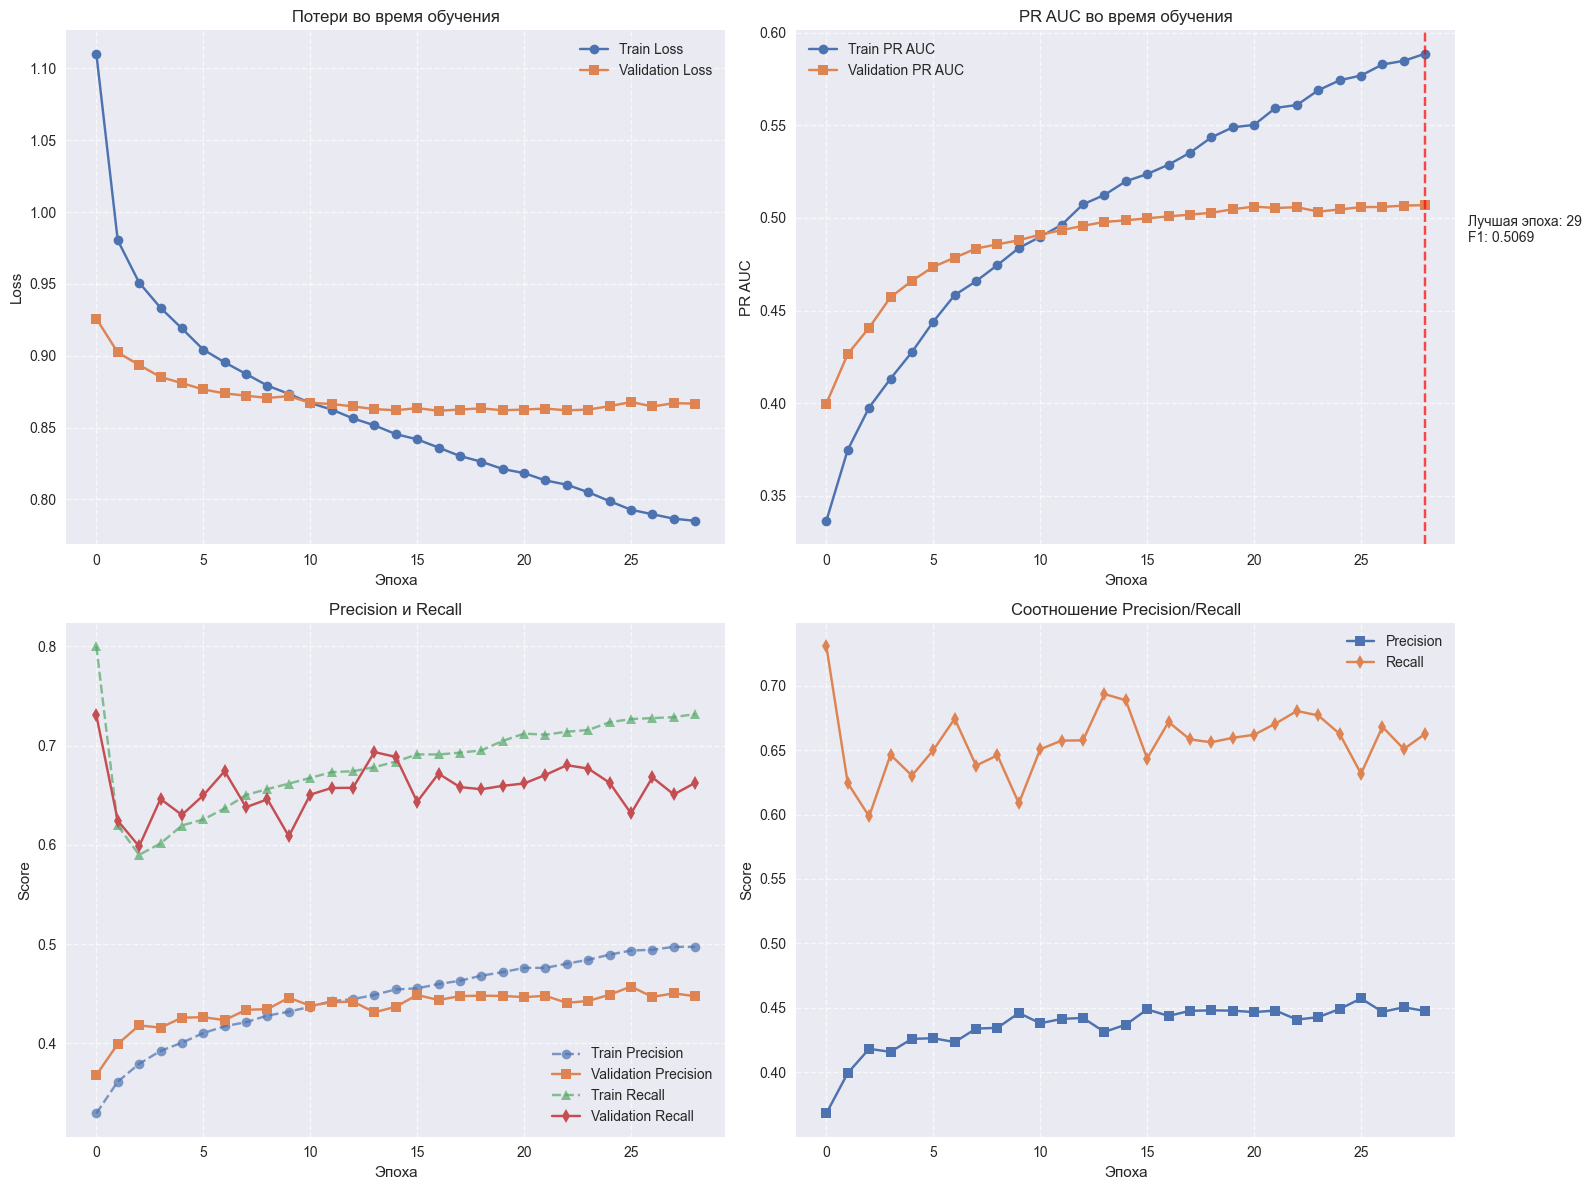


АНАЛИЗ ЛУЧШЕЙ ЭПОХИ
Лучшая эпоха: 22
F1-score: 0.5371
Precision: 0.4480
Recall: 0.6705
PR AUC: 0.5054

Соотношение Precision/Recall: 0.67

Оптимальный порог классификации: 0.40
Максимальный F1-score на валидации при этом пороге: 0.5434


In [274]:
def plot_training_metrics(metrics):
    """Визуализация метрик обучения"""
    plt.figure(figsize=(16, 12))
    
    # График 1: Потери
    plt.subplot(2, 2, 1)
    plt.plot(metrics['train_losses'], 'o-', label='Train Loss')
    plt.plot(metrics['val_losses'], 's-', label='Validation Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title('Потери во время обучения')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # График 2: PR AUC
    plt.subplot(2, 2, 2)
    plt.plot(metrics['train_pr_aucs'], 'o-', label='Train PR AUC')
    plt.plot(metrics['val_pr_aucs'], 's-', label='Validation PR AUC')
    plt.xlabel('Эпоха')
    plt.ylabel('PR AUC')
    plt.title('PR AUC во время обучения')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Находим лучшую эпоху
    best_epoch = np.argmax(metrics['val_pr_aucs']) + 1
    best_f1 = max(metrics['val_pr_aucs'])
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.7)
    plt.annotate(f'Лучшая эпоха: {best_epoch}\nF1: {best_f1:.4f}',
                 xy=(best_epoch-1, best_f1),
                 xytext=(best_epoch-1+2, best_f1-0.02))
    
    # График 3: Precision и Recall
    plt.subplot(2, 2, 3)
    plt.plot(metrics['train_precisions'], 'o--', label='Train Precision', alpha=0.7)
    plt.plot(metrics['val_precisions'], 's-', label='Validation Precision')
    plt.plot(metrics['train_recalls'], '^--', label='Train Recall', alpha=0.7)
    plt.plot(metrics['val_recalls'], 'd-', label='Validation Recall')
    plt.xlabel('Эпоха')
    plt.ylabel('Score')
    plt.title('Precision и Recall')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # График 4: Соотношение Precision/Recall
    plt.subplot(2, 2, 4)
    plt.plot(metrics['val_precisions'], 's-', label='Precision')
    plt.plot(metrics['val_recalls'], 'd-', label='Recall')
    plt.xlabel('Эпоха')
    plt.ylabel('Score')
    plt.title('Соотношение Precision/Recall')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Визуализируем метрики
plot_training_metrics(metrics)

# Анализируем баланс Precision/Recall
best_epoch = np.argmax(metrics['val_f1s'])
print("\n" + "="*70)
print("АНАЛИЗ ЛУЧШЕЙ ЭПОХИ")
print("="*70)
print(f"Лучшая эпоха: {best_epoch+1}")
print(f"F1-score: {metrics['val_f1s'][best_epoch]:.4f}")
print(f"Precision: {metrics['val_precisions'][best_epoch]:.4f}")
print(f"Recall: {metrics['val_recalls'][best_epoch]:.4f}")
print(f"PR AUC: {metrics['val_pr_aucs'][best_epoch]:.4f}")
print(f"\nСоотношение Precision/Recall: {metrics['val_precisions'][best_epoch]/metrics['val_recalls'][best_epoch]:.2f}")

# Оптимизация порога классификации
def find_optimal_threshold(model, dataloader):
    """Находим оптимальный порог для F1-score"""
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for embeddings, labels in dataloader:
            outputs = model(embeddings)
            probs = torch.sigmoid(outputs)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1_scores = []
    
    for threshold in thresholds:
        preds = (np.array(all_probs) >= threshold).astype(int)
        f1 = f1_score(all_labels, preds)
        f1_scores.append(f1)
    
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

# Ищем оптимальный порог
optimal_threshold, best_f1 = find_optimal_threshold(model, val_loader)
print(f"\nОптимальный порог классификации: {optimal_threshold:.2f}")
print(f"Максимальный F1-score на валидации при этом пороге: {best_f1:.4f}")

#### Тестирование

ОЦЕНКА МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ

ОСНОВНЫЕ МЕТРИКИ:
F1-score: 0.5437
Precision: 0.4103
Recall: 0.8054
PR AUC: 0.5133
Accuracy: 0.5678

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Провал       0.83      0.46      0.59     14712
       Успех       0.41      0.81      0.54      6912

    accuracy                           0.57     21624
   macro avg       0.62      0.63      0.57     21624
weighted avg       0.70      0.57      0.57     21624



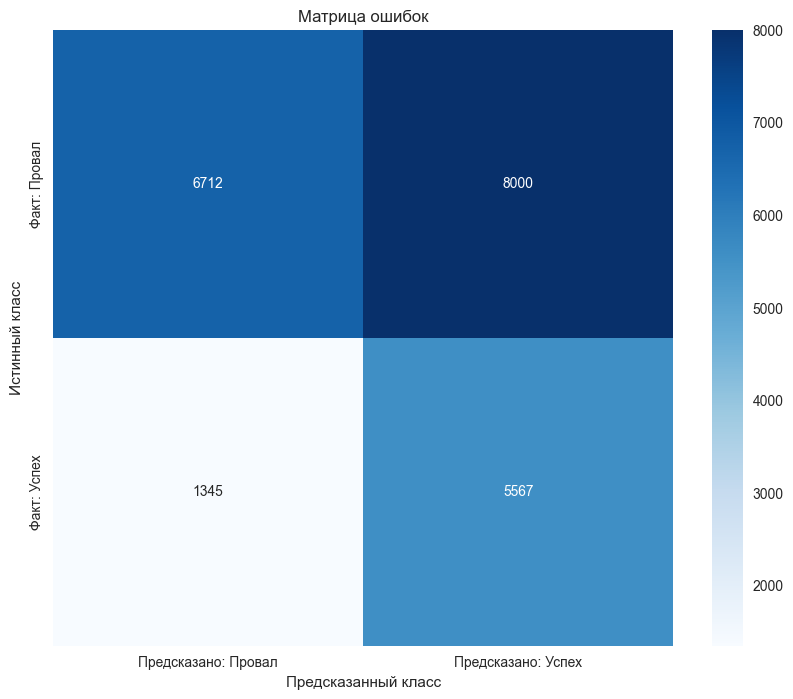

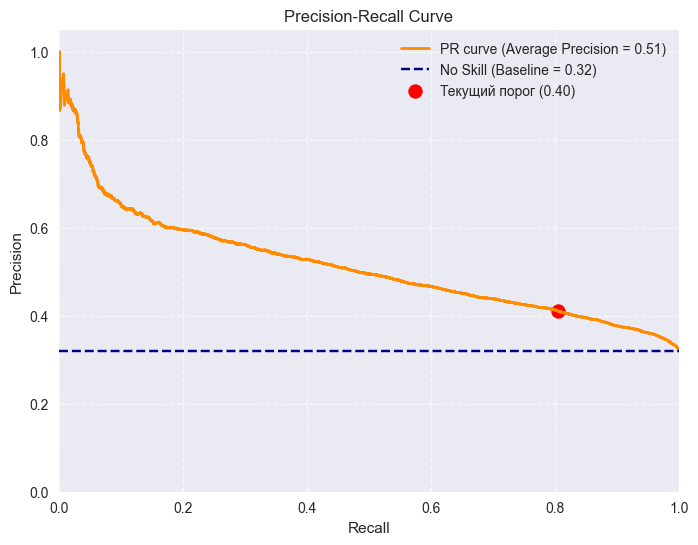


АНАЛИЗ ПОРОГА КЛАССИФИКАЦИИ
Текущий порог: 0.40 (F1 = 0.5437)
Оптимальный порог: 0.40 (F1 = 0.5437)


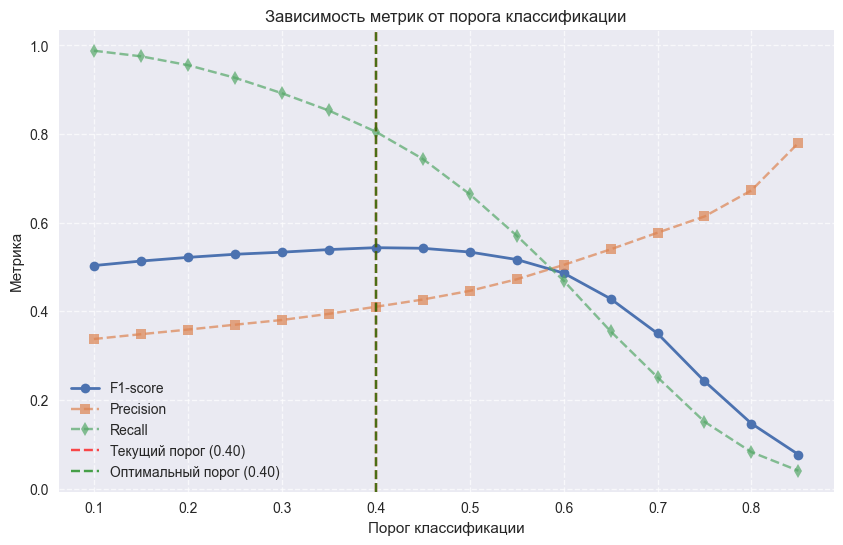

In [275]:
def evaluate_model(model, test_loader, threshold=0.5):
    print("="*70)
    print("ОЦЕНКА МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ")
    print("="*70)
    
    # Получаем предсказания
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for embeddings, labels in test_loader:
            outputs = model(embeddings)
            probs = torch.sigmoid(outputs)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs >= threshold).cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Конвертируем в numpy
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # 1. Основные метрики
    print("\nОСНОВНЫЕ МЕТРИКИ:")
    print(f"F1-score: {f1_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds):.4f}")
    print(f"PR AUC: {average_precision_score(all_labels, all_probs):.4f}")
    print(f"Accuracy: {np.mean(all_preds == all_labels):.4f}")
    
    # 2. Classification report
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(all_labels, all_preds, target_names=['Провал', 'Успех']))
    
    # 3. Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Предсказано: Провал', 'Предсказано: Успех'],
                yticklabels=['Факт: Провал', 'Факт: Успех'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()
    
    # 4. PR Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)
    
    # Базовый уровень (no-skill classifier)
    no_skill = np.mean(all_labels)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, 
             label=f'PR curve (Average Precision = {pr_auc:.2f})')
    
    # Горизонтальная линия для "no skill" классификатора
    plt.axhline(y=no_skill, color='navy', linestyle='--', 
                label=f'No Skill (Baseline = {no_skill:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Добавляем информацию о точке с текущим порогом
    current_precision = precision_score(all_labels, all_preds)
    current_recall = recall_score(all_labels, all_preds)
    plt.scatter(current_recall, current_precision, 
                color='red', s=100, marker='o',
                label=f'Текущий порог ({threshold:.2f})')
    
    plt.legend()
    plt.show()
    
    # 5. Анализ оптимального порога
    print("\n" + "="*50)
    print("АНАЛИЗ ПОРОГА КЛАССИФИКАЦИИ")
    print("="*50)
    
    # Находим F1 для разных порогов
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1_scores = []
    precisions = []
    recalls = []
    
    for t in thresholds:
        preds = (all_probs >= t).astype(int)
        f1 = f1_score(all_labels, preds)
        f1_scores.append(f1)
        precisions.append(precision_score(all_labels, preds))
        recalls.append(recall_score(all_labels, preds))
    
    # Находим оптимальный порог по F1
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    print(f"Текущий порог: {threshold:.2f} (F1 = {f1_scores[np.where(thresholds == threshold)[0][0]]:.4f})")
    print(f"Оптимальный порог: {best_threshold:.2f} (F1 = {f1_scores[best_idx]:.4f})")
    
    # Визуализируем зависимость F1 от порога
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, 'o-', label='F1-score', linewidth=2)
    plt.plot(thresholds, precisions, 's--', label='Precision', alpha=0.7)
    plt.plot(thresholds, recalls, 'd--', label='Recall', alpha=0.7)
    
    plt.axvline(x=threshold, color='r', linestyle='--', alpha=0.7, label=f'Текущий порог ({threshold:.2f})')
    plt.axvline(x=best_threshold, color='g', linestyle='--', alpha=0.7, label=f'Оптимальный порог ({best_threshold:.2f})')
    
    plt.xlabel('Порог классификации')
    plt.ylabel('Метрика')
    plt.title('Зависимость метрик от порога классификации')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем вероятности для дальнейшего анализа
    return all_probs, all_preds, all_labels

# Оцениваем модель на тестовых данных
test_probs, test_preds, test_labels = evaluate_model(model, test_loader, threshold=optimal_threshold)


#### Вывод

Нейросетка в итоге оказалась всё таки немного хуже, чем лучшая модель обученная на TF-IDF (там у нас получился f1-score 0.549). PR AUC тоже получился похуже (на 0.015)

# Использование всех признаков

Попробуем объеденить эмбеддинги SBERT и оргигнальные признаки и обучить на всём этом нейросетку.

## Переводим данные в нужный вид

In [347]:
X_train_sbert = np.hstack([title_embeddings_train, desc_embeddings_train])
X_test_sbert = np.hstack([title_embeddings_test, desc_embeddings_test])

In [348]:
X_train_no_text = X_train.drop(['name', 'desc'], axis=1).to_numpy(dtype='float32')
X_test_no_text = X_test.drop(['name', 'desc'], axis=1).to_numpy(dtype='float32')

In [349]:
X_train_all = np.hstack([X_train_sbert, X_train_no_text])
X_test_all = np.hstack([X_test_sbert, X_test_no_text])

In [350]:
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train_all, y_train, test_size=0.15, random_state=42, stratify=y_train
)

In [351]:
# Рассчитываем веса классов 
class_weights = {
    0: 1.0,
    1: (len(y_train) - sum(y_train)) / sum(y_train)
}
print(f"Веса классов: {class_weights}")

Веса классов: {0: 1.0, 1: 2.128322904987522}


In [352]:
X_train_tensor = torch.FloatTensor(X_train_)
y_train_tensor = torch.FloatTensor(y_train_.values).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_all)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [353]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Инициализация

In [354]:
# Инициализируем модель
model = KickstarterMLP(
    input_size=X_train_.shape[1],
    dropout_rate = 0.2
)

# Настройка обучения
criterion, optimizer, scheduler, early_stopping = setup_training(
    model, 
    class_weights,
    lr=5e-5, # оставил такой после нескольких запуков
    weight_decay=1e-5
)

## Обучение

In [355]:
def train_model(model, train_loader, val_loader, criterion, 
                optimizer, scheduler, early_stopping, epochs=50):
    
    # Списки для хранения метрик
    train_losses = []
    val_losses = []
    train_f1s = []
    val_f1s = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_pr_aucs = []
    val_pr_aucs = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nЭпоха {epoch+1}/{epochs}")
        
        # Обучение
        train_loss, train_f1, train_precision, train_recall, train_pr_auc = train_epoch(
            model, train_loader, criterion, optimizer
        )
        
        # Валидация
        val_loss, val_f1, val_precision, val_recall, val_pr_auc, _, _ = validate_epoch(
            model, val_loader, criterion
        )
        
        # Обновляем LR scheduler
        scheduler.step(val_pr_auc)
        
        # Сохраняем метрики
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        train_pr_aucs.append(train_pr_auc)
        val_pr_aucs.append(val_pr_auc)
        
        # Выводим результаты
        print(f"  Train Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | PR AUC: {train_pr_auc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | F1: {val_f1:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | PR AUC: {val_pr_auc:.4f}")
        
        # Ранняя остановка
        current_score = val_pr_auc
        
        if early_stopping['best_score'] is None:
            early_stopping['best_score'] = current_score
        elif current_score < early_stopping['best_score'] + early_stopping['min_delta']:
            early_stopping['epochs_no_improve'] += 1
            if early_stopping['epochs_no_improve'] >= early_stopping['patience']:
                early_stopping['stop'] = True
                print(f"\nРанняя остановка на эпохе {epoch+1}")
                break
        else:
            early_stopping['best_score'] = current_score
            early_stopping['epochs_no_improve'] = 0
    
    total_time = time.time() - start_time
    print(f"\nОбучение завершено за {total_time:.2f} секунд")
    
    # Возвращаем метрики для визуализации
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_pr_aucs': train_pr_aucs,
        'val_pr_aucs': val_pr_aucs
    }

In [356]:
metrics = train_model(
    model, train_loader, val_loader, criterion, 
    optimizer, scheduler, early_stopping
)


Эпоха 1/50


  Train Loss: 0.7522 | F1: 0.6275 | Precision: 0.4913 | Recall: 0.8681 | PR AUC: 0.6363
  Val Loss: 0.4836 | F1: 0.7702 | Precision: 0.6420 | Recall: 0.9624 | PR AUC: 0.8468

Эпоха 2/50


  Train Loss: 0.5037 | F1: 0.7593 | Precision: 0.6536 | Recall: 0.9058 | PR AUC: 0.8038
  Val Loss: 0.4286 | F1: 0.7858 | Precision: 0.6588 | Recall: 0.9735 | PR AUC: 0.8747

Эпоха 3/50


  Train Loss: 0.4470 | F1: 0.7857 | Precision: 0.6919 | Recall: 0.9088 | PR AUC: 0.8361
  Val Loss: 0.3859 | F1: 0.8090 | Precision: 0.7047 | Recall: 0.9496 | PR AUC: 0.8829

Эпоха 4/50


  Train Loss: 0.4223 | F1: 0.7956 | Precision: 0.7056 | Recall: 0.9117 | PR AUC: 0.8497
  Val Loss: 0.3811 | F1: 0.8062 | Precision: 0.6961 | Recall: 0.9576 | PR AUC: 0.8866

Эпоха 5/50


  Train Loss: 0.4089 | F1: 0.8009 | Precision: 0.7103 | Recall: 0.9179 | PR AUC: 0.8571
  Val Loss: 0.3696 | F1: 0.8154 | Precision: 0.7223 | Recall: 0.9361 | PR AUC: 0.8891

Эпоха 6/50


  Train Loss: 0.3987 | F1: 0.8063 | Precision: 0.7161 | Recall: 0.9226 | PR AUC: 0.8620
  Val Loss: 0.3683 | F1: 0.8141 | Precision: 0.7124 | Recall: 0.9496 | PR AUC: 0.8904

Эпоха 7/50


  Train Loss: 0.3885 | F1: 0.8091 | Precision: 0.7186 | Recall: 0.9257 | PR AUC: 0.8685
  Val Loss: 0.3772 | F1: 0.8049 | Precision: 0.6915 | Recall: 0.9626 | PR AUC: 0.8894

Эпоха 8/50


  Train Loss: 0.3846 | F1: 0.8104 | Precision: 0.7189 | Recall: 0.9286 | PR AUC: 0.8693
  Val Loss: 0.3718 | F1: 0.8076 | Precision: 0.6956 | Recall: 0.9626 | PR AUC: 0.8917

Эпоха 9/50


  Train Loss: 0.3801 | F1: 0.8124 | Precision: 0.7220 | Recall: 0.9287 | PR AUC: 0.8721
  Val Loss: 0.3634 | F1: 0.8160 | Precision: 0.7164 | Recall: 0.9477 | PR AUC: 0.8930

Эпоха 10/50


  Train Loss: 0.3773 | F1: 0.8141 | Precision: 0.7220 | Recall: 0.9332 | PR AUC: 0.8725
  Val Loss: 0.3654 | F1: 0.8110 | Precision: 0.7034 | Recall: 0.9576 | PR AUC: 0.8932

Эпоха 11/50


  Train Loss: 0.3709 | F1: 0.8168 | Precision: 0.7250 | Recall: 0.9351 | PR AUC: 0.8760
  Val Loss: 0.3652 | F1: 0.8121 | Precision: 0.7051 | Recall: 0.9573 | PR AUC: 0.8932

Эпоха 12/50


  Train Loss: 0.3682 | F1: 0.8182 | Precision: 0.7276 | Recall: 0.9344 | PR AUC: 0.8786
  Val Loss: 0.3637 | F1: 0.8152 | Precision: 0.7137 | Recall: 0.9503 | PR AUC: 0.8928

Эпоха 13/50


  Train Loss: 0.3659 | F1: 0.8199 | Precision: 0.7286 | Recall: 0.9375 | PR AUC: 0.8803
  Val Loss: 0.3637 | F1: 0.8146 | Precision: 0.7114 | Recall: 0.9527 | PR AUC: 0.8934

Эпоха 14/50


  Train Loss: 0.3624 | F1: 0.8201 | Precision: 0.7276 | Recall: 0.9396 | PR AUC: 0.8830
  Val Loss: 0.3675 | F1: 0.8093 | Precision: 0.6996 | Recall: 0.9597 | PR AUC: 0.8929

Эпоха 15/50


  Train Loss: 0.3581 | F1: 0.8213 | Precision: 0.7299 | Recall: 0.9387 | PR AUC: 0.8855
  Val Loss: 0.3646 | F1: 0.8122 | Precision: 0.7073 | Recall: 0.9537 | PR AUC: 0.8931

Эпоха 16/50


  Train Loss: 0.3580 | F1: 0.8212 | Precision: 0.7305 | Recall: 0.9376 | PR AUC: 0.8848
  Val Loss: 0.3655 | F1: 0.8101 | Precision: 0.7006 | Recall: 0.9602 | PR AUC: 0.8937

Эпоха 17/50


  Train Loss: 0.3537 | F1: 0.8235 | Precision: 0.7331 | Recall: 0.9394 | PR AUC: 0.8862
  Val Loss: 0.3696 | F1: 0.8072 | Precision: 0.6943 | Recall: 0.9638 | PR AUC: 0.8933

Ранняя остановка на эпохе 17

Обучение завершено за 102.38 секунд


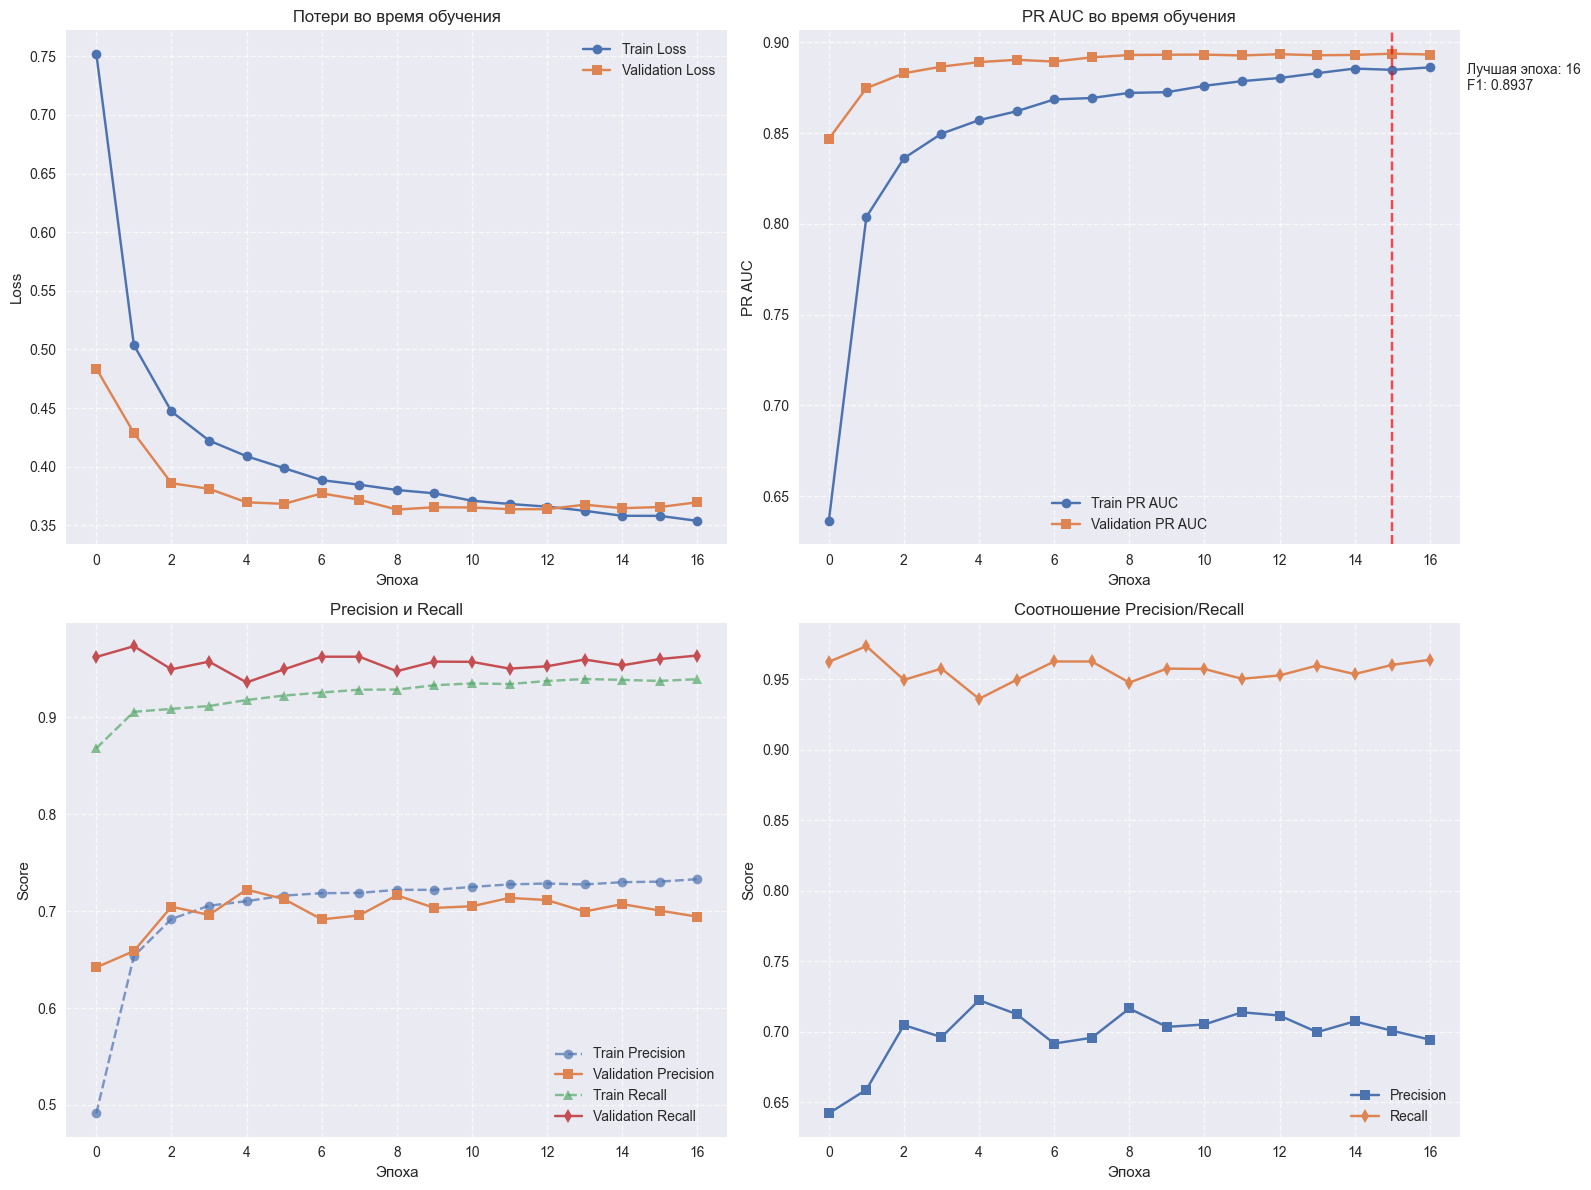


АНАЛИЗ ЛУЧШЕЙ ЭПОХИ
Лучшая эпоха: 9
F1-score: 0.8160
Precision: 0.7164
Recall: 0.9477
PR AUC: 0.8930

Соотношение Precision/Recall: 0.76

Оптимальный порог классификации: 0.65
Максимальный F1-score на валидации при этом пороге: 0.8182


In [357]:
# Визуализируем метрики
plot_training_metrics(metrics)

# Анализируем баланс Precision/Recall
best_epoch = np.argmax(metrics['val_f1s'])
print("\n" + "="*70)
print("АНАЛИЗ ЛУЧШЕЙ ЭПОХИ")
print("="*70)
print(f"Лучшая эпоха: {best_epoch+1}")
print(f"F1-score: {metrics['val_f1s'][best_epoch]:.4f}")
print(f"Precision: {metrics['val_precisions'][best_epoch]:.4f}")
print(f"Recall: {metrics['val_recalls'][best_epoch]:.4f}")
print(f"PR AUC: {metrics['val_pr_aucs'][best_epoch]:.4f}")
print(f"\nСоотношение Precision/Recall: {metrics['val_precisions'][best_epoch]/metrics['val_recalls'][best_epoch]:.2f}")

# Ищем оптимальный порог
optimal_threshold, best_f1 = find_optimal_threshold(model, val_loader)
print(f"\nОптимальный порог классификации: {optimal_threshold:.2f}")
print(f"Максимальный F1-score на валидации при этом пороге: {best_f1:.4f}")

## Тестирование

ОЦЕНКА МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ

ОСНОВНЫЕ МЕТРИКИ:
F1-score: 0.8159
Precision: 0.7323
Recall: 0.9212
PR AUC: 0.8899
Accuracy: 0.8671

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Провал       0.96      0.84      0.90     14712
       Успех       0.73      0.92      0.82      6912

    accuracy                           0.87     21624
   macro avg       0.85      0.88      0.86     21624
weighted avg       0.89      0.87      0.87     21624



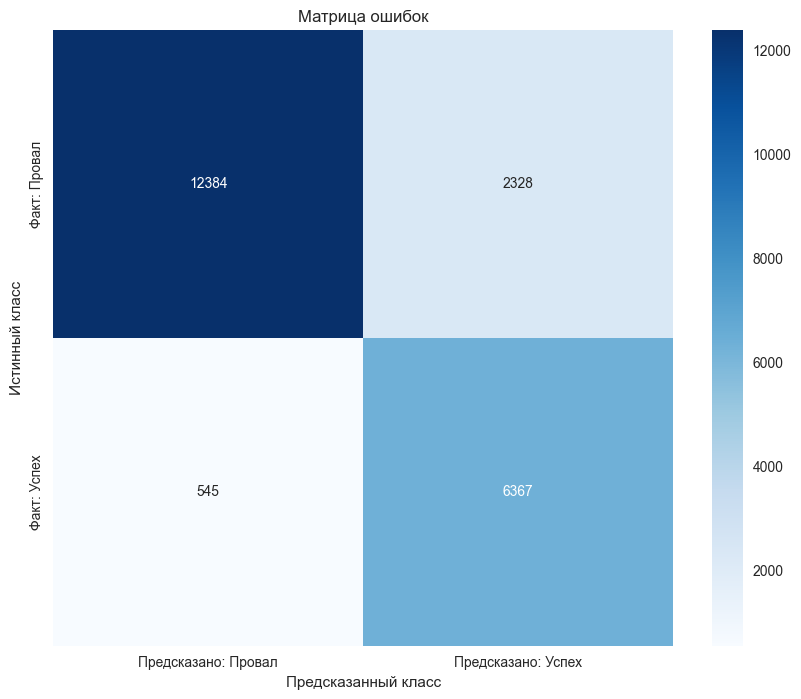

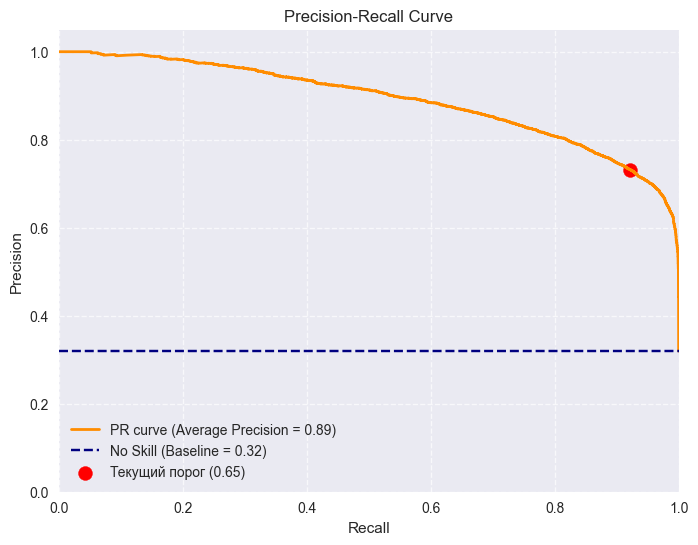


АНАЛИЗ ПОРОГА КЛАССИФИКАЦИИ
Текущий порог: 0.65 (F1 = 0.8159)
Оптимальный порог: 0.70 (F1 = 0.8170)


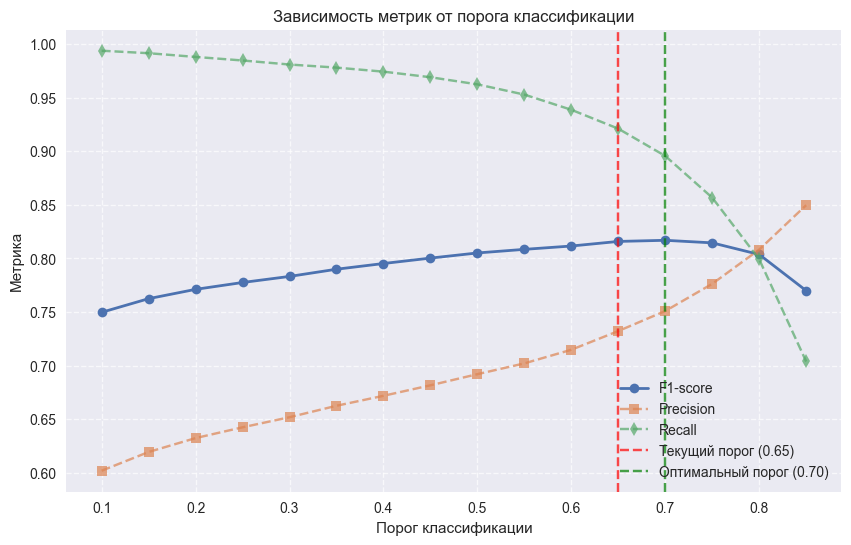

In [358]:
# Оцениваем модель на тестовых данных
test_probs, test_preds, test_labels = evaluate_model(model, test_loader, threshold=optimal_threshold)

**Вывод:**

Даже с добавлением информации из описания и названия, мы не смогли побить предсказания без них. Таким образом, несмотря на то что какая-то полезная информация в них содержится (мы можем предсказывать лучше случайного угадывания), в конечном итоге они не так важны с точки зрения успеха.

# Табличные трансформеры

Решил добавить этот пункт, после того как узнал про них.

Придётся немного переделать предобработку - числовые переменные обрабатываем также, а для категориальных не делаем OHE.

## Предобработка данных

In [3]:
data_train = pd.read_csv('train.csv')

Всё то же что и раньше

In [4]:
data_train['name'] = data_train['keywords'].str.split('-').str.join(' ')
data_train.drop(['keywords', 'project_id'], axis=1, inplace=True)
data_train.dropna(inplace=True)

### Даты

In [5]:
data_train["launched_at"] = pd.to_datetime(data_train["launched_at"], unit="s")
data_train["created_at"] = pd.to_datetime(data_train["created_at"], unit="s")
data_train["deadline"] = pd.to_datetime(data_train["deadline"], unit="s")
data_train["state_changed_at"] = pd.to_datetime(data_train["state_changed_at"], unit="s")

# Год
data_train["year_trend"] = data_train["launched_at"].dt.year - data_train["launched_at"].dt.year.min()

# Месяц
data_train['month_launched'] = data_train["launched_at"].dt.month.astype("category")

# # Делаем OHE месяца
# data_train = pd.get_dummies(
#     data_train,
#     columns=["month_launched"],
#     prefix="month_launched",        
#     prefix_sep="_",        
#     drop_first=True        
# )

# Преобразование дня
data_train["day_sin"] = np.sin(2 * np.pi * data_train["launched_at"].dt.day / 31)
data_train["day_cos"] = np.cos(2 * np.pi * data_train["launched_at"].dt.day / 31)

# Флаг на выходные
data_train["is_weekend"] = data_train["launched_at"].dt.dayofweek.isin([5, 6]).astype(int)

data_train['created_dif'] = (data_train['launched_at'] - data_train['created_at']).dt.days
data_train['campaign_duration'] = (data_train['deadline'] - data_train['launched_at']).dt.days
data_train.drop(['state_changed_at', 'launched_at', 'created_at', 'deadline'], axis = 1, inplace=True)

### Категориальные

country

In [6]:
# Конвертируем коды стран в регионы
cc = coco.CountryConverter()
data_train["region"] = data_train["country"].apply(
    lambda x: cc.convert(names=x, to="continent", not_found="Other")
)
data_train.drop(['country'], axis=1, inplace=True)

currency

In [7]:
main_currencies = set(['USD', 'GBP', 'EUR', 'CAD'])
data_train['currency'] = data_train['currency'].apply(lambda x: x if x in main_currencies else 'Other')

### Разбиение на train/test

In [8]:
y = data_train['final_status'].copy()
X = data_train.drop(['final_status'], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Числовые

In [9]:
# goal
# Логарифимруем
X_train["goal"] = np.log10(X_train["goal"] + 1)
X_test["goal"] = np.log10(X_test["goal"] + 1)

# Нормализуем
scaler = RobustScaler()
X_train["goal"] = scaler.fit_transform(X_train[["goal"]])
X_test["goal"] = scaler.transform(X_test[["goal"]])

# backers_count
# Логарифимруем
X_train["backers_count"] = np.log10(X_train["backers_count"] + 1)
X_test["backers_count"] = np.log10(X_test["backers_count"] + 1)

# Нормализуем
scaler = RobustScaler()
X_train["backers_count"] = scaler.fit_transform(X_train[["backers_count"]])
X_test["backers_count"] = scaler.transform(X_test[["backers_count"]])

# created_dif
# Логарифимруем
X_train["created_dif"] = np.log10(X_train["created_dif"] + 1)
X_test["created_dif"] = np.log10(X_test["created_dif"] + 1)

# Нормализуем
scaler = RobustScaler()
X_train["created_dif"] = scaler.fit_transform(X_train[["created_dif"]])
X_test["created_dif"] = scaler.transform(X_test[["created_dif"]])

# campaign_duration
def categorize_duration(days):
    if days <= 14:
        return "Very_Short"
    elif 15 <= days <= 24:
        return "Short"
    elif 25 <= days <= 35:
        return "Normal"
    elif 36 <= days <= 54:
        return "Long"
    elif 55 <= days <= 65:
        return "Two_month"
    else:
        return "Very_long"

X_train["campaign_duration"] = X_train["campaign_duration"].apply(categorize_duration)
X_test["campaign_duration"] = X_test["campaign_duration"].apply(categorize_duration)

Простые текстовые

In [10]:
X_train['words_name'] = X_train['name'].apply(lambda x: len(x.split()))
X_train['words_desc'] = X_train['desc'].apply(lambda x: len(x.split()))
X_train['uppercase_ratio'] = X_train['desc'].apply(lambda text: sum(1 for char in text if char.isupper()) / max(len(text), 1))
X_train['exlam_and_quest'] = X_train['desc'].apply(lambda text: sum(1 for char in text if char == '!' or char == '?'))

X_test['words_name'] = X_test['name'].apply(lambda x: len(x.split()))
X_test['words_desc'] = X_test['desc'].apply(lambda x: len(x.split()))
X_test['uppercase_ratio'] = X_test['desc'].apply(lambda text: sum(1 for char in text if char.isupper()) / max(len(text), 1))
X_test['exlam_and_quest'] = X_test['desc'].apply(lambda text: sum(1 for char in text if char == '!' or char == '?'))

# Количество слов в названии
scaler = StandardScaler()
X_train['words_name'] = scaler.fit_transform(X_train[['words_name']])
X_test['words_name'] = scaler.transform(X_test[['words_name']])

# Количество слов в описании
scaler = StandardScaler()
X_train['words_desc'] = scaler.fit_transform(X_train[['words_desc']])
X_test['words_desc'] = scaler.transform(X_test[['words_desc']])

# Доля заглавных букв в описании
X_train['uppercase_ratio'] = np.log(X_train[['uppercase_ratio']] + 0.01)
X_test['uppercase_ratio'] = np.log(X_test[['uppercase_ratio']] + 0.01)

scaler = StandardScaler()
X_train['uppercase_ratio'] = scaler.fit_transform(X_train[['uppercase_ratio']])
X_test['uppercase_ratio'] = scaler.transform(X_test[['uppercase_ratio']])

# Кол-во восклицательных и вопросительных знаков
def exlam_and_quest_classifier(counter):
    if counter == 0:
        return 0
    elif counter < 4:
        return 1
    elif counter < 9:
        return 2
    else:
        return 3

X_train["exlam_and_quest"] = X_train["exlam_and_quest"].apply(exlam_and_quest_classifier)

## Обучаем

In [11]:
X_train_no_text = X_train.drop(['name', 'desc'], axis=1)
X_test_no_text = X_test.drop(['name', 'desc'], axis=1)

In [12]:
full_train = X_train_no_text.copy()
full_train['target'] = y_train

full_test = X_test_no_text.copy()
full_test['target'] = y_test

In [13]:
full_train.columns

Index(['goal', 'disable_communication', 'currency', 'backers_count',
       'year_trend', 'month_launched', 'day_sin', 'day_cos', 'is_weekend',
       'created_dif', 'campaign_duration', 'region', 'words_name',
       'words_desc', 'uppercase_ratio', 'exlam_and_quest', 'target'],
      dtype='object')

### Конфигурация базовой модели

In [14]:
cat_cols = ['region', 'currency', 'month_launched', 'campaign_duration', 'disable_communication', 'is_weekend', 'exlam_and_quest']

In [ ]:
# Определяем типы признаков
data_config = DataConfig(
    target=['target'],  
    continuous_cols=[col for col in full_train.columns if col not in cat_cols and col != 'target'],
    categorical_cols=cat_cols,
)

# Конфигурация модели
model_config = TabTransformerConfig(
    task="classification",
    metrics=["f1_score", "average_precision", 'accuracy'],
    metrics_prob_input=[False, True, False]
)

# Конфигурация тренера (обучения)
trainer_config = TrainerConfig(
    max_epochs=50,
    early_stopping='valid_f1_score',
    load_best=False
)

# Оптимизатор
optimizer_config = OptimizerConfig()

# Создаём TabularModel
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config
)

2025-09-09 15:45:24,628 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [28]:
# Запуск обучения
tabular_model.fit(train= full_train)

Seed set to 42


2025-09-09 15:45:24,836 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-09-09 15:45:24,877 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-09-09 15:45:25,021 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabTransformerModel

2025-09-09 15:45:25,083 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-09-09 15:45:25,105 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │  1.4 K │ train │
│ 2 │ _head            │ LinearHead             │    468 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 273 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 273 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 133                                                                                         
Modules in eval mode: 0

Output()

2025-09-09 15:51:24,749 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

### Тестирование базовой модели

К сожалению, в текущей версии библиотеки настройка подсчёта метрик не работает и всегда считает макро вариант (общался с авторами на гитхабе). Поэтому метрики считаем вручную, а не встроенным evaluate.

In [29]:
def process_result(y_pred, y_pred_proba, y_test):
    result =  {
            'f1_test': f1_score(y_test, y_pred),
            'PR_AUC_test': average_precision_score(y_test, y_pred_proba),
            'accuracy': accuracy_score(y_test, y_pred),
            'predictions': y_pred,
            'probabilities': y_pred_proba
            }

    return result


def print_results_no_val(results):
    print(f"Тестовый f1-score: {results['f1_test']:.3f}")
    print()
    print(f"Тестовый PR AUC: {results['PR_AUC_test']:.3f}")
    print()
    print(f"Тестовый accuracy: {results['accuracy']:.3f}")
    print()

In [34]:
pred_df

,target_0_probability,target_1_probability,target_prediction
28214,0.995,0.005,0
56448,0.354,0.646,1
96783,0.393,0.607,1
63814,0.008,0.992,1
39127,1.000,0.000,0
...,...,...,...
97806,0.371,0.629,1
49543,0.230,0.770,1
83007,0.299,0.701,1
15214,0.211,0.789,1


In [30]:
pred_df = tabular_model.predict(full_test)

In [31]:
results = process_result(pred_df['target_prediction'], pred_df['target_1_probability'], y_test)

In [32]:
print_results_no_val(results)

Тестовый f1-score: 0.794

Тестовый PR AUC: 0.881

Тестовый accuracy: 0.871



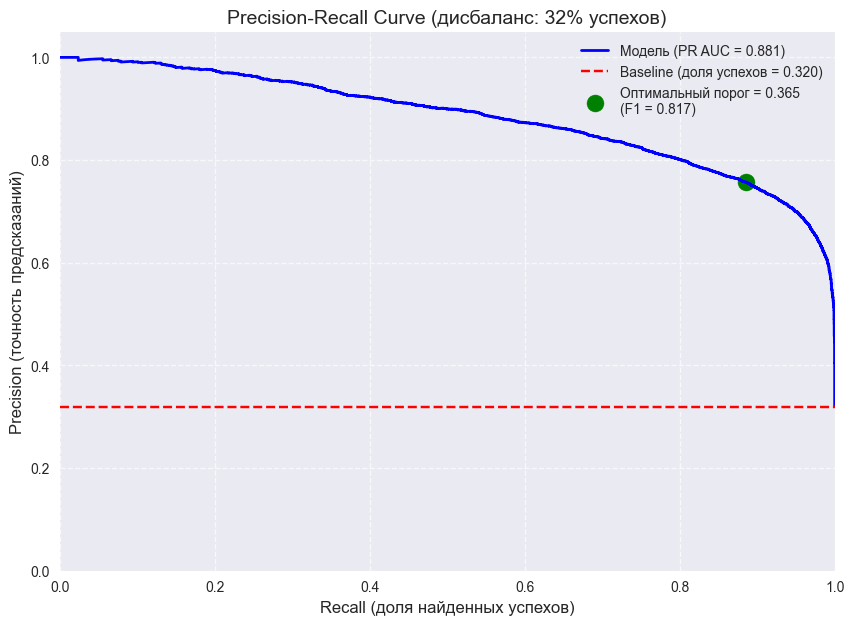

(0.3647741, 0.8814272645320946)

In [33]:
plot_precision_recall_curve(y_test, pred_df['target_1_probability'])

Что ж, результаты получились не очень впечатляющими, но можно всё таки попробовать пооптимизировать.

# Заключение

**Лучшая модель:** Блендинг на основе моделей, обученных на нетекстовых данных

- **f1-score на тесте:** 0.821

- **PR AUC на тесте:** 0.891

**Ключевые факторы и рекомендации:**

- ***Количество бекеров*** - кол-во людей поддерживающих проект является без зазарения совести абсолютно центральным показателем в этой истории. На старте компании нужно набрать их как можно больше - это очень сильно увеличит шансы на успех.

- ***Целевая сумма проекта*** - маленькие проекты гораздо легче чаще преуспевают, чем крупные. Поэтому прежде, чем замахиваться на гигантские суммы нужно дважды подумать или четко всё спланировать

- ***Отключение коммуникаций*** - довольно очевидно, но отключение коммуникации - это красный флаг для пользователей, что с проектом что-то не так, поэтому ни в коем случае лучше этого не делать.

- ***Валюта для сборов*** - безопасный, но не самый эффективный - собирать в долларах. Однако если у проекта какая-та специфически страновая целевая аудитория, то лучше взять валюту этой страны - это увеличит шансы на успех. Исключение: фунты - проекты с этой валютой показыват себя хуже, хотя тут вероятно обратная зависимость и специфически Английские проекты направленные на внутренюю аудитории не востребованы.

- ***Дата запуска*** - судя по всему конкретный день запуска не имеет решающей роли, однако если всё же отталкиваться от весов, то лучше НЕ запускать кампанию летом и осенью.

**Итоговый самый безопасный вариант**

Маленький проект на 100 - 1000$ с сроком сборов в 15-20 дней, запущенный в начале декабря, с включенными комментариями и 3-5 бекерами.